In [1]:
import sys
import json
import gzip
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
from joblib import Parallel, delayed

# Set up the system path to include parent directory
sys.path.append('../../')

def configure_logging():
    """
    Configure RDKit logging to suppress warnings and errors.
    """
    lg = RDLogger.logger()
    lg.setLevel(RDLogger.ERROR)

def load_data(file_path):
    """
    Load the dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)

def main():
    """
    Main function to execute script tasks.
    """
    configure_logging()

    # Load data
    try:
        data_file_path = '../Data/USPTO_50k.csv'
        df = load_data(data_file_path)
    except:
        data_file_path = '../../Data/USPTO_50K.csv'
        df = load_data(data_file_path)
    

    # Display the first few rows of the DataFrame
    display(df.head())

    # Print the number of rows in the DataFrame
    print(f"Number of rows in the dataset: {len(df)}")
    return df

if __name__ == "__main__":
    df = main()


Error: File '../Data/USPTO_50k.csv' not found.


id  class                                          reactions
0       US05849732      6  COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1  US20120114765A1      2  Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2     US08003648B2      1  CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3     US09045475B2      1  CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4     US08188098B2      2  CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...

Number of rows in the dataset: 50016


# **1. SynExtract**

Here's a brief description of how we can approach the task:

1. **Input and Parsing of Chemical Reactions**: The script will accept chemical reactions as input. Each reaction will be a string where reactants and products are separated by an arrow (e.g., A + B -> C + D). The script will parse these strings to identify reactants and products.

2. **Standardization of Chemical Formulas**: The script will standardize the chemical formulas to ensure consistency. This involves formatting element symbols and quantities properly.

3. **Decomposition into Molecular Formulas**: Each reactant and product will be broken down into its molecular formula. For example, decomposing H2O into {'H': 2, 'O': 1}.

4. **Labeling Types of Reactions**:

    - **Balance Check**: The script will check if the reaction is balanced by comparing the count of each element on both sides of the reaction.
    - **Labeling**: Based on the balance check, reactions will be labeled as:
        - **Balanced**: If the number of each type of atom is the same on both sides.
        - **Unbalanced in Reactants**: If any reactant element is not balanced.
        - **Unbalanced in Products**: If any product element is not balanced.
        - **Unbalanced in Both**: If elements in both reactants and products are unbalanced.

## **1.1. Extract SMILES**

In [2]:
from SynRBL.SynExtract.rsmi_processing import RSMIProcessing
process = RSMIProcessing(data=df, rsmi_col='reactions', parallel=True, n_jobs=10, 
                            save_json =True, save_path_name= '../../Data/reaction.json.gz')
reactions = process.data_splitter()

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 5120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.8s finished


In [3]:
from SynRBL.rsmi_utils import load_database
reactions = load_database('../../Data/reaction.json.gz')
reactions

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1',
  'reactants': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1',
  '

## **1.2. Standardize SMILES**

In [6]:
from SynRBL.SynCleaning import SMILESStandardizer
standardize = SMILESStandardizer()
reactions_standardized=standardize.standardize_dict_smiles(reactions,keys = ['reactants', 'products'], keep_mol=False,
                                                           normalize = True, tautomerize=True)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


## **1.3. Molecular Decomposer**

In [4]:
from SynRBL.SynExtract import RSMIDecomposer  
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=-1, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    2.1s finished


## **1.4. Molecular Comparator**

In [5]:
from SynRBL.SynExtract.rsmi_comparator import RSMIComparator
from SynRBL.rsmi_utils import save_database
import pandas as pd

In [6]:
comp = RSMIComparator(reactants= react_dict, products=product_dict, n_jobs=-1)
unbalance , diff_formula= comp.run_parallel(reactants= react_dict, products=product_dict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.3s finished


## **1.5. Both side reactions rules**

In [7]:
from SynRBL.SynExtract.rsmi_both_side_process import BothSideReact


both_side = BothSideReact(react_dict, product_dict, unbalance, diff_formula)
diff_formula, unbalance= both_side.fit()

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 2740 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 3088 out of 3088 | elapsed:    0.2s finished


In [8]:
reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0:'Unbalance'}),
           pd.DataFrame([diff_formula]).T.rename(columns={0:'Diff_formula'})], axis=1).to_dict(orient='records')
save_database(reactions_clean, '../../Data/reaction_clean.json.gz')

reactions_clean

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 8, 'O': 2, 'H': 6}},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'Unbalance': 'Products',
  'Diff_formula': {'O': 1, 'H': 2}},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccc

# **2. SynRuleEngine - Rule Generation**

## **2.1. Manual Rules Extraction**

In [10]:
from SynRBL.rsmi_utils import save_database, load_database, filter_data, sort_by_key_length
from SynRBL.SynRuleEngine.rule_data_manager import RuleImputeManager
   

rules = []
former_len = len(rules)
db = RuleImputeManager(rules)

entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

rules = filter_data(db.database, formula_key='Composition', element_key='C', min_count=0, max_count=1)
rules = sort_by_key_length(db.database, lambda x: x['Composition'])

rules

Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]


[10:40:16] SMILES Parse Error: syntax error while parsing: Invalid
[10:40:16] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


[{'formula': 'CO2',
  'smiles': 'C=O',
  'Composition': {'C': 1, 'O': 1, 'H': 2, 'Q': 0}}]

## **2.2. Automatic rule extraction**

In [ ]:
import sys
import gzip
import json
sys.path.append('../')
from SynRBL.SynRuleEngine import AutomaticSmilesExtraction, AutomaticRulesExtraction
from SynRBL.rsmi_utils import load_database
reactions = load_database('../../Data/reaction_clean.json.gz')


# Create an instance of the AutomaticSmilesExtraction class with parallel processing
smi_extractor = AutomaticSmilesExtraction(reactions, n_jobs=-1, verbose=1)

# Example usage of get_fragments
input_dict = {
    'smiles': smi_extractor.smiles_list,
    'mw': smi_extractor.mw,
    'n_C': smi_extractor.n_C
}
filtered_fragments = AutomaticSmilesExtraction.get_fragments(input_dict, mw=500, n_C=0, combination='intersection')
print("Filtered Fragments:", len(filtered_fragments))


extractor = AutomaticRulesExtraction(existing_database=[], n_jobs=-1, verbose=1)
extractor.add_new_entries(filtered_fragments)
automated_rules = extractor.extract_rules()
print("Extracted Rules:", len(automated_rules))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 126189 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1190 out of 1190 | elapsed:    0.0s finished


Filtered Fragments: 3
Entry with formula 'H3N' and smiles 'N' added to the database.
Entry with formula 'H2O' and smiles 'O' added to the database.
Entry with formula 'N3-' and smiles '[N-]=[N+]=[N-]' added to the database.
Entry with formula 'H4N2' and smiles 'NN' added to the database.
Entry with formula 'HO4S-' and smiles 'O=S([O-])OO' added to the database.
Entry with formula 'H3NO' and smiles 'NO' added to the database.
Entry with formula 'H4N+' and smiles '[NH4+]' added to the database.
Entry with formula 'HI' and smiles 'I' added to the database.
Entry with formula 'H2O2' and smiles 'OO' added to the database.
Entry with formula 'H4N2O2S' and smiles 'NS(N)(=O)=O' added to the database.
Entry with formula 'HBr' and smiles 'Br' added to the database.
Entry with formula 'HClO3S' and smiles 'O=S(=O)(O)Cl' added to the database.
Entry with formula 'HCl' and smiles 'Cl' added to the database.
Entry with formula 'Cl2O2S' and smiles 'O=S(=O)(Cl)Cl' added to the database.
Entry with form

# **3. SynRuleImpute**


## **3.1. Rule-based Imputation**

In [9]:
from SynRBL.rsmi_utils import save_database, load_database, filter_data, extract_results_by_key
from SynRBL.SynRuleImpute import SyntheticRuleImputer

rules = load_database('../../Data/Rules/rules_manager.json.gz')
reactions_clean = load_database('../../Data/reaction_clean.json.gz')

# Filter data based on specified criteria
no_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
print('Number of Non-Carbon Reactions Unbalanced in one side:', len(no_C_reactions))

un_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key='C', min_count=1, max_count=1000)
print('Number of Carbon Reactions Unbalanced in one side:', len(un_C_reactions))

both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                                    formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Both sides Unbalanced Reactions:', len(both_side_reactions))

balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                                formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Balanced Reactions:', len(balance_reactions))

Number of Non-Carbon Reactions Unbalanced in one side: 32280
Number of Carbon Reactions Unbalanced in one side: 13752
Number of Both sides Unbalanced Reactions: 2908
Number of Balanced Reactions: 1076


In [11]:
# Configure RDKit logging
from rdkit import Chem
import rdkit
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
rdkit.RDLogger.DisableLog('rdApp.*')

# Initialize SyntheticRuleImputer and perform parallel imputation
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')
expected_result = imp.parallel_impute(no_C_reactions)

# Extract solved and unsolved results
solve, unsolve = extract_results_by_key(expected_result)
print('Solved:', len(solve))
print('Unsolved in rules based method:', len(unsolve))

# Combine all unsolved cases
unsolve = un_C_reactions + both_side_reactions + unsolve
print('Total unsolved:', len(unsolve))

# Save solved and unsolved reactions
save_database(solve,  '../../Data/Solved_reactions.json.gz')
save_database(unsolve,  '../../Data/Unsolved_reactions.json.gz')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 6122 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 32280 out of 32280 | elapsed:    1.5s finished


Solved: 30434
Unsolved in rules based method: 1846
Total unsolved: 18506


## **3.2. Visualization**

In [369]:
import copy
import re
from rdkit import Chem
from typing import List, Dict, Pattern, Any, Optional, Tuple

class RuleConstraint:
    """
    A class for applying specific chemical reaction constraints and modifications.

    Attributes
    ----------
    list_dict : list of dict
        A list containing chemical reaction data.
    ban_atoms : list of str
        A list of SMILES strings representing banned atoms or molecules in reactions.

    Methods
    -------
    fit():
        Applies oxidation rules to modify reactions and filters out reactions with banned atoms.
    """

    def __init__(
        self, 
        list_dict: List[Dict[str, Any]], 
        ban_atoms: Optional[List[str]] = None
        ) -> None:
        """
        Initializes the RuleConstraint class with a list of chemical reactions and optional banned atoms.

        Parameters
        ----------
        list_dict : List[Dict[str, Any]]
            A list of dictionaries, each representing a chemical reaction.
        ban_atoms : Optional[List[str]], optional
            A list of SMILES strings for atoms or molecules to be banned from the reactions. 
            Defaults to a predefined list.
        """
        self.list_dict = list_dict
        self.ban_atoms = ban_atoms or ['O=O', 'F-F', 'Cl-Cl', 'Br-Br', 'I-I', 'Cl-Br', 'Cl-I', 'Br-I']
        self.ban_atoms = [Chem.CanonSmiles(atom) for atom in self.ban_atoms]
        self.ban_pattern = re.compile('|'.join(map(re.escape, self.ban_atoms)))
  
    @staticmethod
    def oxidation_rules_modify(
        data: List[Dict[str, str]]
        ) -> List[Dict[str, str]]:
        """
        Modify the oxidation rules in the given data.

        Args:
            data (List[Dict[str, str]]): The input data containing oxidation rules.

        Returns:
            List[Dict[str, str]]: The modified data with updated oxidation rules.
        """
        modified_data = []
        for entry in data:
            products = entry['products']
            reactants = entry['reactants']
            if '[H]' in products:
                products = products.replace('.[H]', '').replace('[H]', '')
                reactants += '.O=O'

                if products:
                    products += '.O'
                else:
                    products = 'O'

            new_reaction = f"{reactants}>>{products}"
            entry['new_reaction'] = new_reaction
            modified_data.append(entry)

        return modified_data

    @staticmethod
    def remove_banned_reactions(
        reaction_list: List[Dict[str, str]], 
        ban_pattern: Pattern
        ) -> Tuple[List[Dict[str, str]], List[Dict[str, str]]]:
        """
        Filters out reactions that contain banned atoms in their products.

        Parameters:
        reaction_list (List[Dict[str, str]]): A list containing reaction data.
        ban_pattern (Pattern): A compiled regular expression pattern that matches any of the banned atoms.

        Returns:
        Tuple[List[Dict[str, str]], List[Dict[str, str]]]: The filtered list of reactions without and with banned atoms in their products.
        """
        filtered_reactions = [reaction for reaction in reaction_list if not ban_pattern.search(reaction.get('products', ''))]
        reactions_with_banned_atoms = [reaction for reaction in reaction_list if ban_pattern.search(reaction.get('products', ''))]
        return filtered_reactions, reactions_with_banned_atoms
    
    def fit(self
        ) -> List[Dict[str, Any]]:
        """
        Applies oxidation modification rules and filters out reactions with banned atoms.

        Returns
        -------
        List[Dict[str, Any]]
            The modified and filtered list of chemical reactions.
        """
        data_modified = self.oxidation_rules_modify(self.list_dict)
        return self.remove_banned_reactions(data_modified, self.ban_pattern)
        


In [370]:
from SynRBL.rsmi_utils import  save_database, load_database, get_random_samples_by_key
#from SynRBL.SynRuleImpute.synthetic_rule_constraint import RuleConstraint
#solve = load_database('../../Data/Solved_reactions.json.gz')

constrain = RuleConstraint(solve, ban_atoms=['O=O', 'F-F', 'Cl-Cl', 'Br-Br', 'I-I', 'Cl-Br', 'Cl-I', 'Br-I'])
certain_reactions, uncertain_reactions = constrain.fit()

#save_database(certain_reactions, '../../Data/certain_reactions.json.gz')
#save_database(uncertain_reactions, '../../Data/uncertain_reactions.json.gz')

validate_samples = get_random_samples_by_key(certain_reactions, num_samples_per_group=10, random_seed=42, stratify_key = 'Diff_formula')
#save_database(validate_samples, '../../Data/validate_samples.json.gz')
len(validate_samples)


410

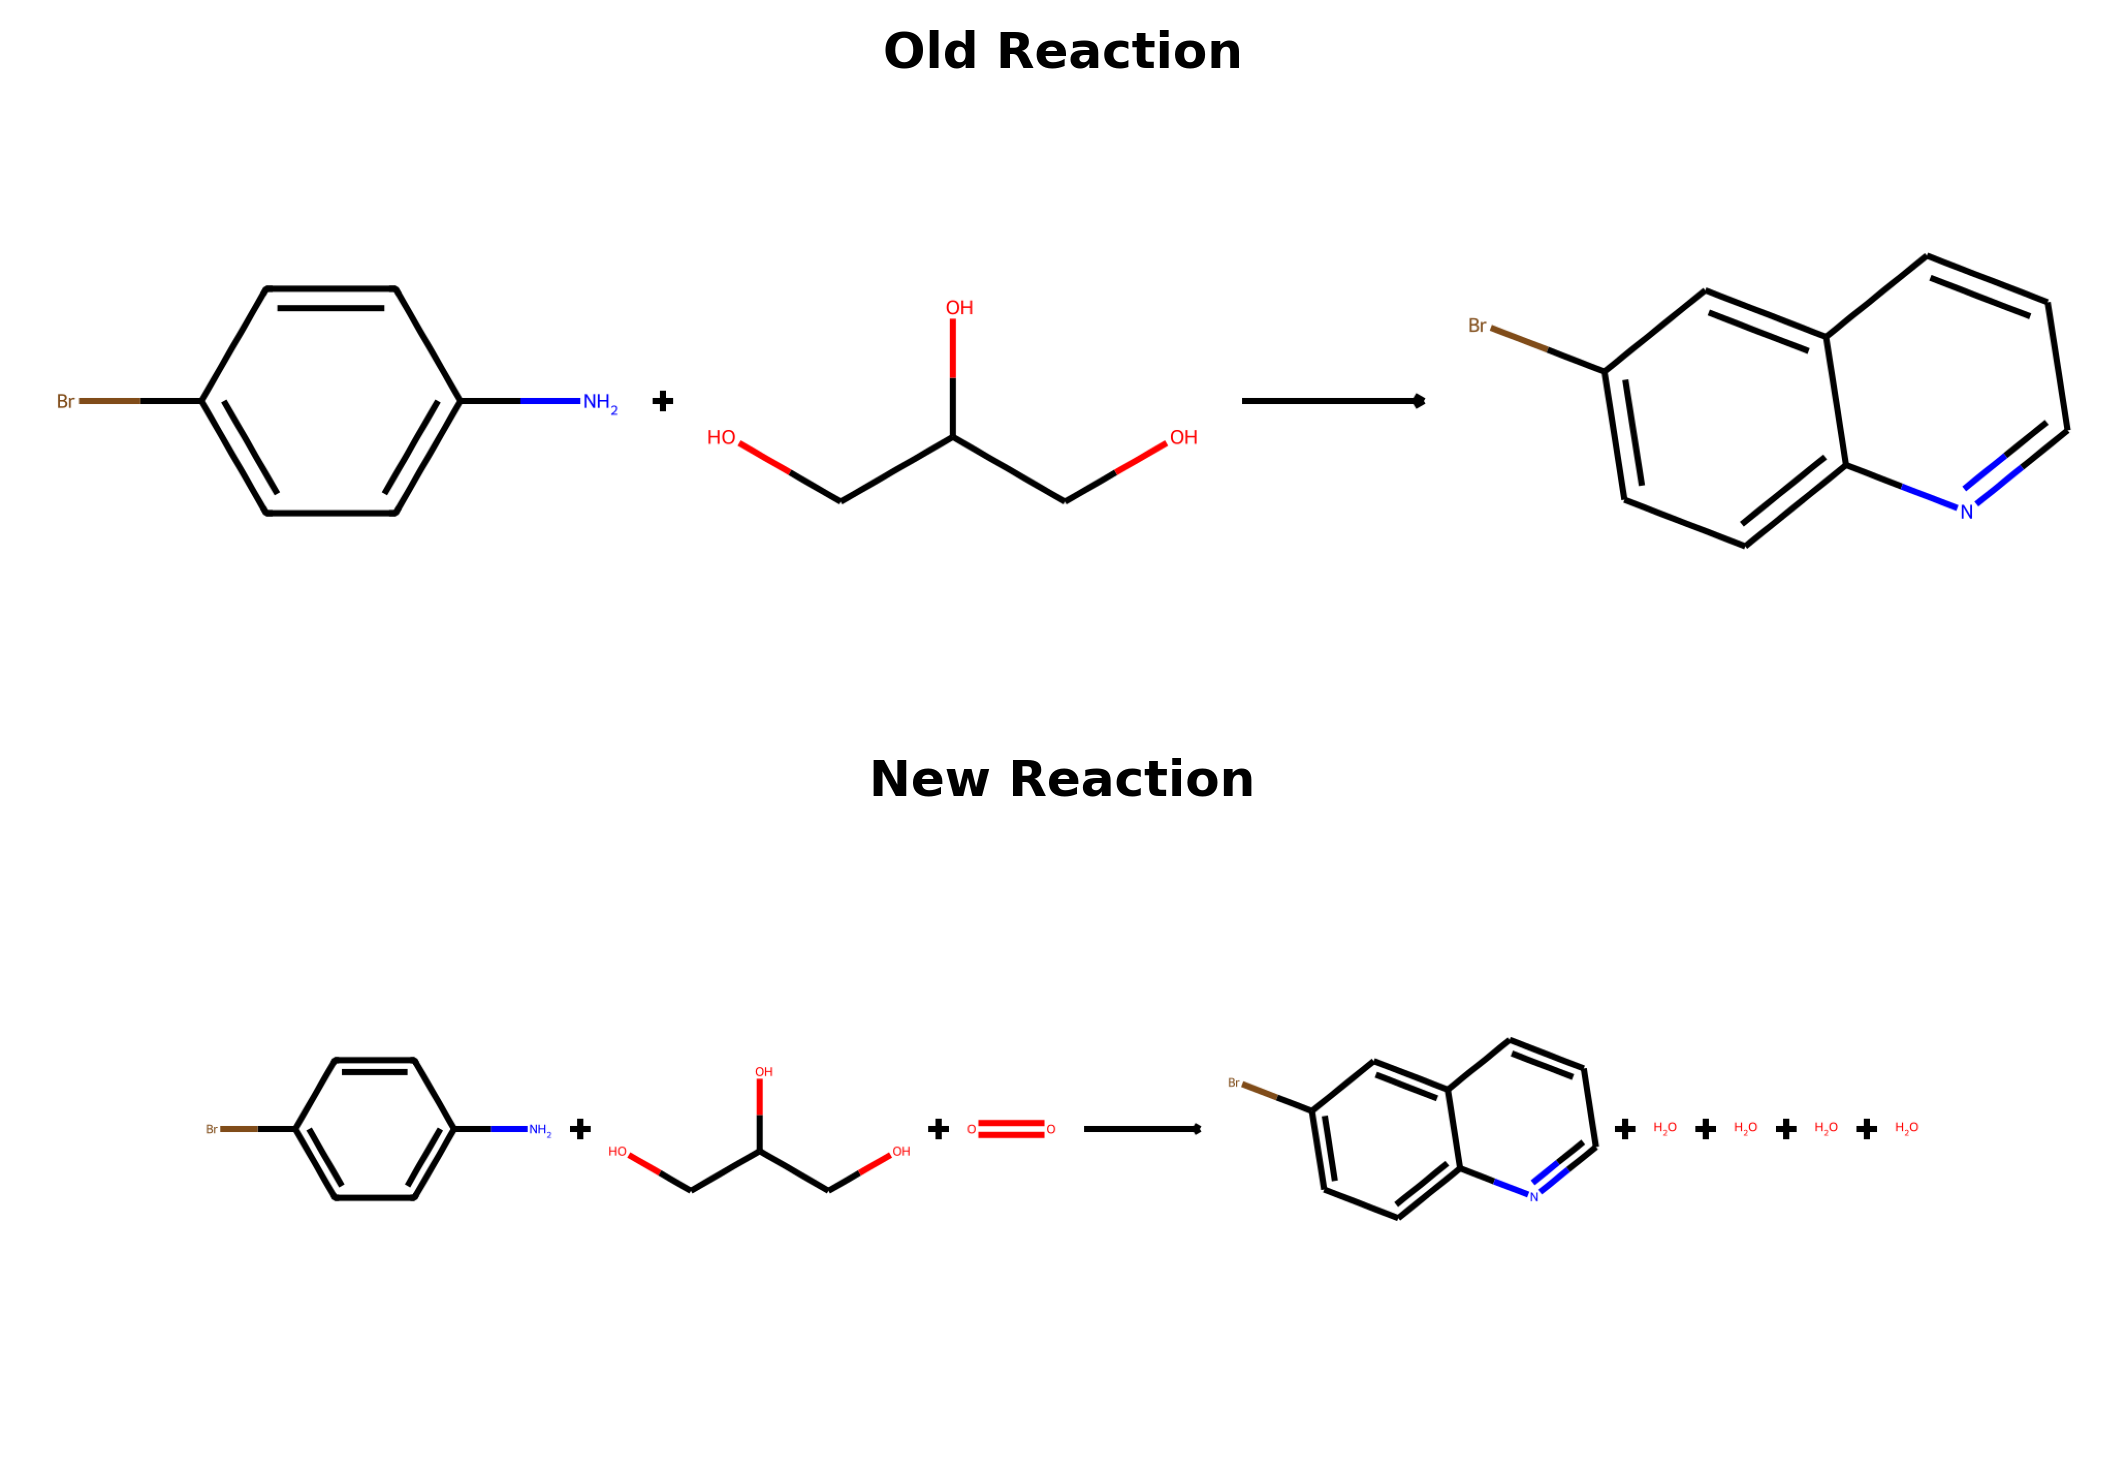

In [372]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(validate_samples[403], 'reactions', 'new_reaction', show_atom_numbers=False, compare= True, savefig=False, pathname = None, dpi=300)

In [93]:
validate_samples[78]

{'id': 'US20070225340A1',
 'class': 3,
 'reactions': 'CCOC(=O)c1cccc(B(O)O)c1.Cc1cccc(Br)c1I>>CCOC(=O)c1cccc(-c2c(C)cccc2Br)c1',
 'reactants': 'CCOC(=O)c1cccc(B(O)O)c1.Cc1cccc(Br)c1I',
 'products': 'CCOC(=O)c1cccc(-c2c(C)cccc2Br)c1.B(O)(O)I',
 'standardized_reactants': nan,
 'standardized_products': nan,
 'Unbalance': 'Products',
 'Diff_formula': {'O': 2, 'B': 1, 'I': 1, 'H': 2, 'Q': 0},
 'new_reaction': 'CCOC(=O)c1cccc(B(O)O)c1.Cc1cccc(Br)c1I>>CCOC(=O)c1cccc(-c2c(C)cccc2Br)c1.B(O)(O)I'}

In [98]:
def check_carboxyl(smi_comp):
    carboxyl_groups = ["OC(=O)"]
    for group in carboxyl_groups:
        if group in smi_comp:
            return True
    return False

In [99]:
check_carboxyl(validate_samples[78]['products'])

True

In [ ]:
check_carboxyl(smi_comp)

In [44]:
validate_samples[35]

{'id': 'US20110060146A1',
 'class': 7,
 'reactions': 'CCC(CC)(c1ccc(O)c(C)c1)c1ccc(C#CC2(O)CCCC2)c(C)c1>>CCC(CC)(c1ccc(O)c(C)c1)c1ccc(/C=C/C2(O)CCCC2)c(C)c1',
 'reactants': 'CCC(CC)(c1ccc(O)c(C)c1)c1ccc(C#CC2(O)CCCC2)c(C)c1.[HH]',
 'products': 'CCC(CC)(c1ccc(O)c(C)c1)c1ccc(/C=C/C2(O)CCCC2)c(C)c1',
 'standardized_reactants': nan,
 'standardized_products': nan,
 'Unbalance': 'Reactants',
 'Diff_formula': {'H': 2, 'Q': 0},
 'new_reaction': 'CCC(CC)(c1ccc(O)c(C)c1)c1ccc(C#CC2(O)CCCC2)c(C)c1.[HH]>>CCC(CC)(c1ccc(O)c(C)c1)c1ccc(/C=C/C2(O)CCCC2)c(C)c1'}

In [ ]:
for i in range()    

# **4. MCS Rebalancing**

## **4.1. Maximum common substructure**

In [32]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import sys
from pathlib import Path
from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.rsmi_utils import load_database, save_database
from rdkit import Chem
import logging


def single_mcs(data_dict, RingMatchesRingOnly=True, CompleteRingsOnly=True, Timeout=60,
               sort='MCS', remove_substructure=True):
    """
    Performs MCS on a single reaction data entry and captures any issues encountered.

    Parameters:
    - data_dict: Dict containing reaction data.
    - params: Optional parameters for MCS analysis.

    Returns:
    - dict: A dictionary containing MCS results and any sorted reactants encountered.
    """

    mcs_results_dict = {'mcs_results': [], 'sorted_reactants': [], 'issue': []}

    try:
        analyzer = MCSMissingGraphAnalyzer()
        mcs_list, sorted_reactants, _ = analyzer.fit(data_dict, RingMatchesRingOnly=RingMatchesRingOnly,
                                                     CompleteRingsOnly=CompleteRingsOnly, sort=sort,
                                                     remove_substructure=remove_substructure, Timeout=Timeout)
        mcs_list_smiles = [Chem.MolToSmiles(mol) for mol in mcs_list]
        sorted_reactants_smiles = [Chem.MolToSmiles(mol) for mol in sorted_reactants]
        mcs_results_dict['mcs_results'] = mcs_list_smiles
        mcs_results_dict['sorted_reactants'] = sorted_reactants_smiles

    except Exception as e:
        mcs_results_dict['issue'] = data_dict
        logging.error(f"Error in single_mcs: {str(e)}")

    return mcs_results_dict

unsolve = load_database('../../Data/Unsolved_reactions.json.gz')
mcs_results_dict = single_mcs(unsolve[0])
mcs_results_dict

{'mcs_results': ['COC(=O)C(CCCCN)NC(=O)NC1:C:C(OC):C:C(C(C)(C)C):C:1O'],
 'sorted_reactants': ['COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'],
 'issue': []}

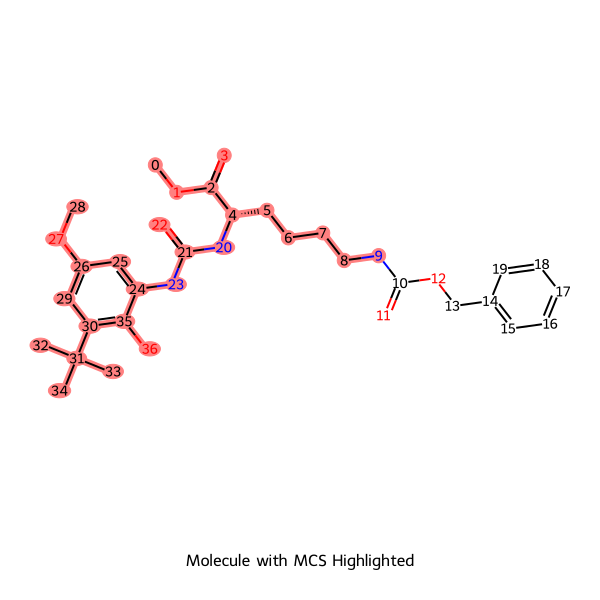

In [33]:
from SynRBL.SynVis.mcs_visualizer import  MCSVisualizer
mcs_vis = MCSVisualizer()
img= mcs_vis.highlight_molecule(mcs_results_dict['sorted_reactants'][0], mcs_results_dict['mcs_results'][0], show_atom_numbers=True, compare=False, missing_graph_smiles=None)
img

## **4.2. Find Graph**

Reactants
Neighbor Atom: [[{'N': 9}]]
Missing compounds in Products
Boundary Atom: [[{'C': 1}]]


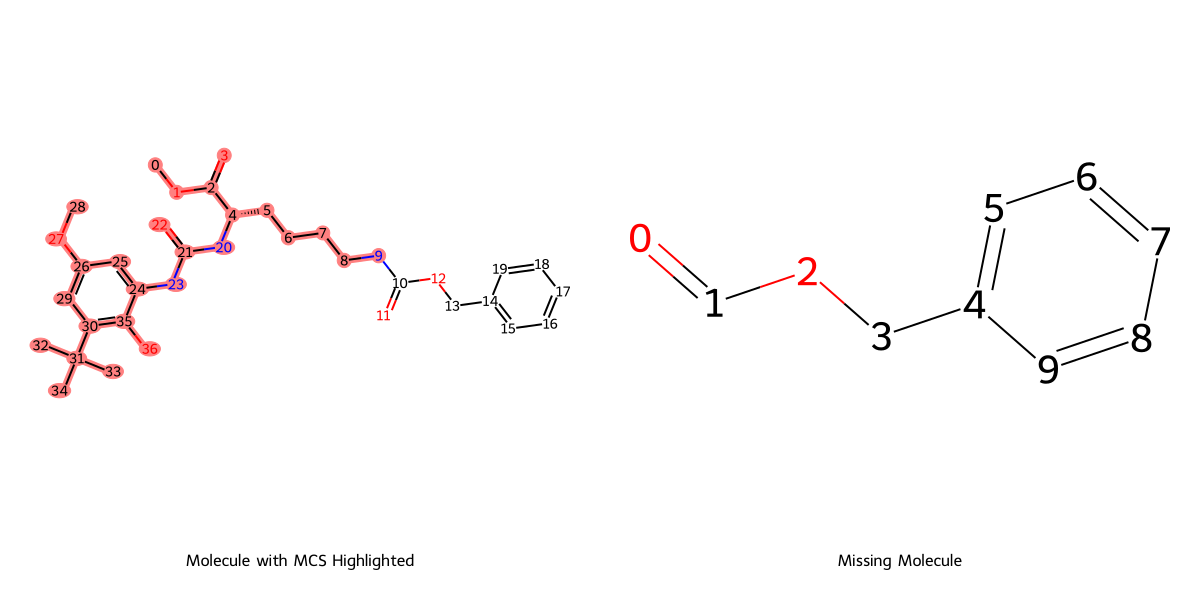

In [44]:
from SynRBL.SynMCS import FindMissingGraphs
from SynRBL.SynVis.mcs_visualizer import  MCSVisualizer
mol_list = [Chem.MolFromSmiles(i) for i in mcs_results_dict['sorted_reactants']]
mcs_list = [Chem.MolFromSmiles(i) for i in mcs_results_dict['mcs_results']]

find_graph = FindMissingGraphs()
missing_graph, boundary, neighbor = find_graph.find_missing_parts_pairs(mol_list=mol_list, mcs_list=mcs_list,use_findMCS=True)




print('Reactants')
print('Neighbor Atom:', neighbor)
print('Missing compounds in Products')
print('Boundary Atom:', boundary)

mcs_vis = MCSVisualizer()
img= mcs_vis.highlight_molecule(mcs_results_dict['sorted_reactants'][0], mcs_results_dict['mcs_results'][0], show_atom_numbers=True, compare=True, missing_graph_smiles=Chem.MolToSmiles(missing_graph[0]))
img


## **4.3. Mol Merge**

## **4.4. Check and Re-Impute by Rule based method**

In [287]:
def check_for_bug(dataframe):
    ind_key = []
    for key, value in enumerate(dataframe['boundary_atoms_products']):
        if len(value) == 0:
            ind_key.append(key)

    bug_rows = dataframe.iloc[ind_key, :]
    return bug_rows

In [289]:
check = load_database('../../Data/MCS/Final_Graph_macth_under2-.json.gz')
check_df = pd.DataFrame(check)

In [290]:
check_for_bug(check_df)

smiles boundary_atoms_products nearest_neighbor_products  \
7        []                      []                        []   
38       []                      []                        []   
72       []                      []                        []   
82       []                      []                        []   
84       []                      []                        []   
...     ...                     ...                       ...   
1215     []                      []                        []   
1217     []                      []                        []   
1220     []                      []                        []   
1221     []                      []                        []   
1222     []                      []                        []   

                                                  issue  
7     Python argument types in\n    RWMol.__init__(R...  
38    Python argument types in\n    RWMol.__init__(R...  
72    Python argument types in\n    RWMol.__init__(R...  
82    Python argument types in\n    RWMol.__init__(R...  
84    Python argument types in\n    RWMol.__init__(R...  
...                                                 ...  
1215                                                     
1217                                                     
1220                                                     
1221                                                     
1222                                                     

[159 rows x 4 columns]

In [34]:
17459-17328

131

In [283]:
after_mcs_2 = load_database('../../Data/MCS/After_Merge_and_Expansion_0-50.json.gz')
pd.DataFrame(after_mcs_2).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1223 non-null   object
 1   old_reaction    1223 non-null   object
 2   new_reaction    1103 non-null   object
 3   merge_rules     1103 non-null   object
 4   compound_rules  1103 non-null   object
dtypes: object(5)
memory usage: 47.9+ KB


In [36]:
after_mcs_3 = load_database('../../Data/MCS/After_Merge_and_Expansion_3+.json.gz')
valid_mcs_3  = get_random_samples_by_key(after_mcs_3, num_samples_per_group=50, random_seed=42, stratify_key= 'compound_rules')
print(len(valid_mcs_3))
pd.DataFrame(after_mcs_3).describe()

469


id                               old_reaction  \
count             17459                                      17459   
unique            10715                                      17327   
top     US20070249670A1  O=[N+]([O-])c1cc(Br)ccc1O>>Nc1cc(Br)ccc1O   
freq                 42                                          3   

                                             new_reaction  \
count                                               17326   
unique                                              17196   
top     CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.OCC1CCNCC1>>CC(C...   
freq                                                    3   

                  merge_rules                  compound_rules  \
count                   17326                           17326   
unique                      3                              12   
top     [default single bond]  [append O when next to O or N]   
freq                     8642                            7954   

                                                    issue  
count                                                 133  
unique                                                  3  
top     [Failed to apply merge rule 'default single bo...  
freq                                                   98

In [47]:
pd.DataFrame(after_mcs_3)['merge_rules']

0        [default single bond]
1                           []
2        [default single bond]
3        [default single bond]
4        [default single bond]
                 ...          
17454                       []
17455                       []
17456                       []
17457                       []
17458                       []
Name: merge_rules, Length: 17459, dtype: object

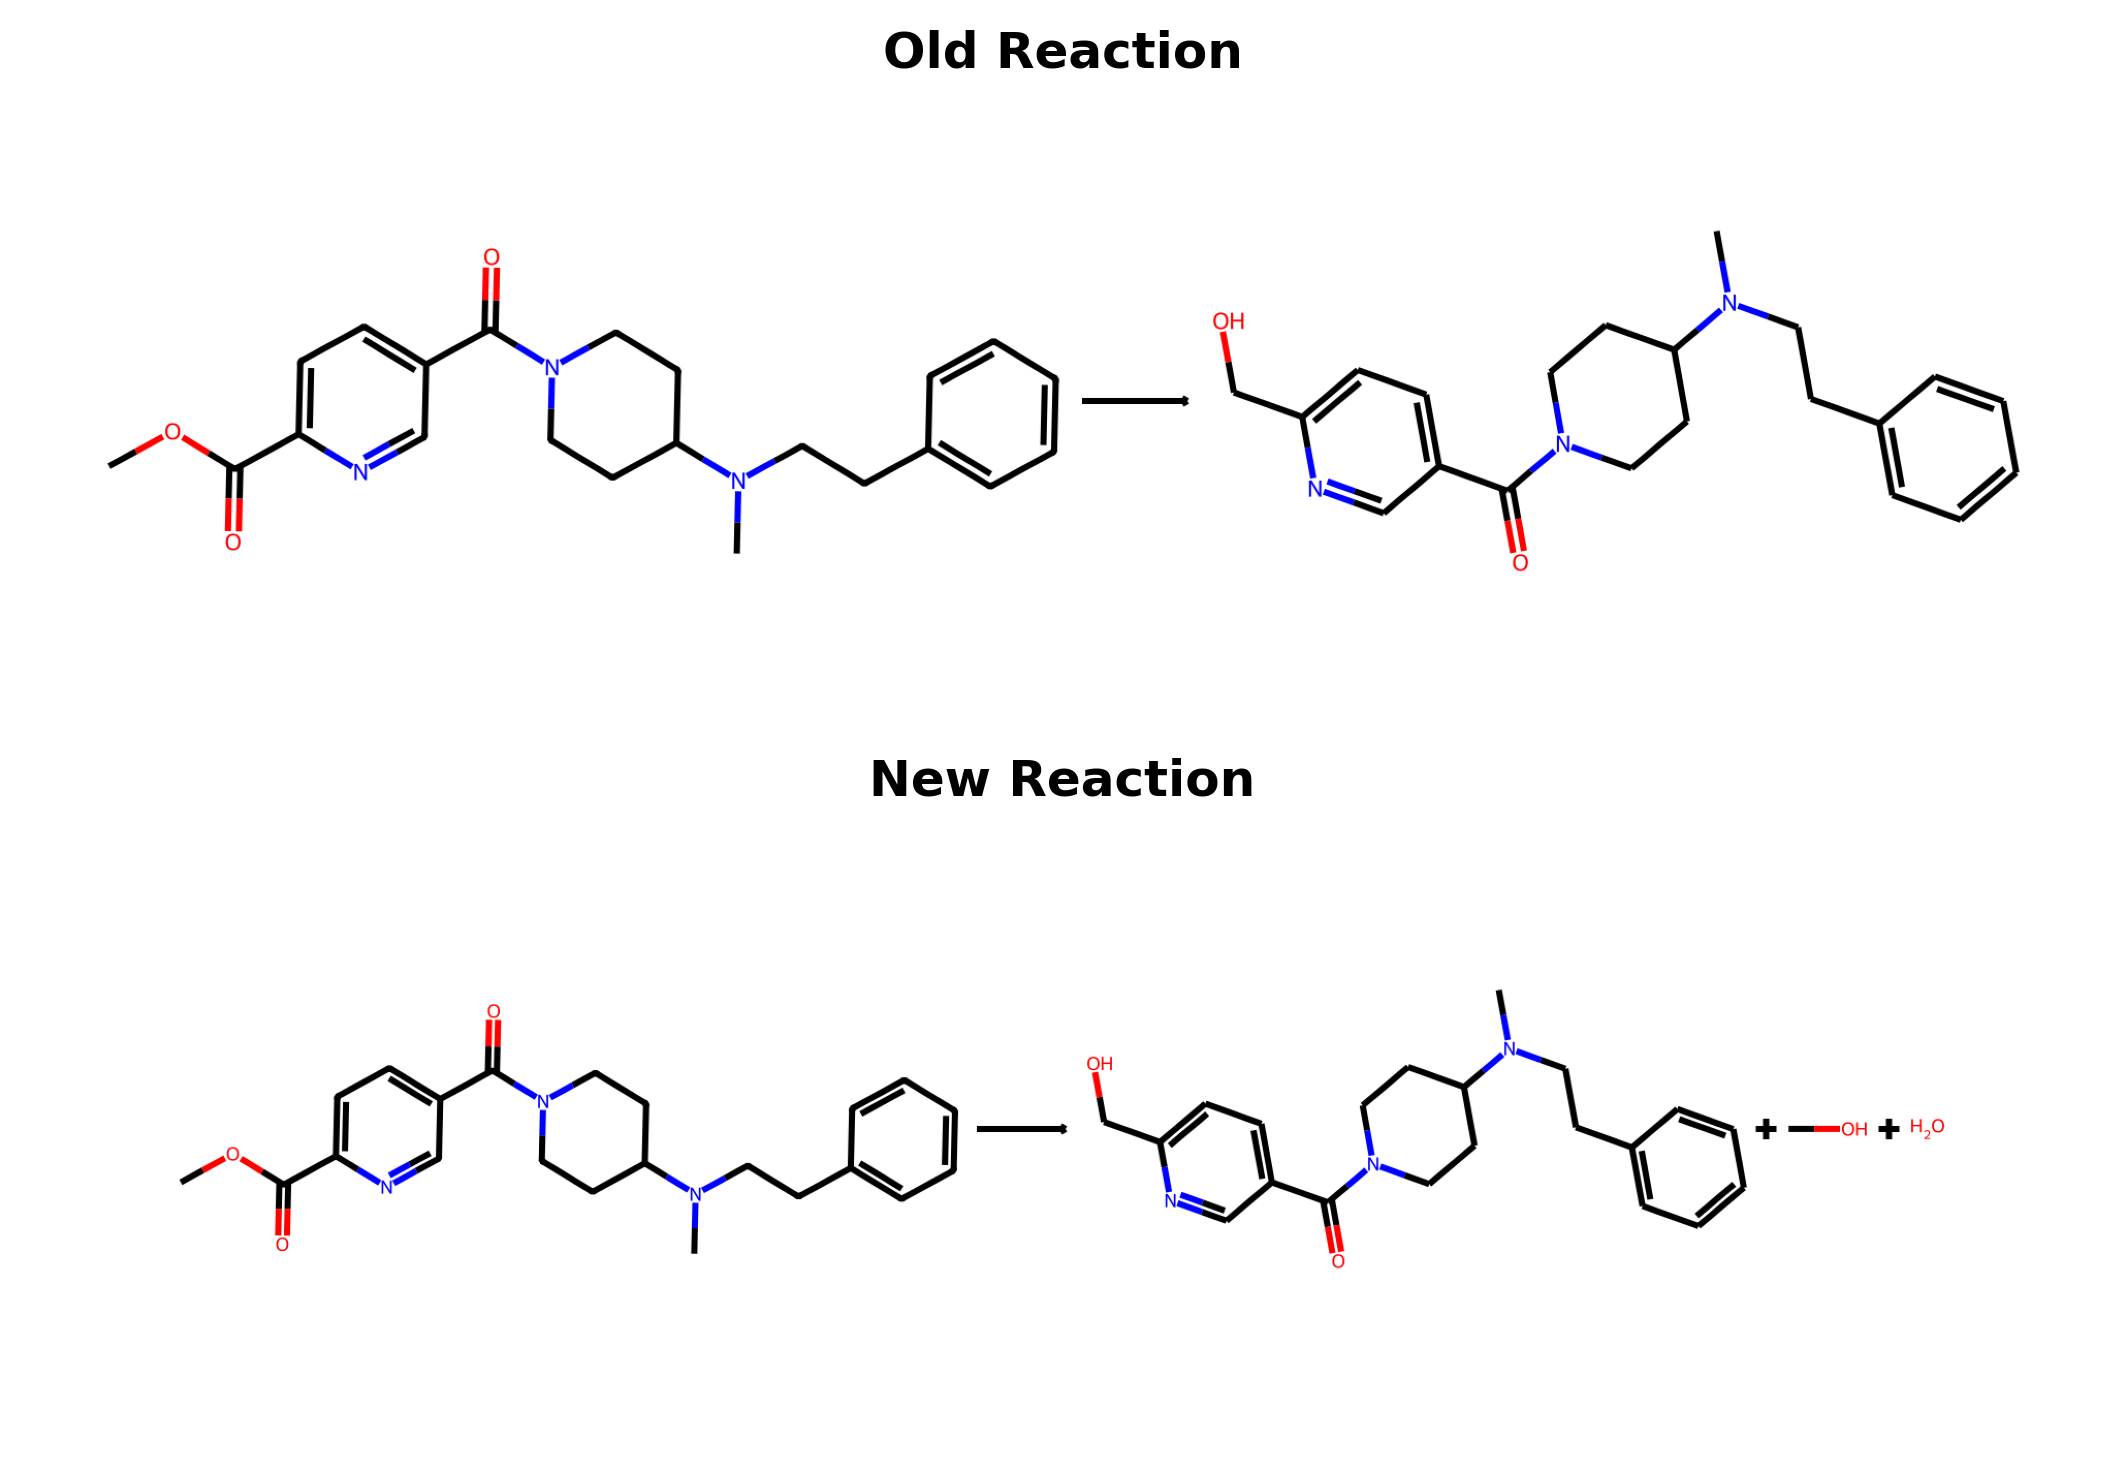

In [303]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(valid_mcs_3[245], 'old_reaction', 'new_reaction', show_atom_numbers=False, compare= True, savefig=False, pathname = None, dpi=300)

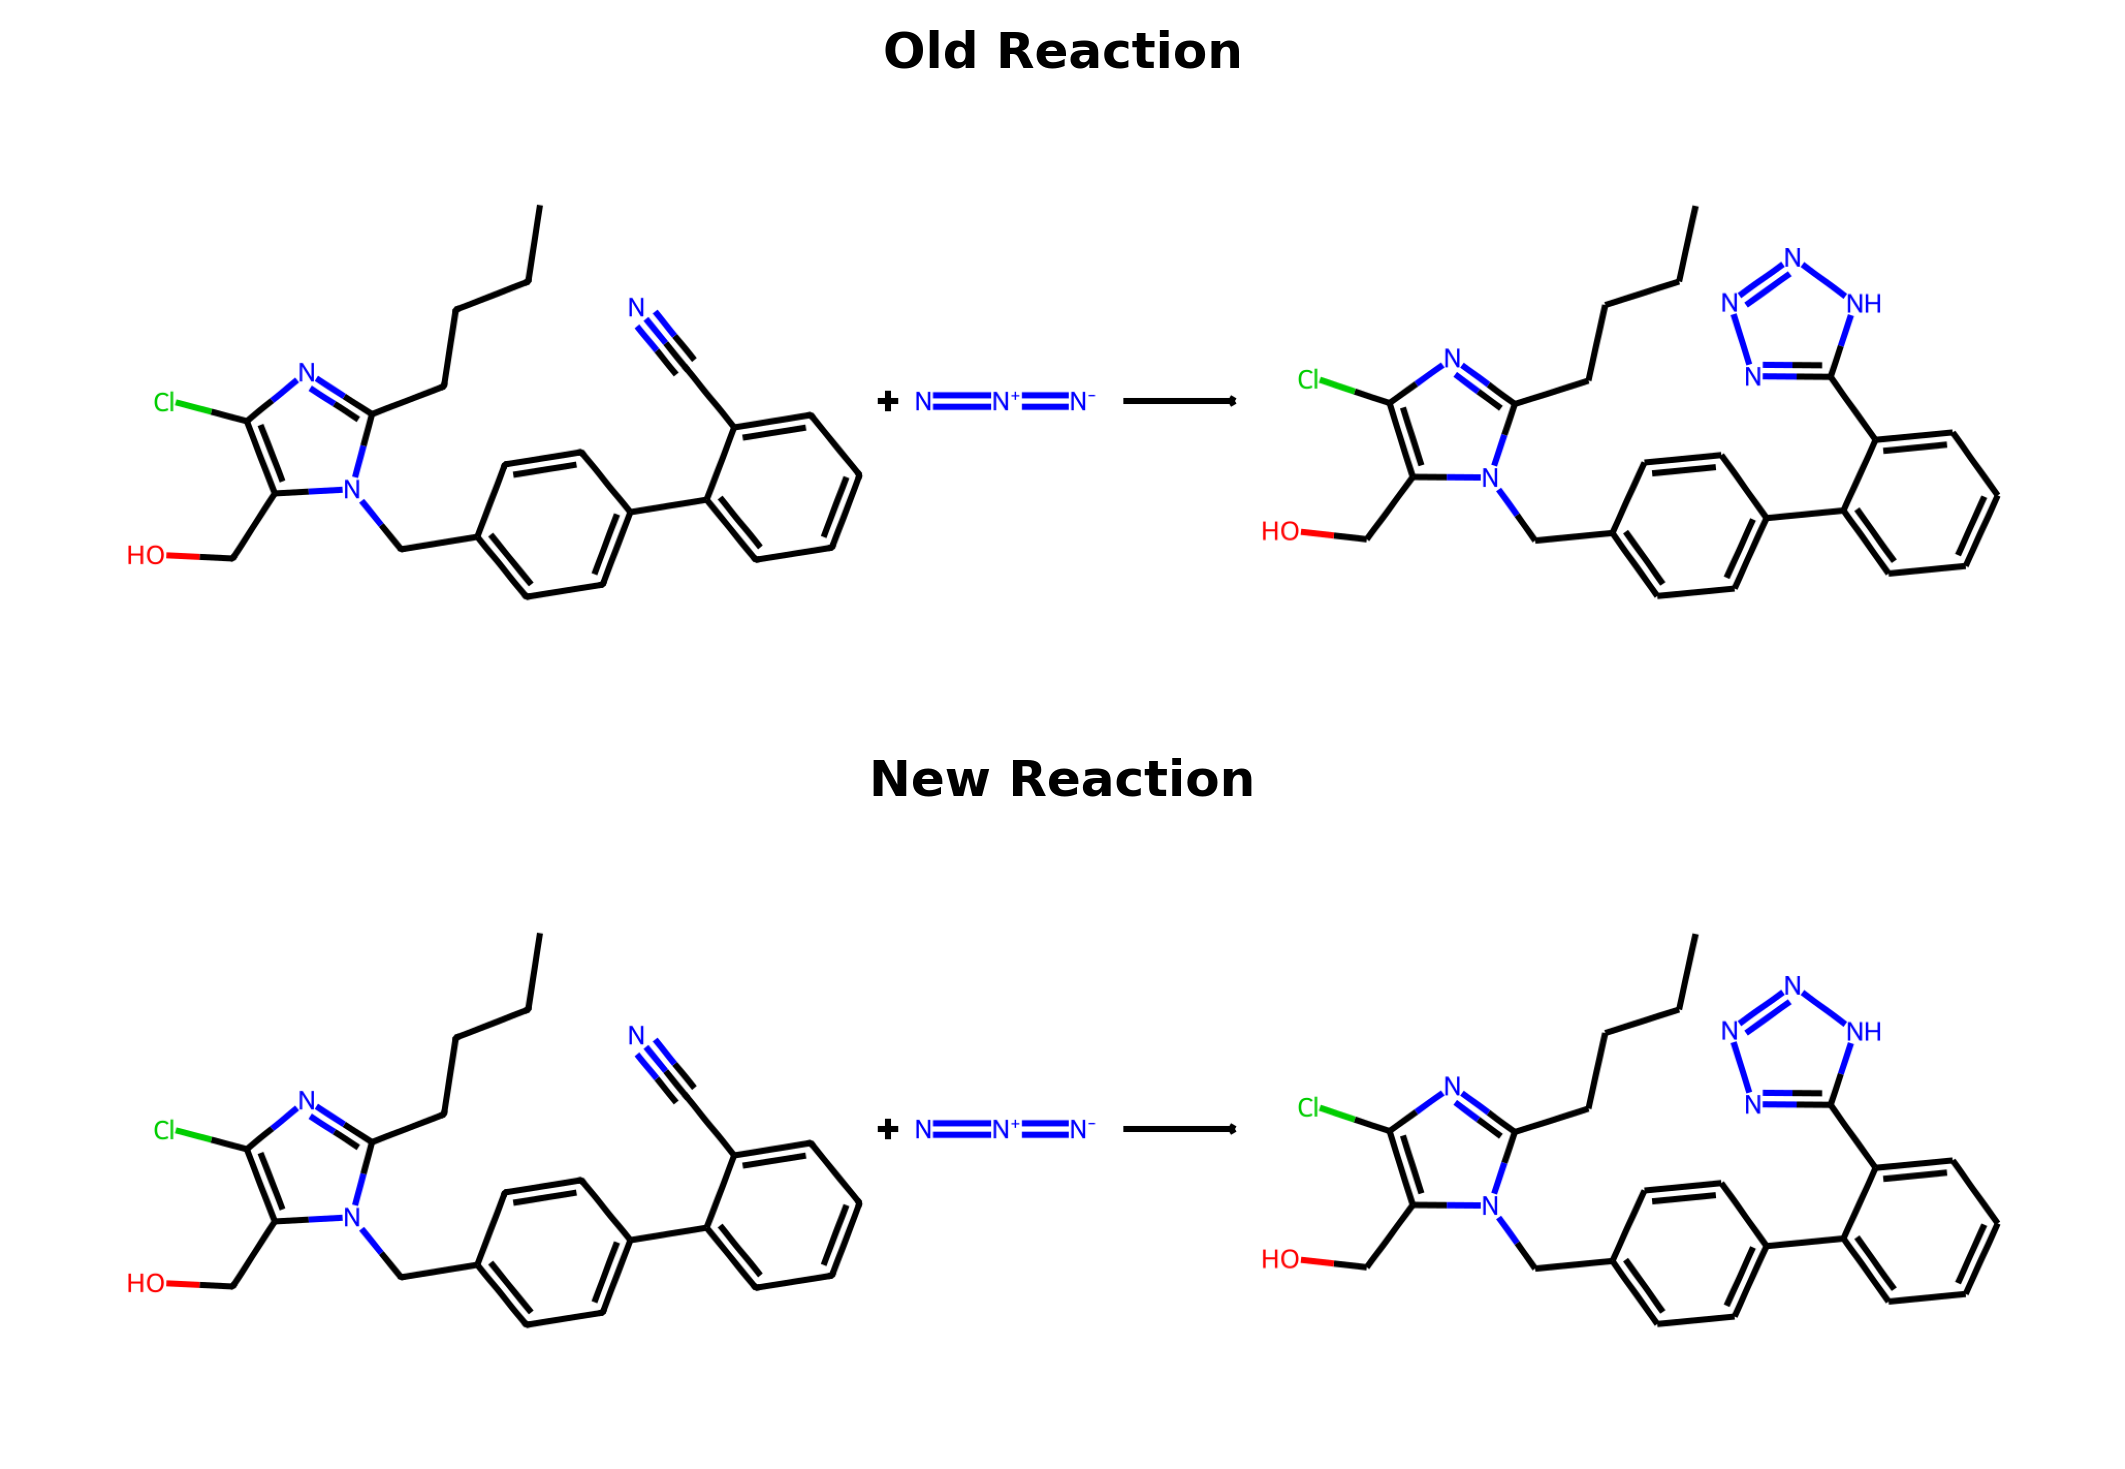

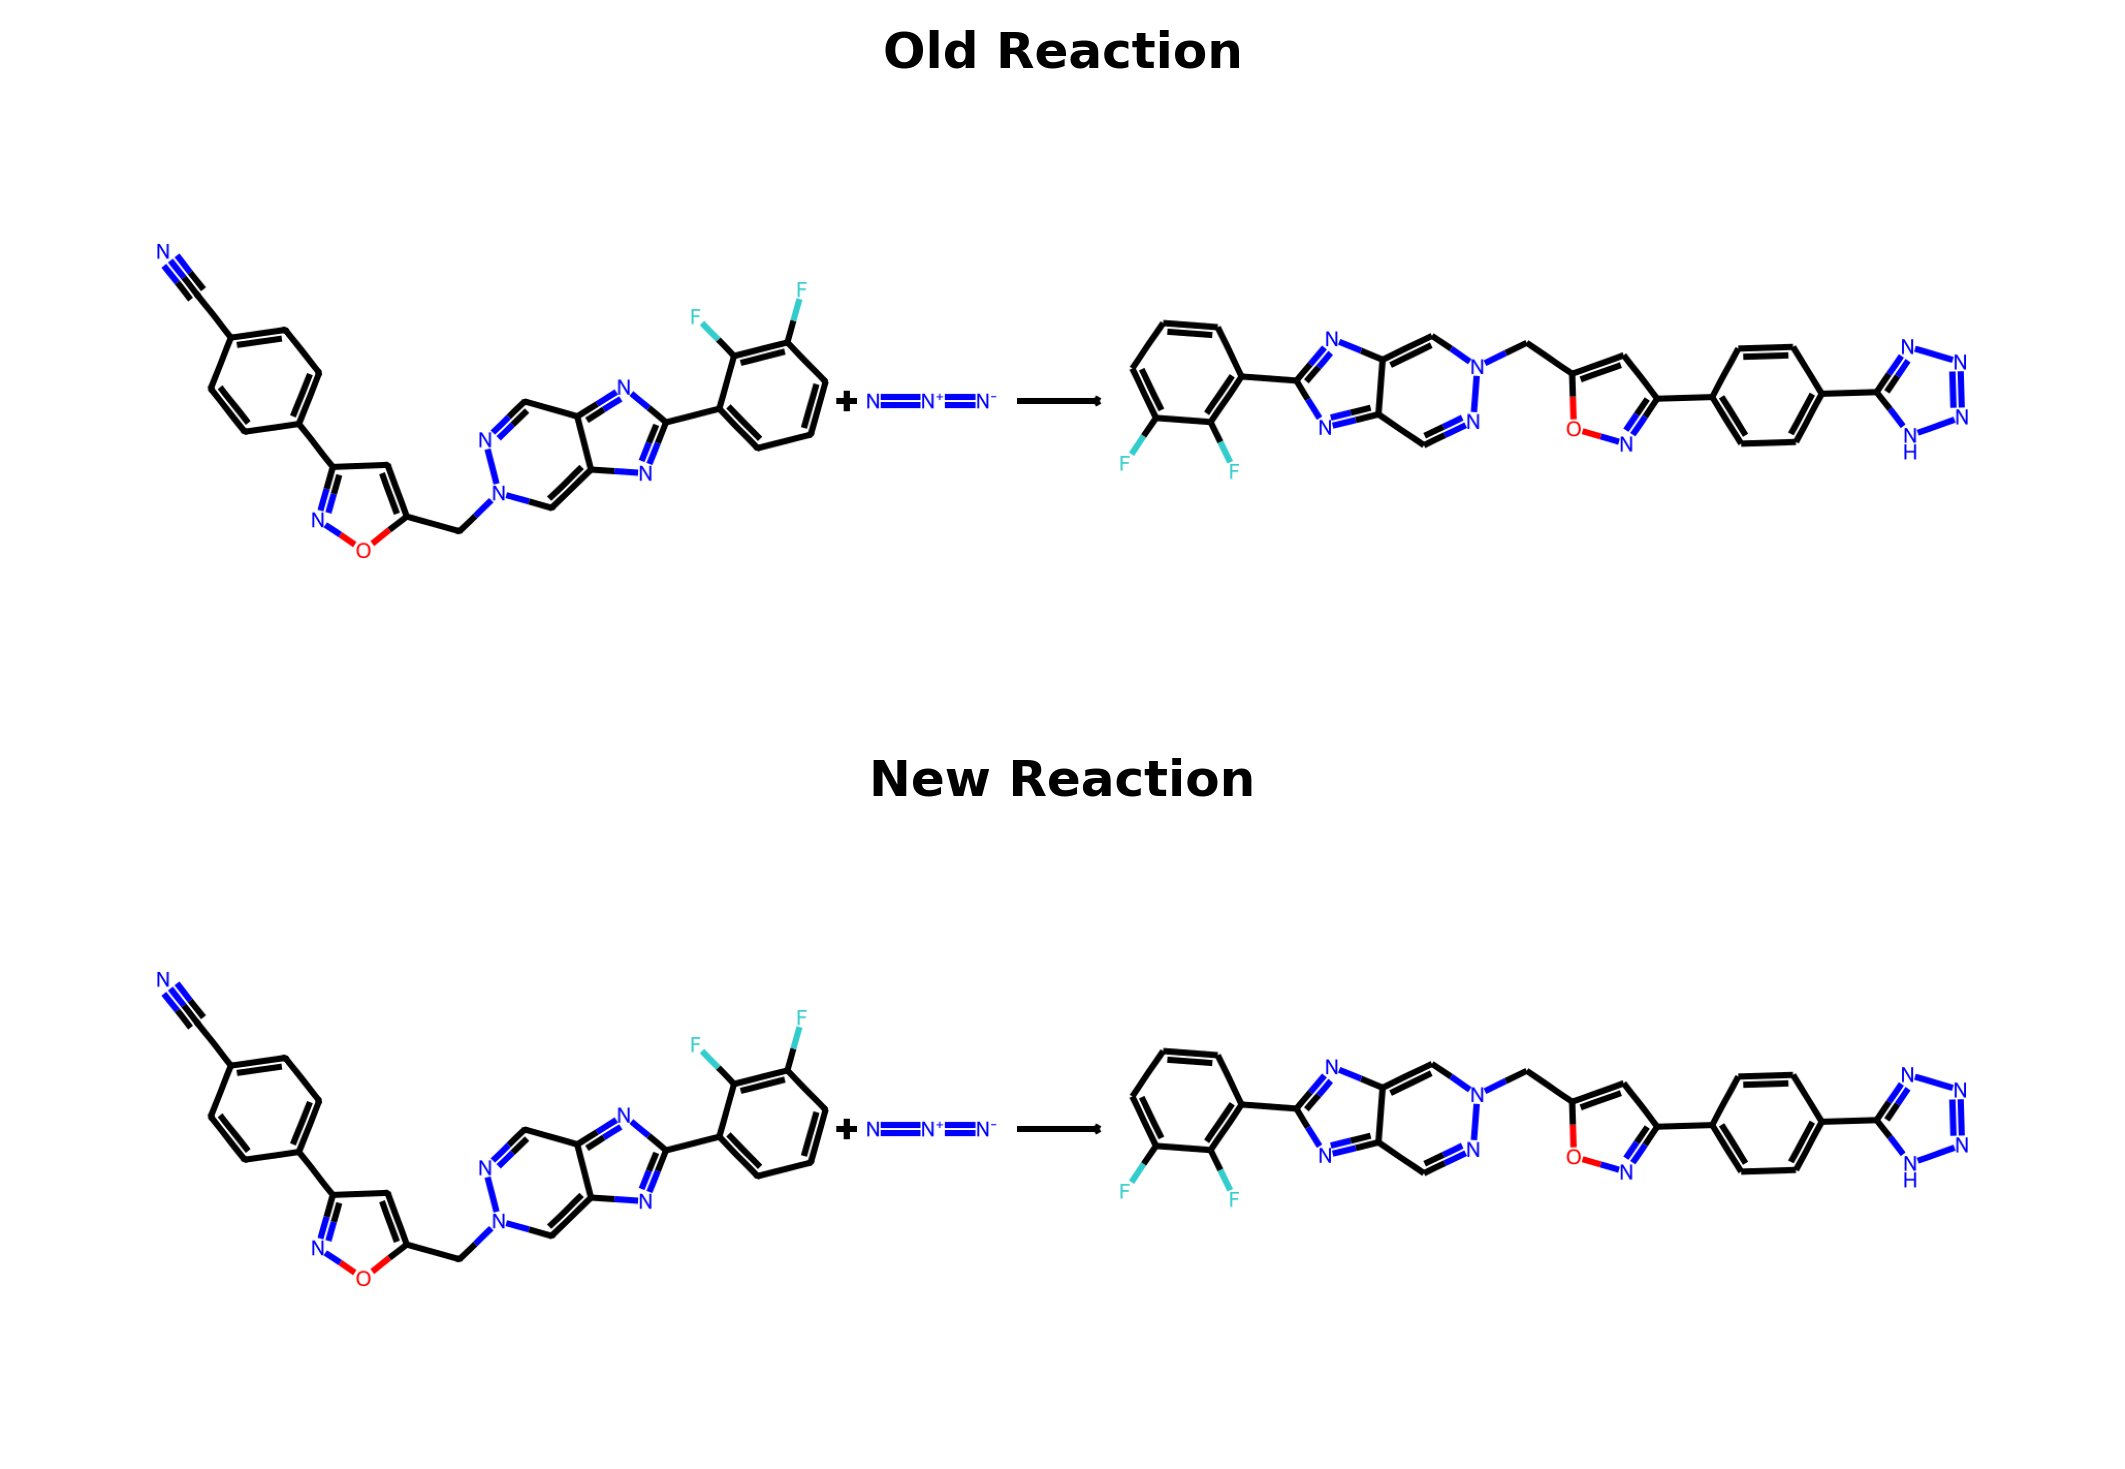

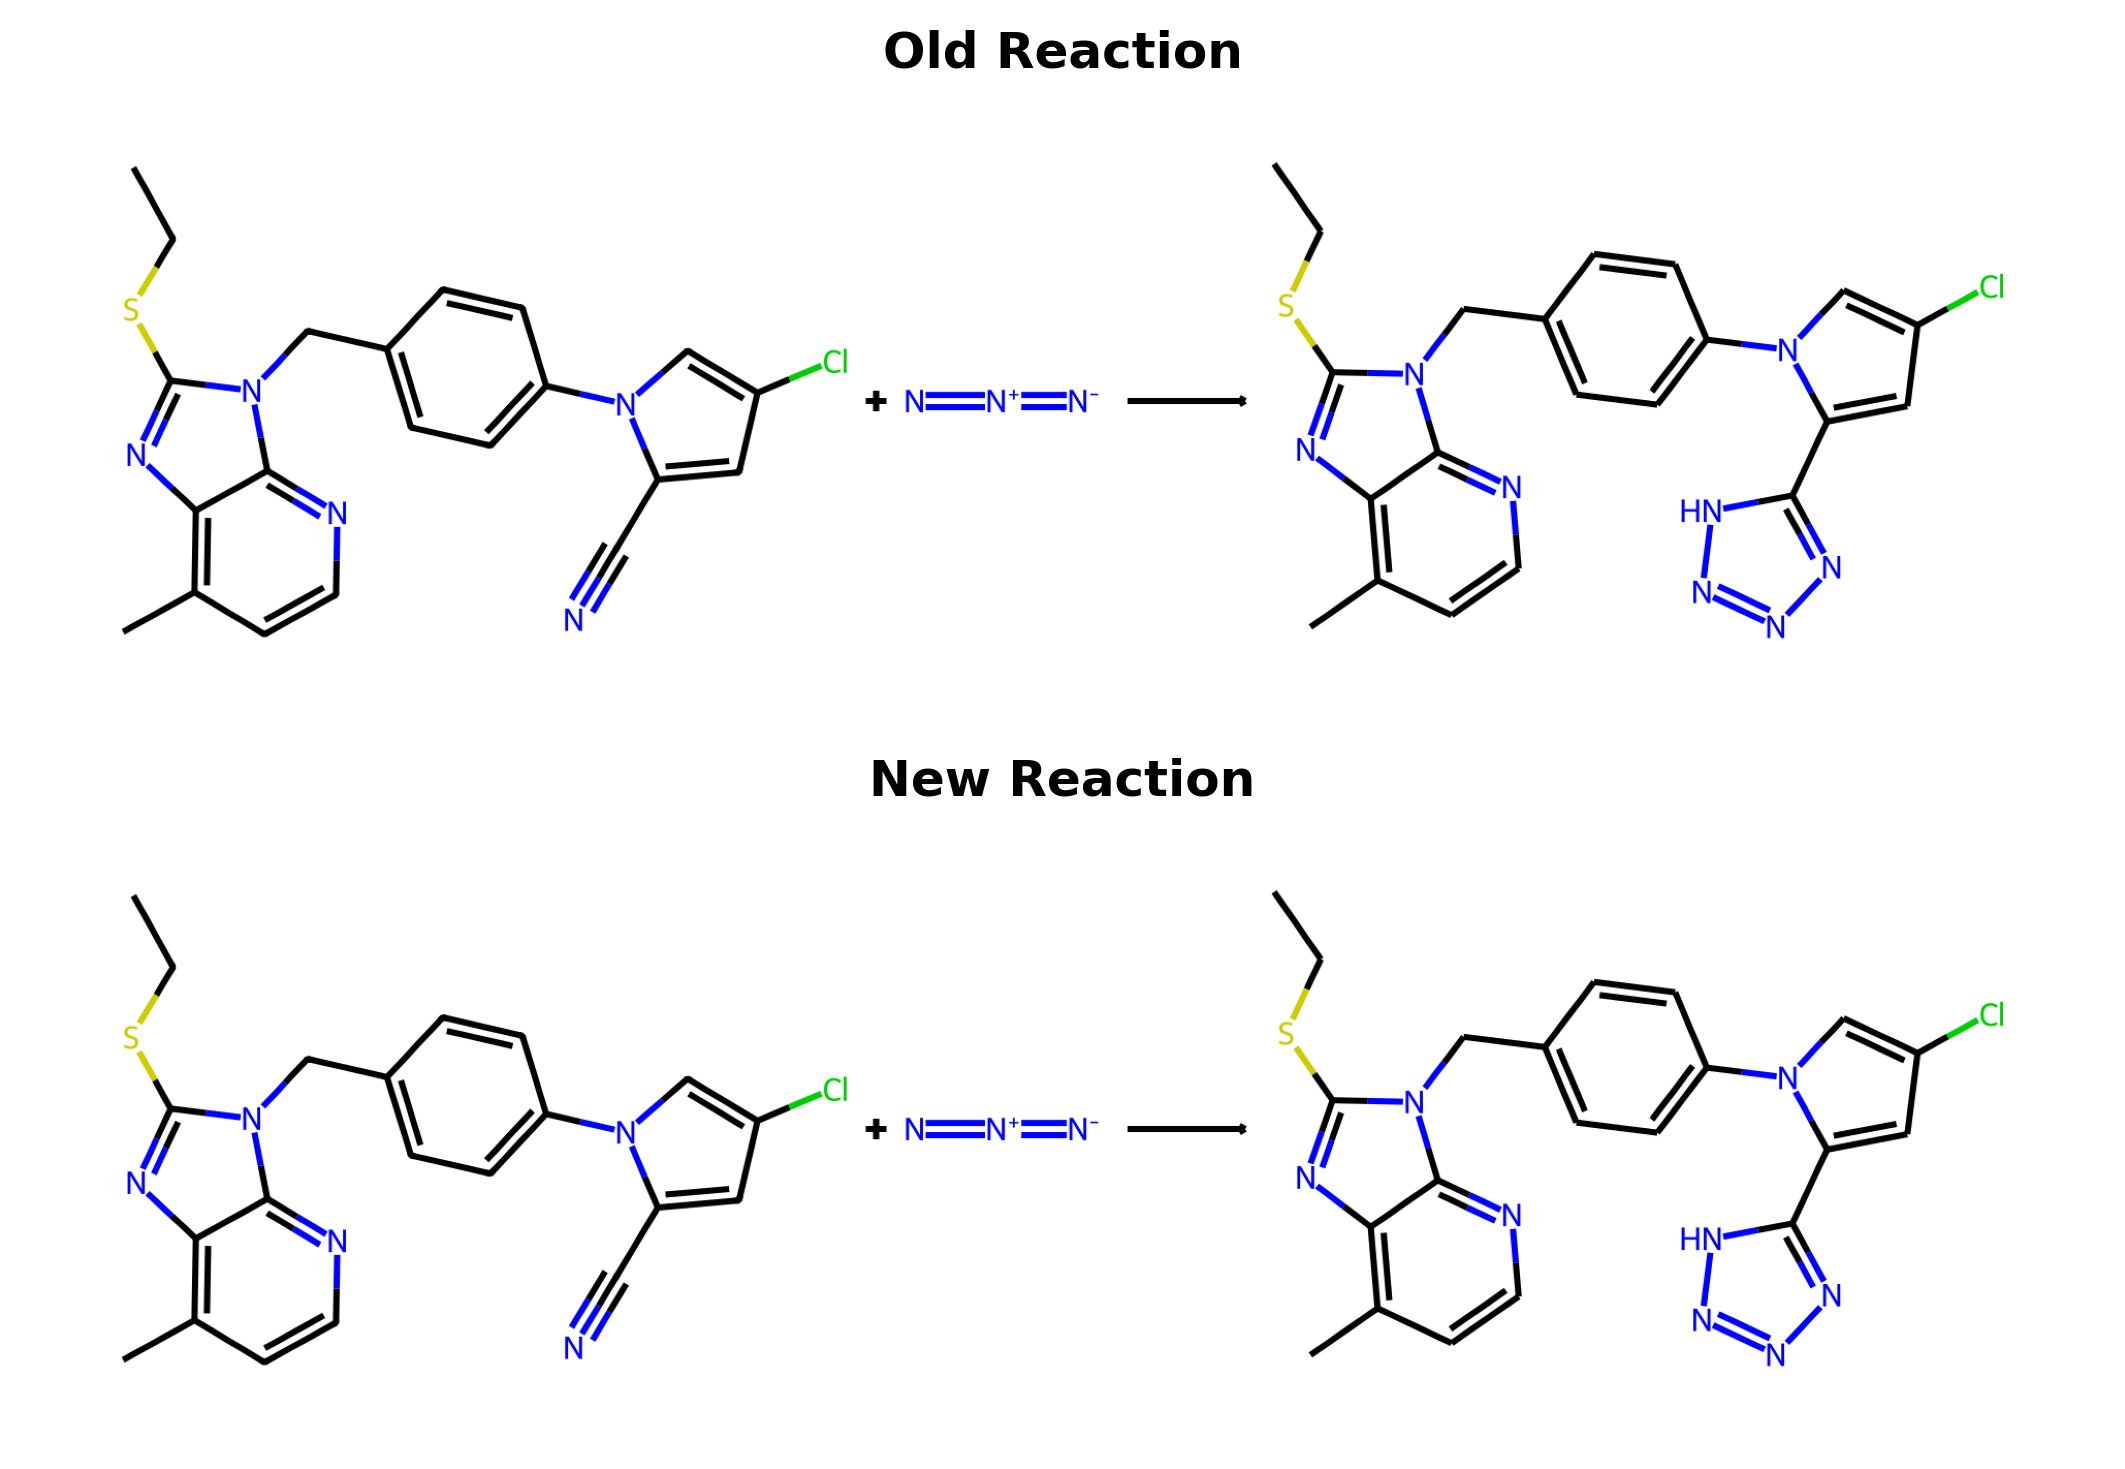

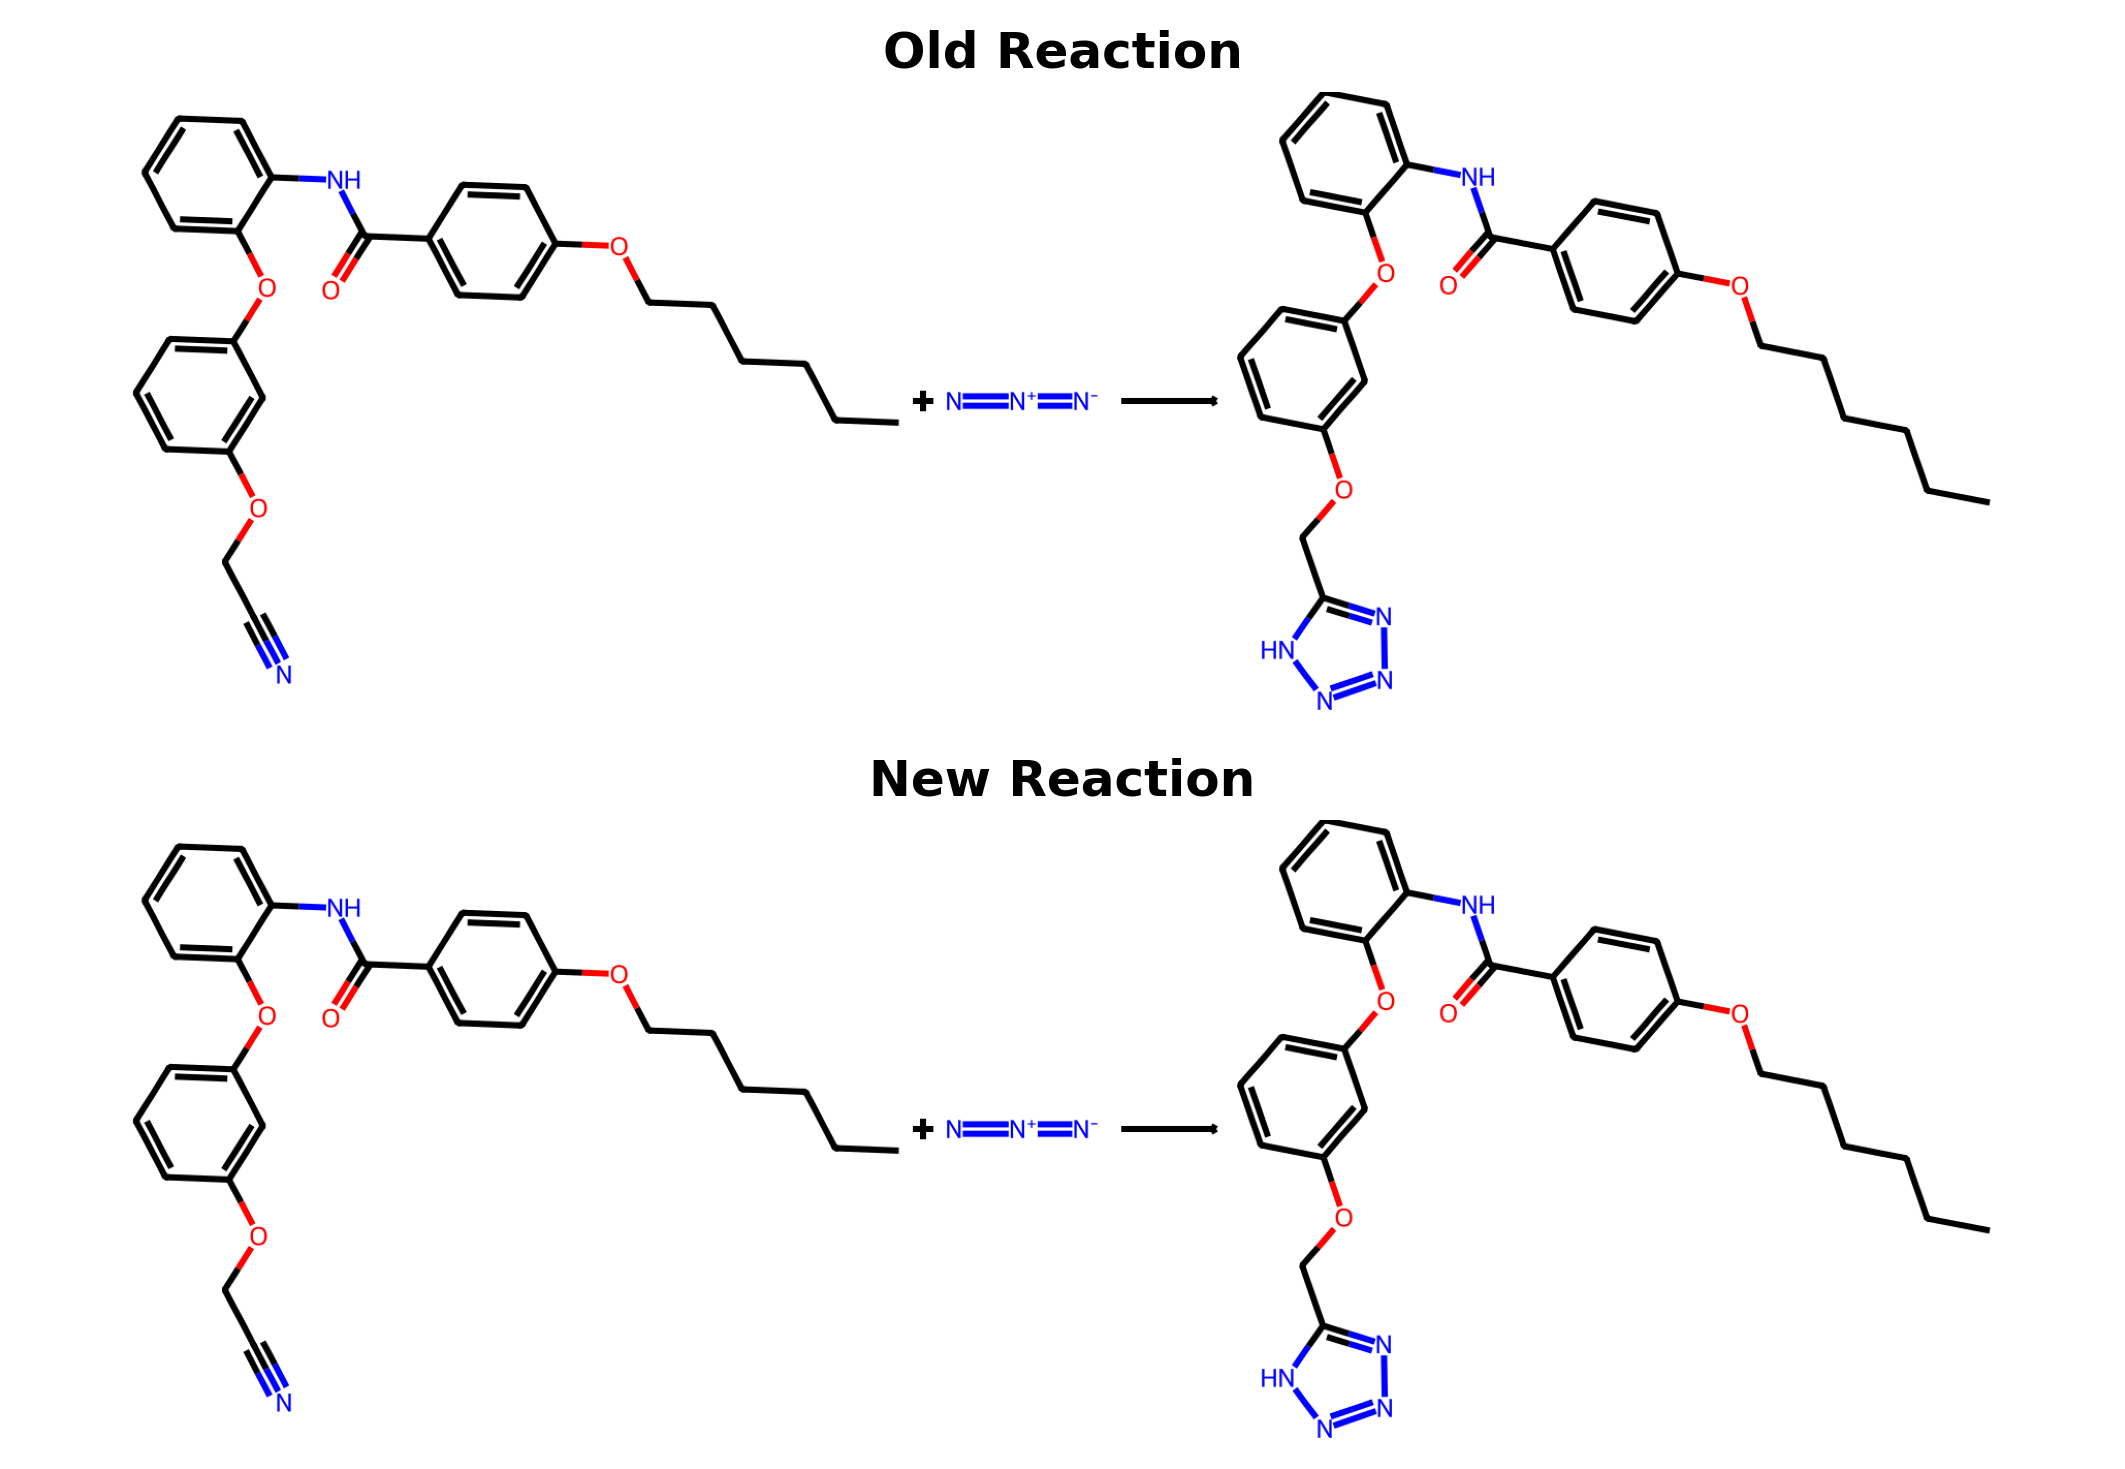

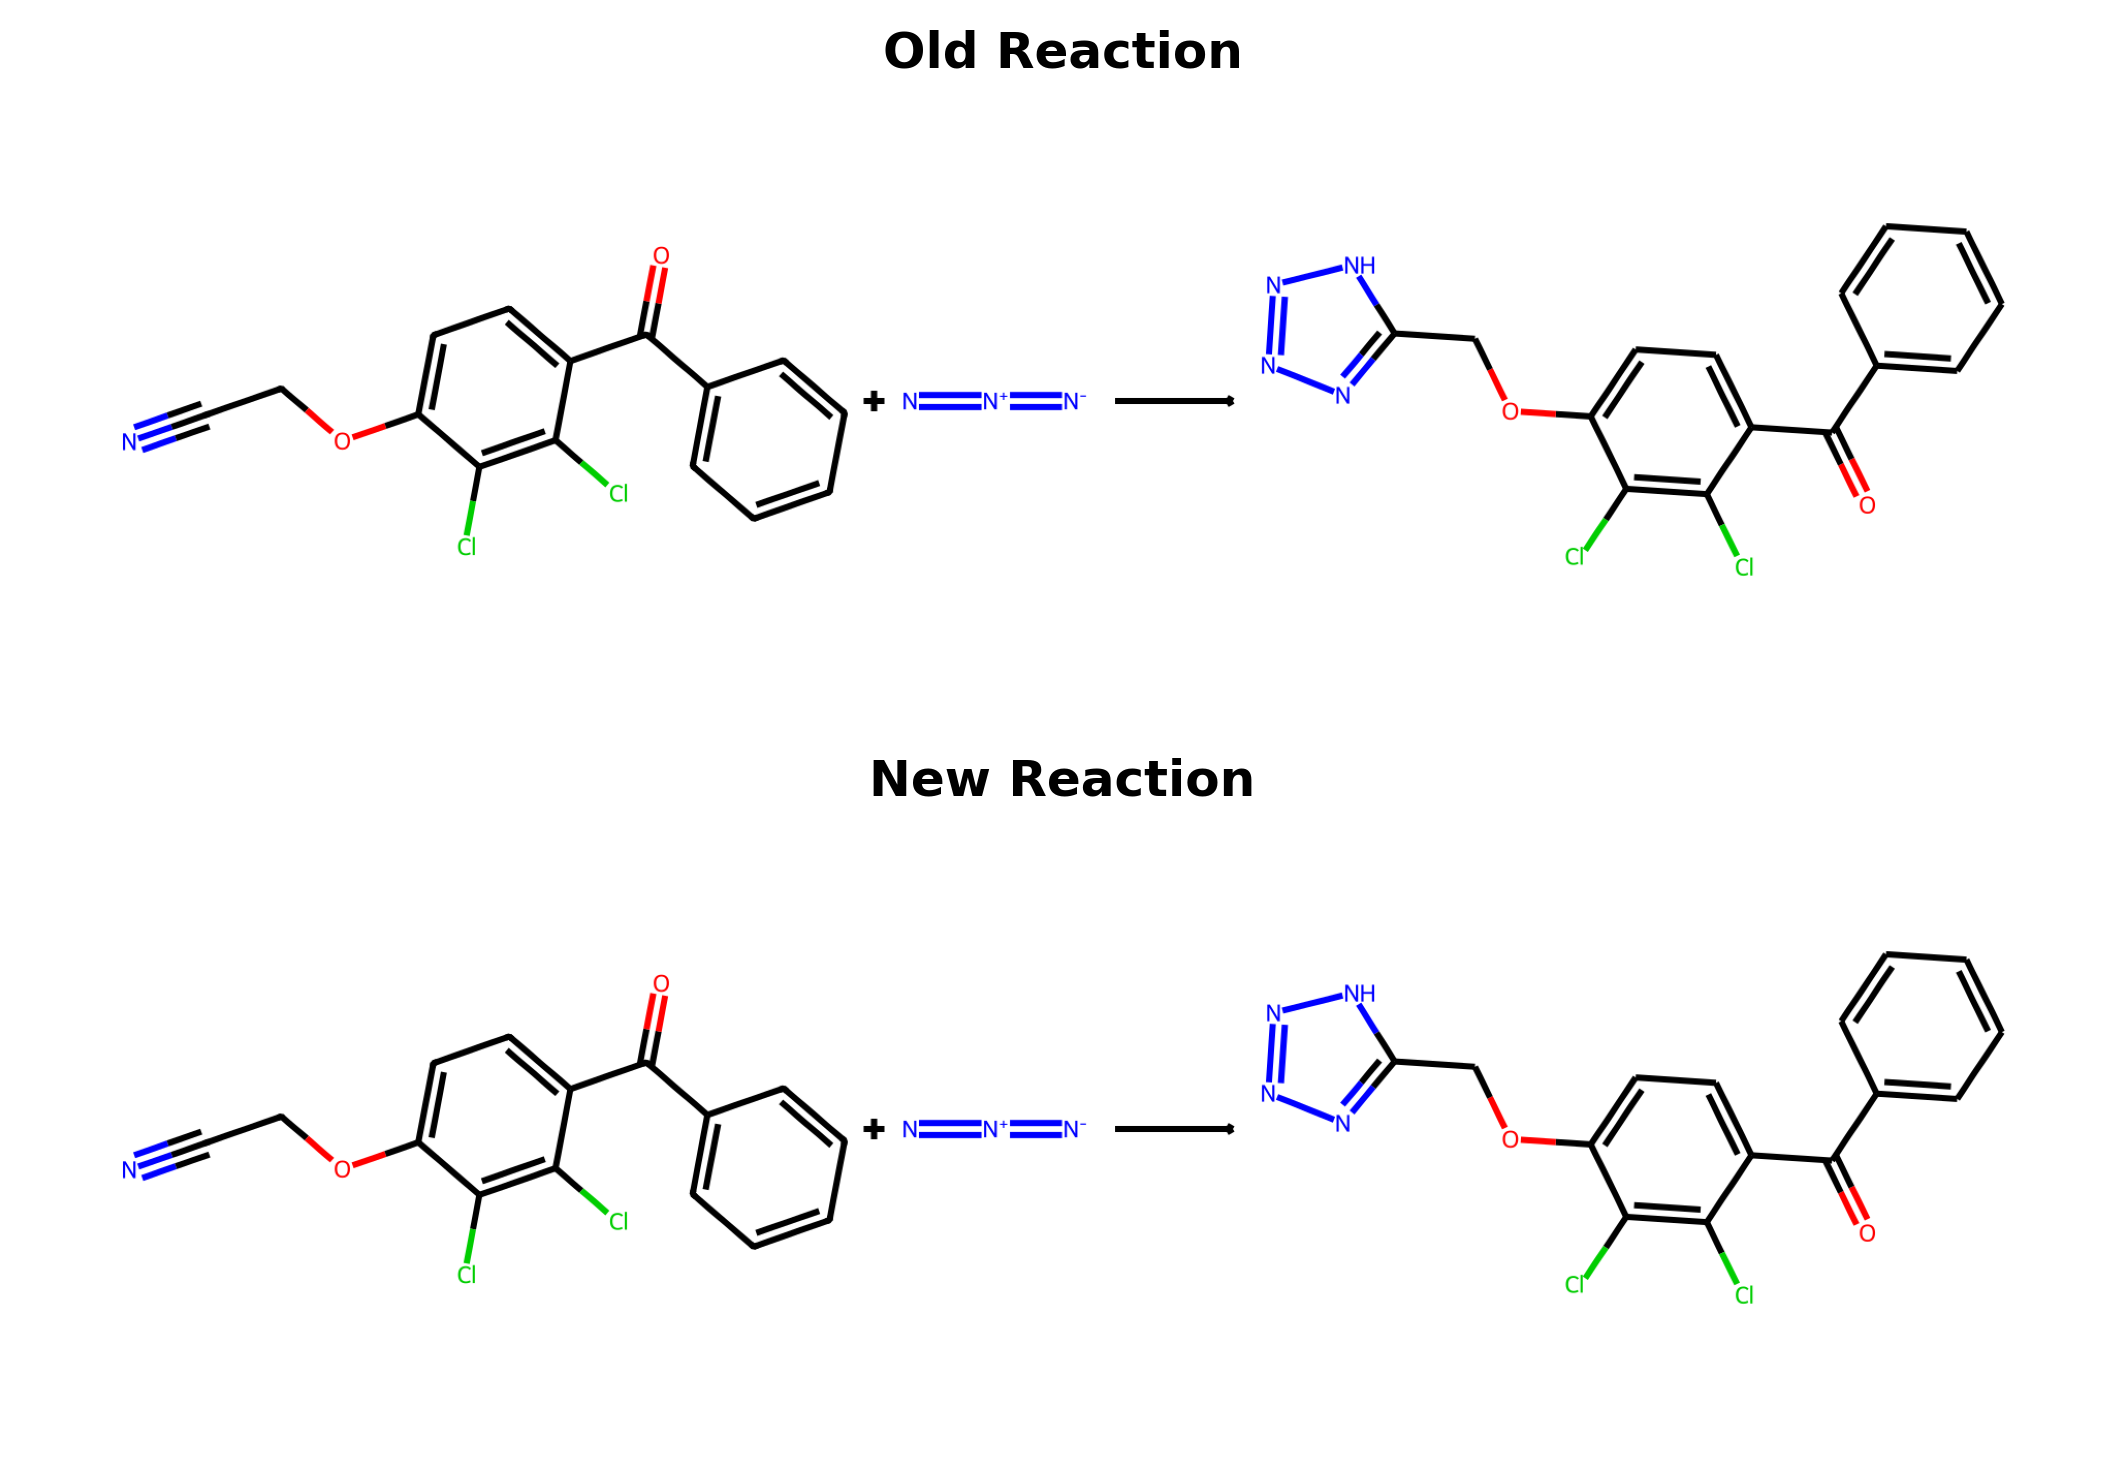

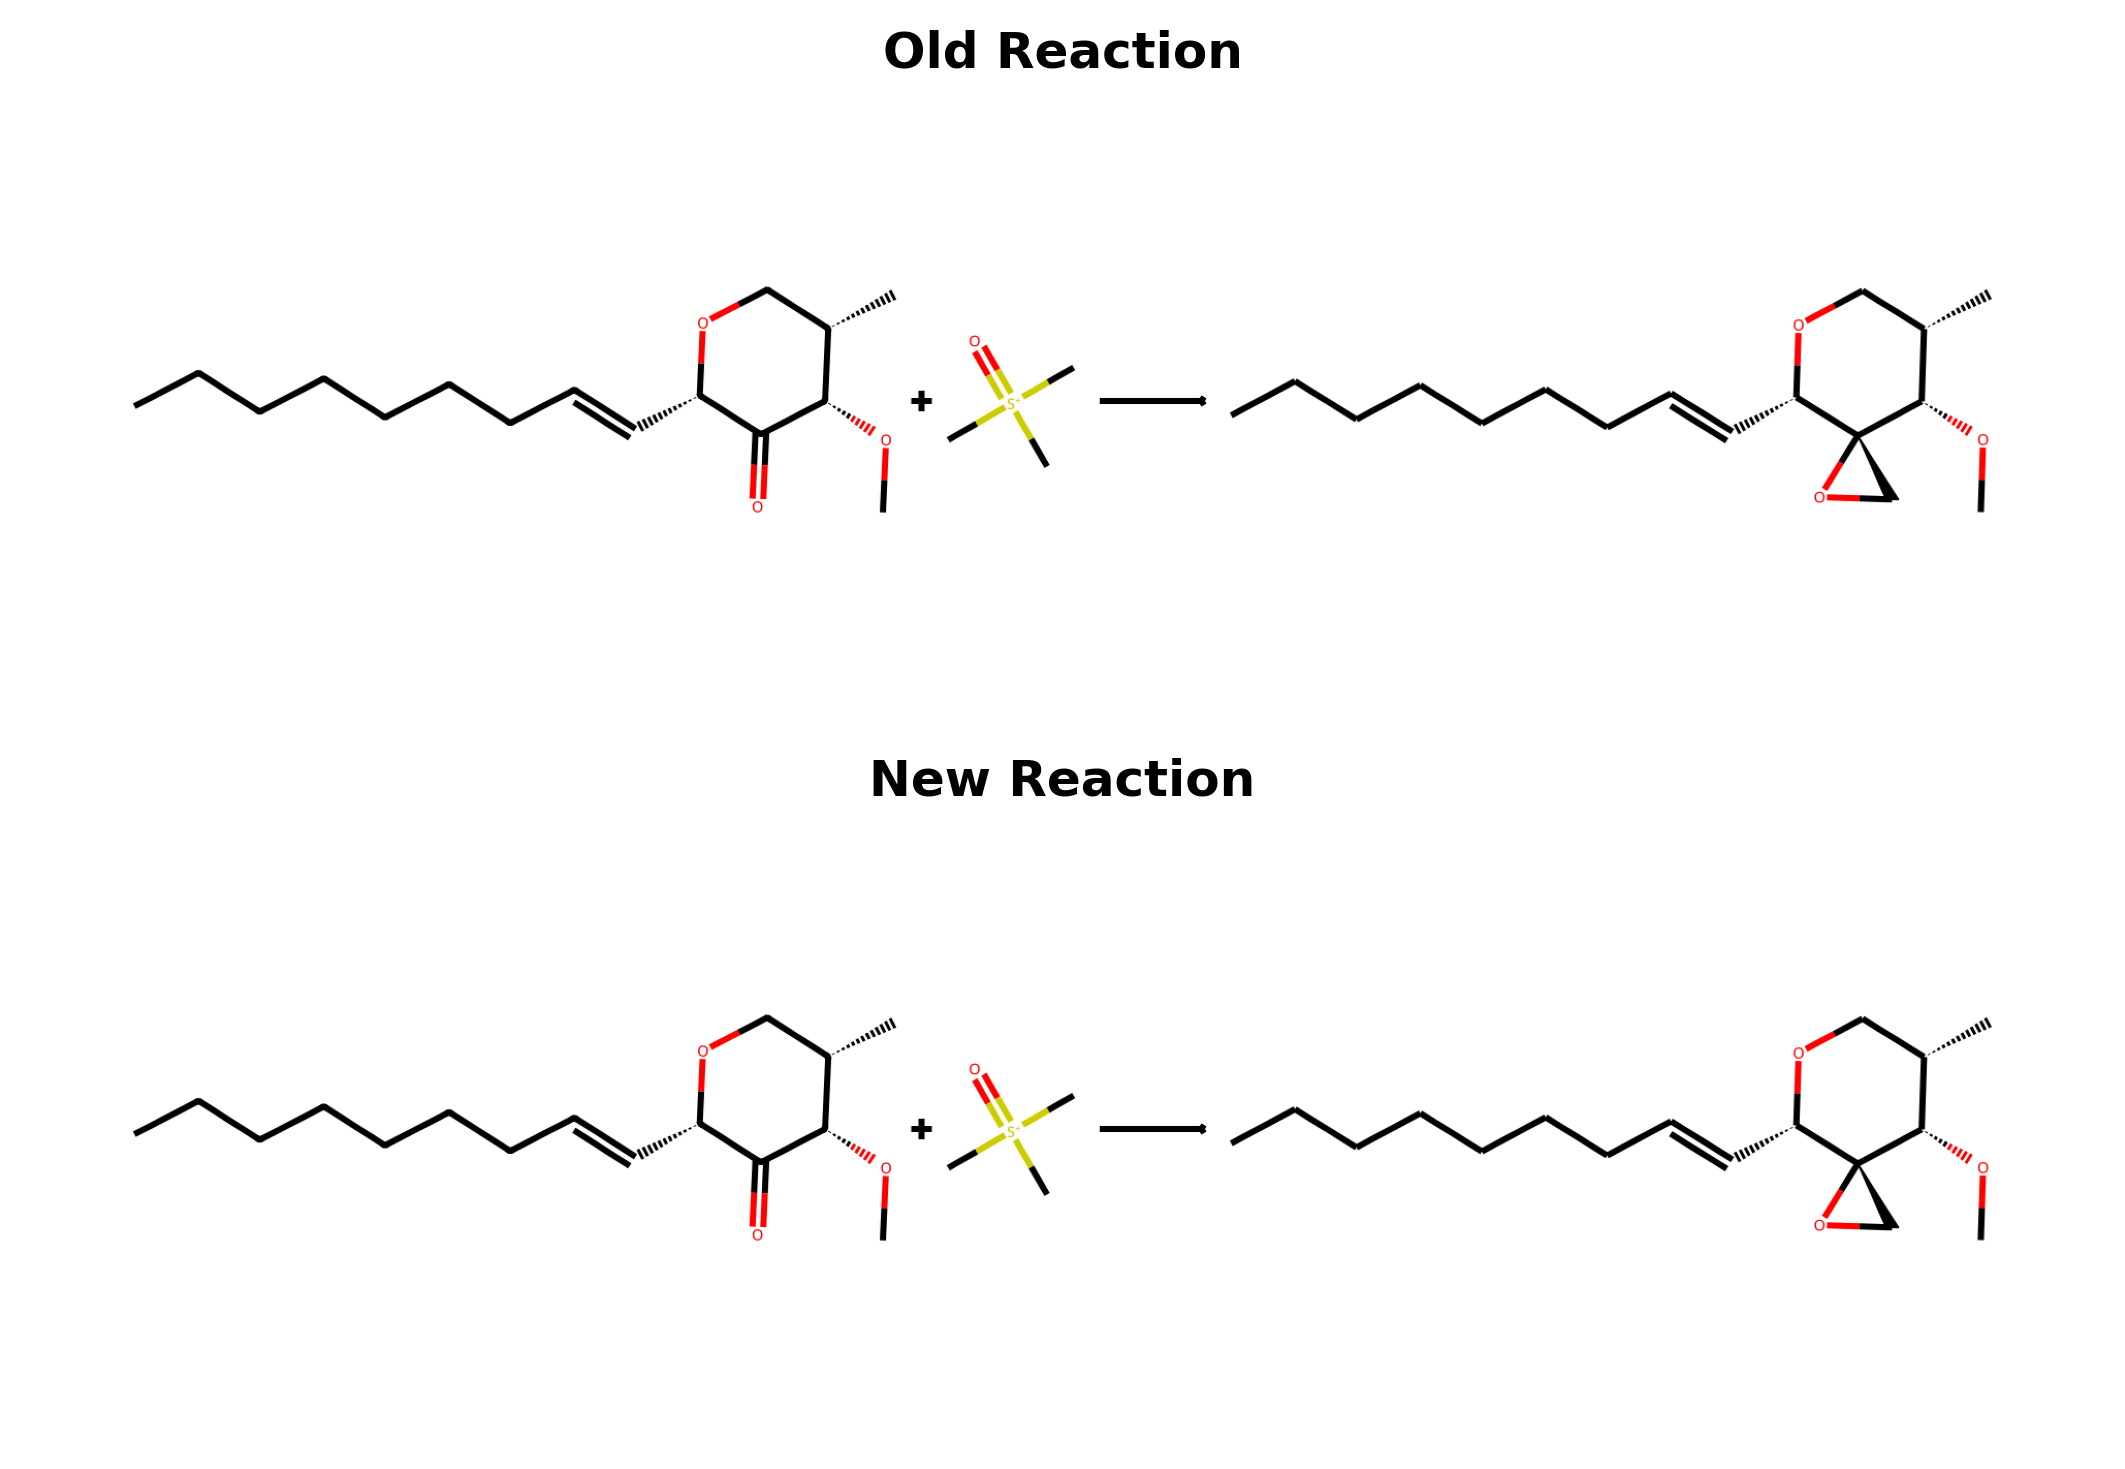

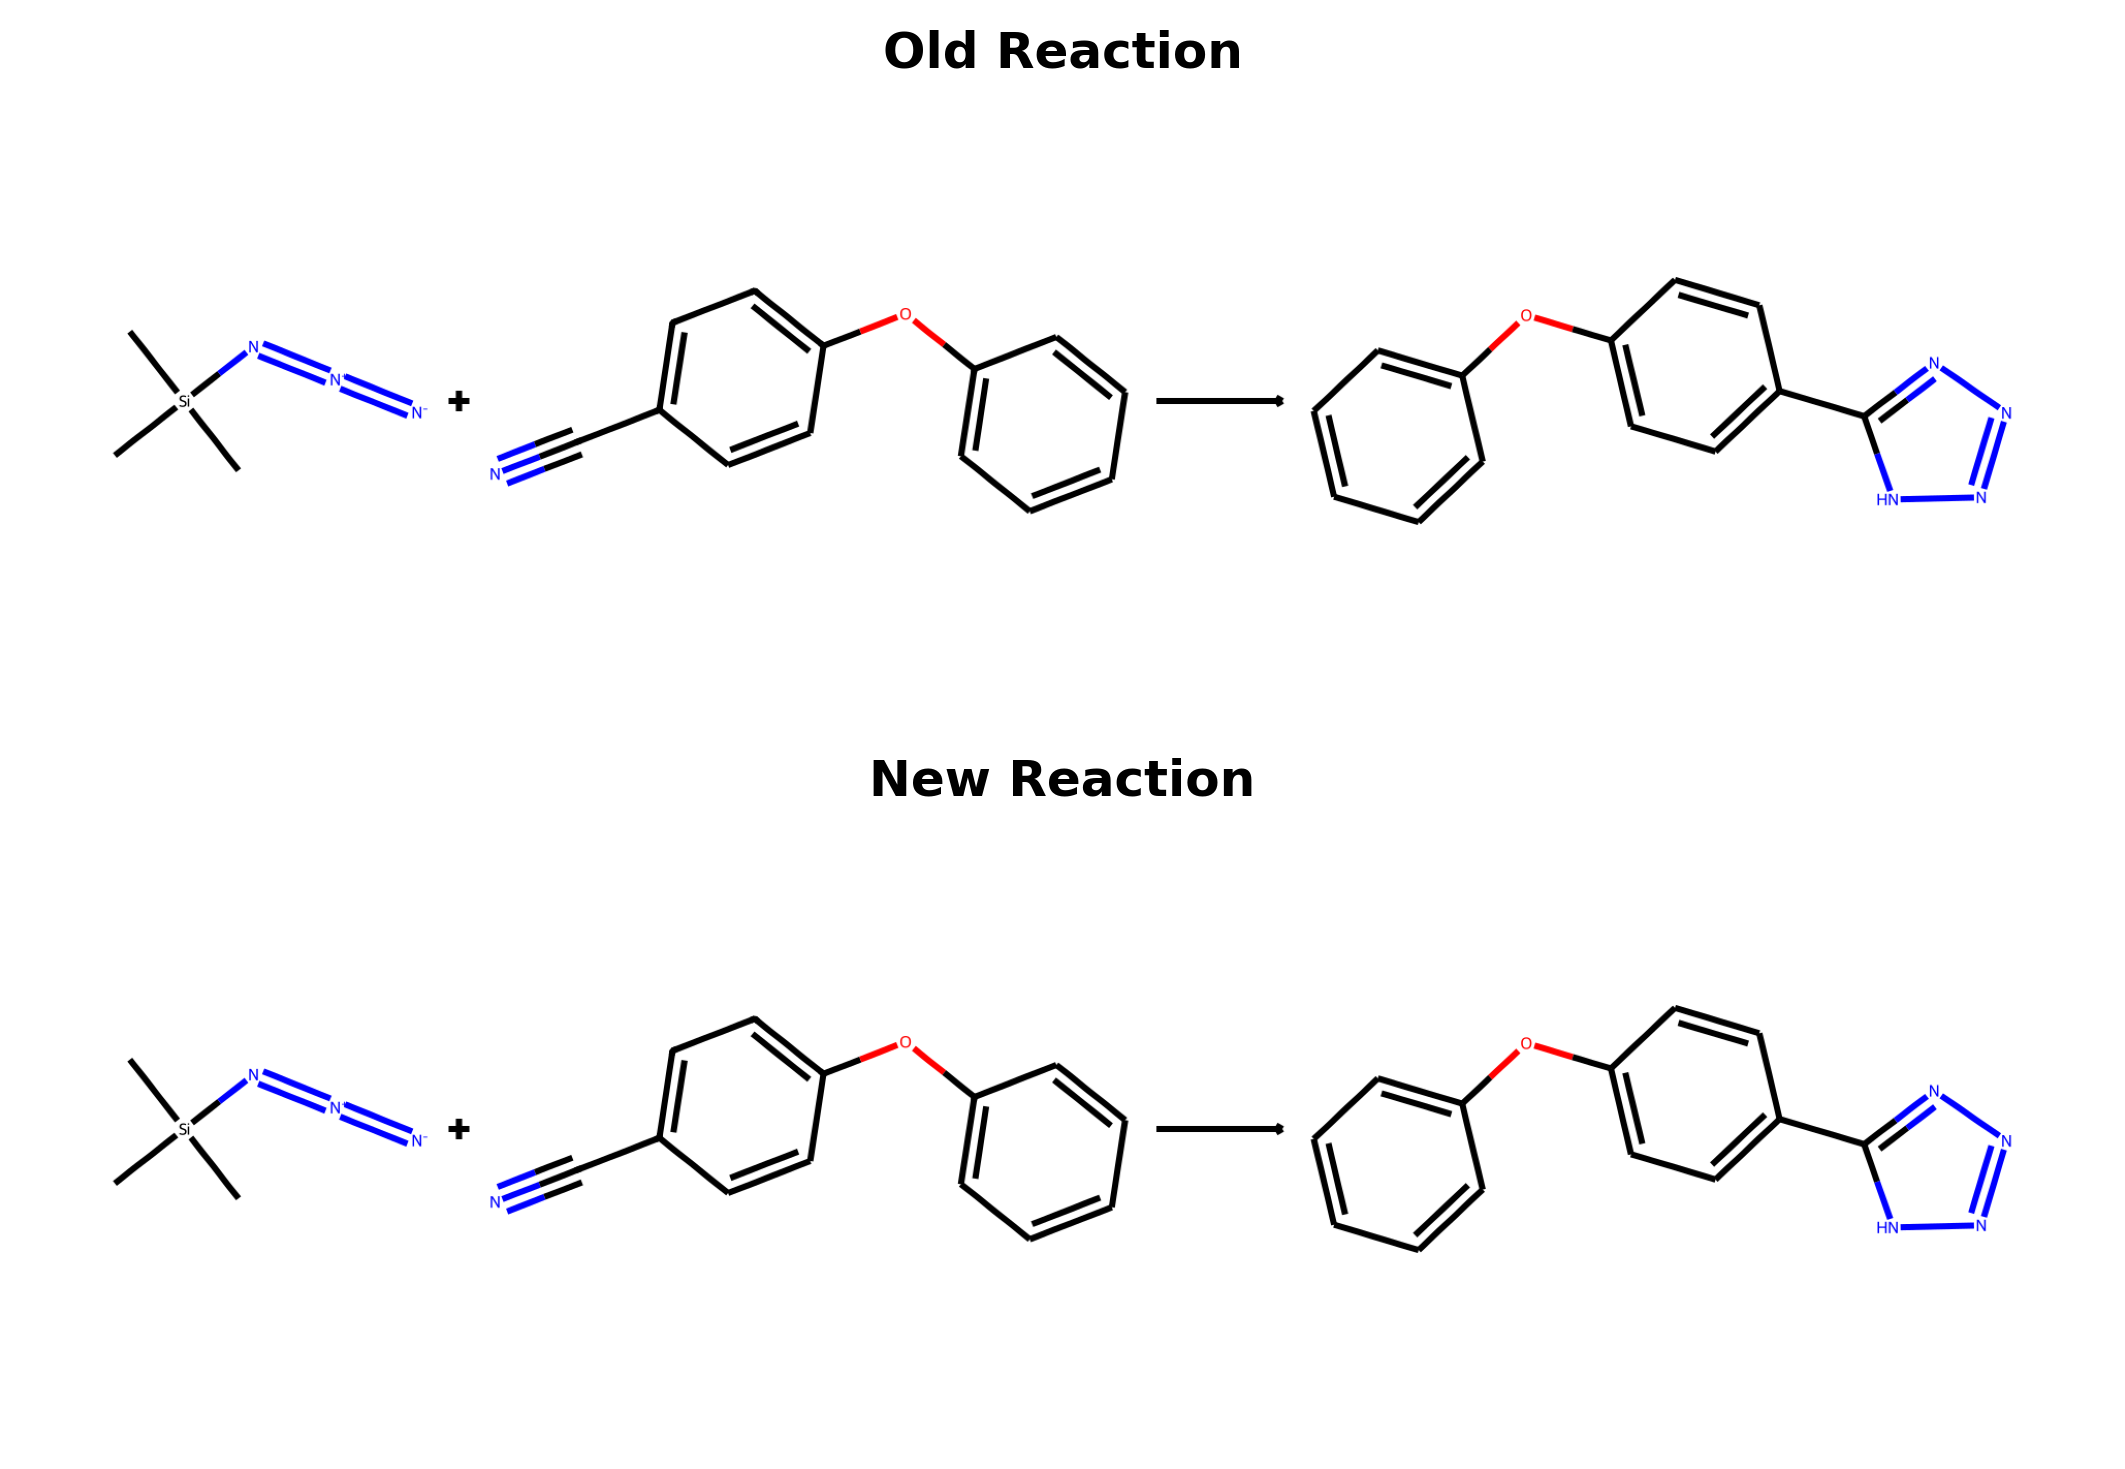

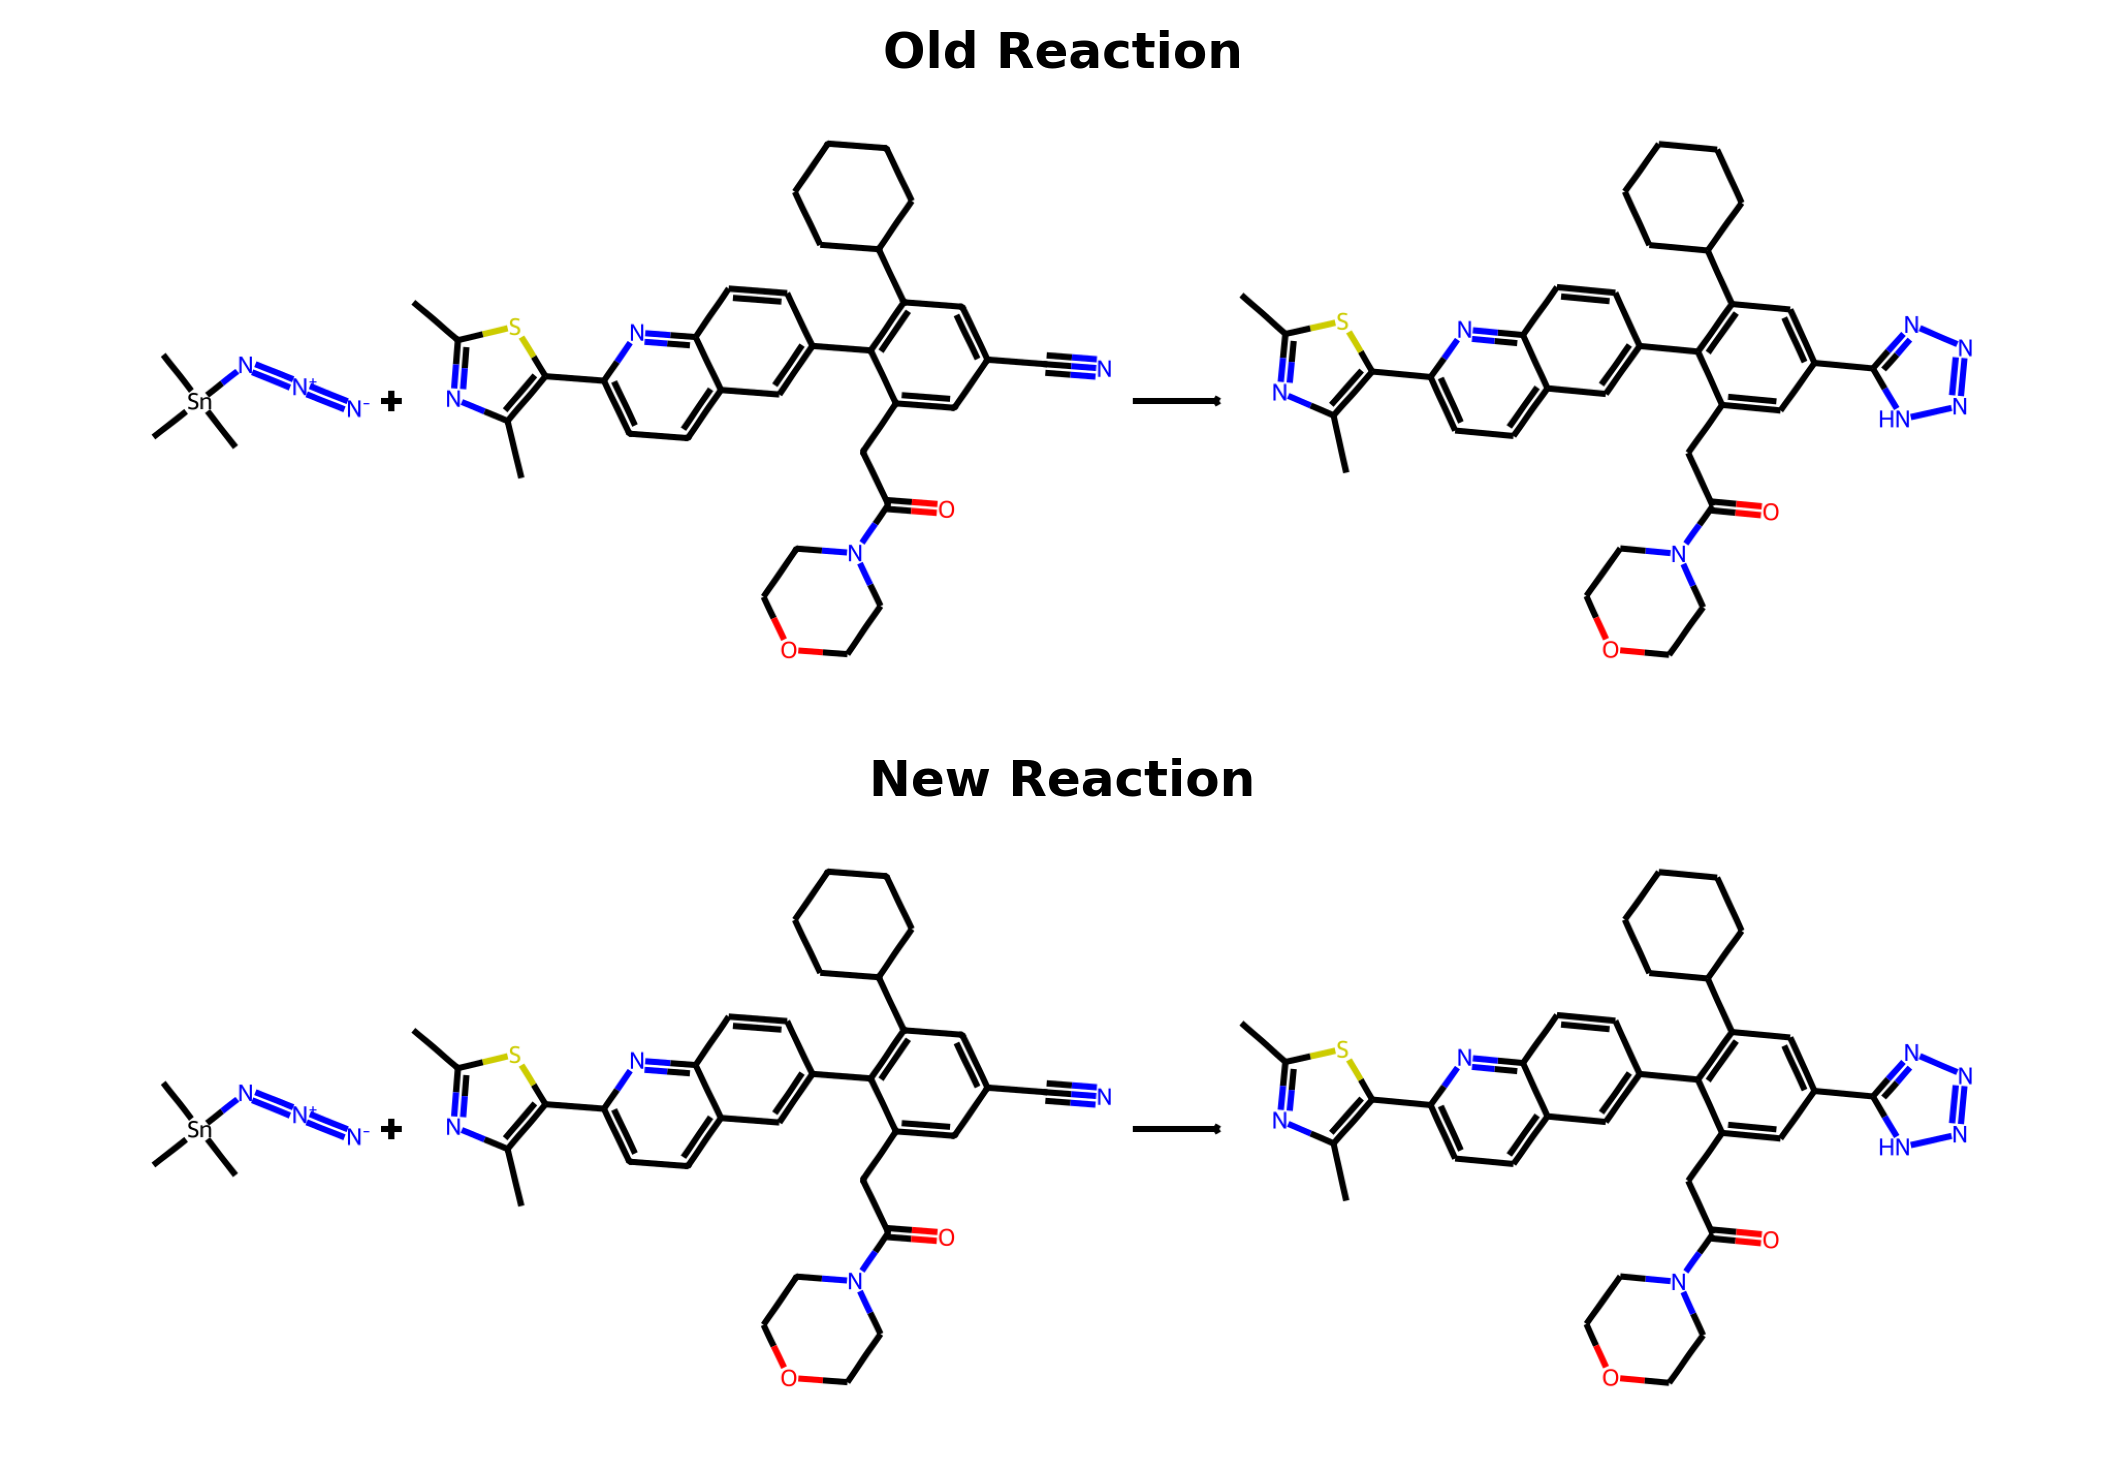

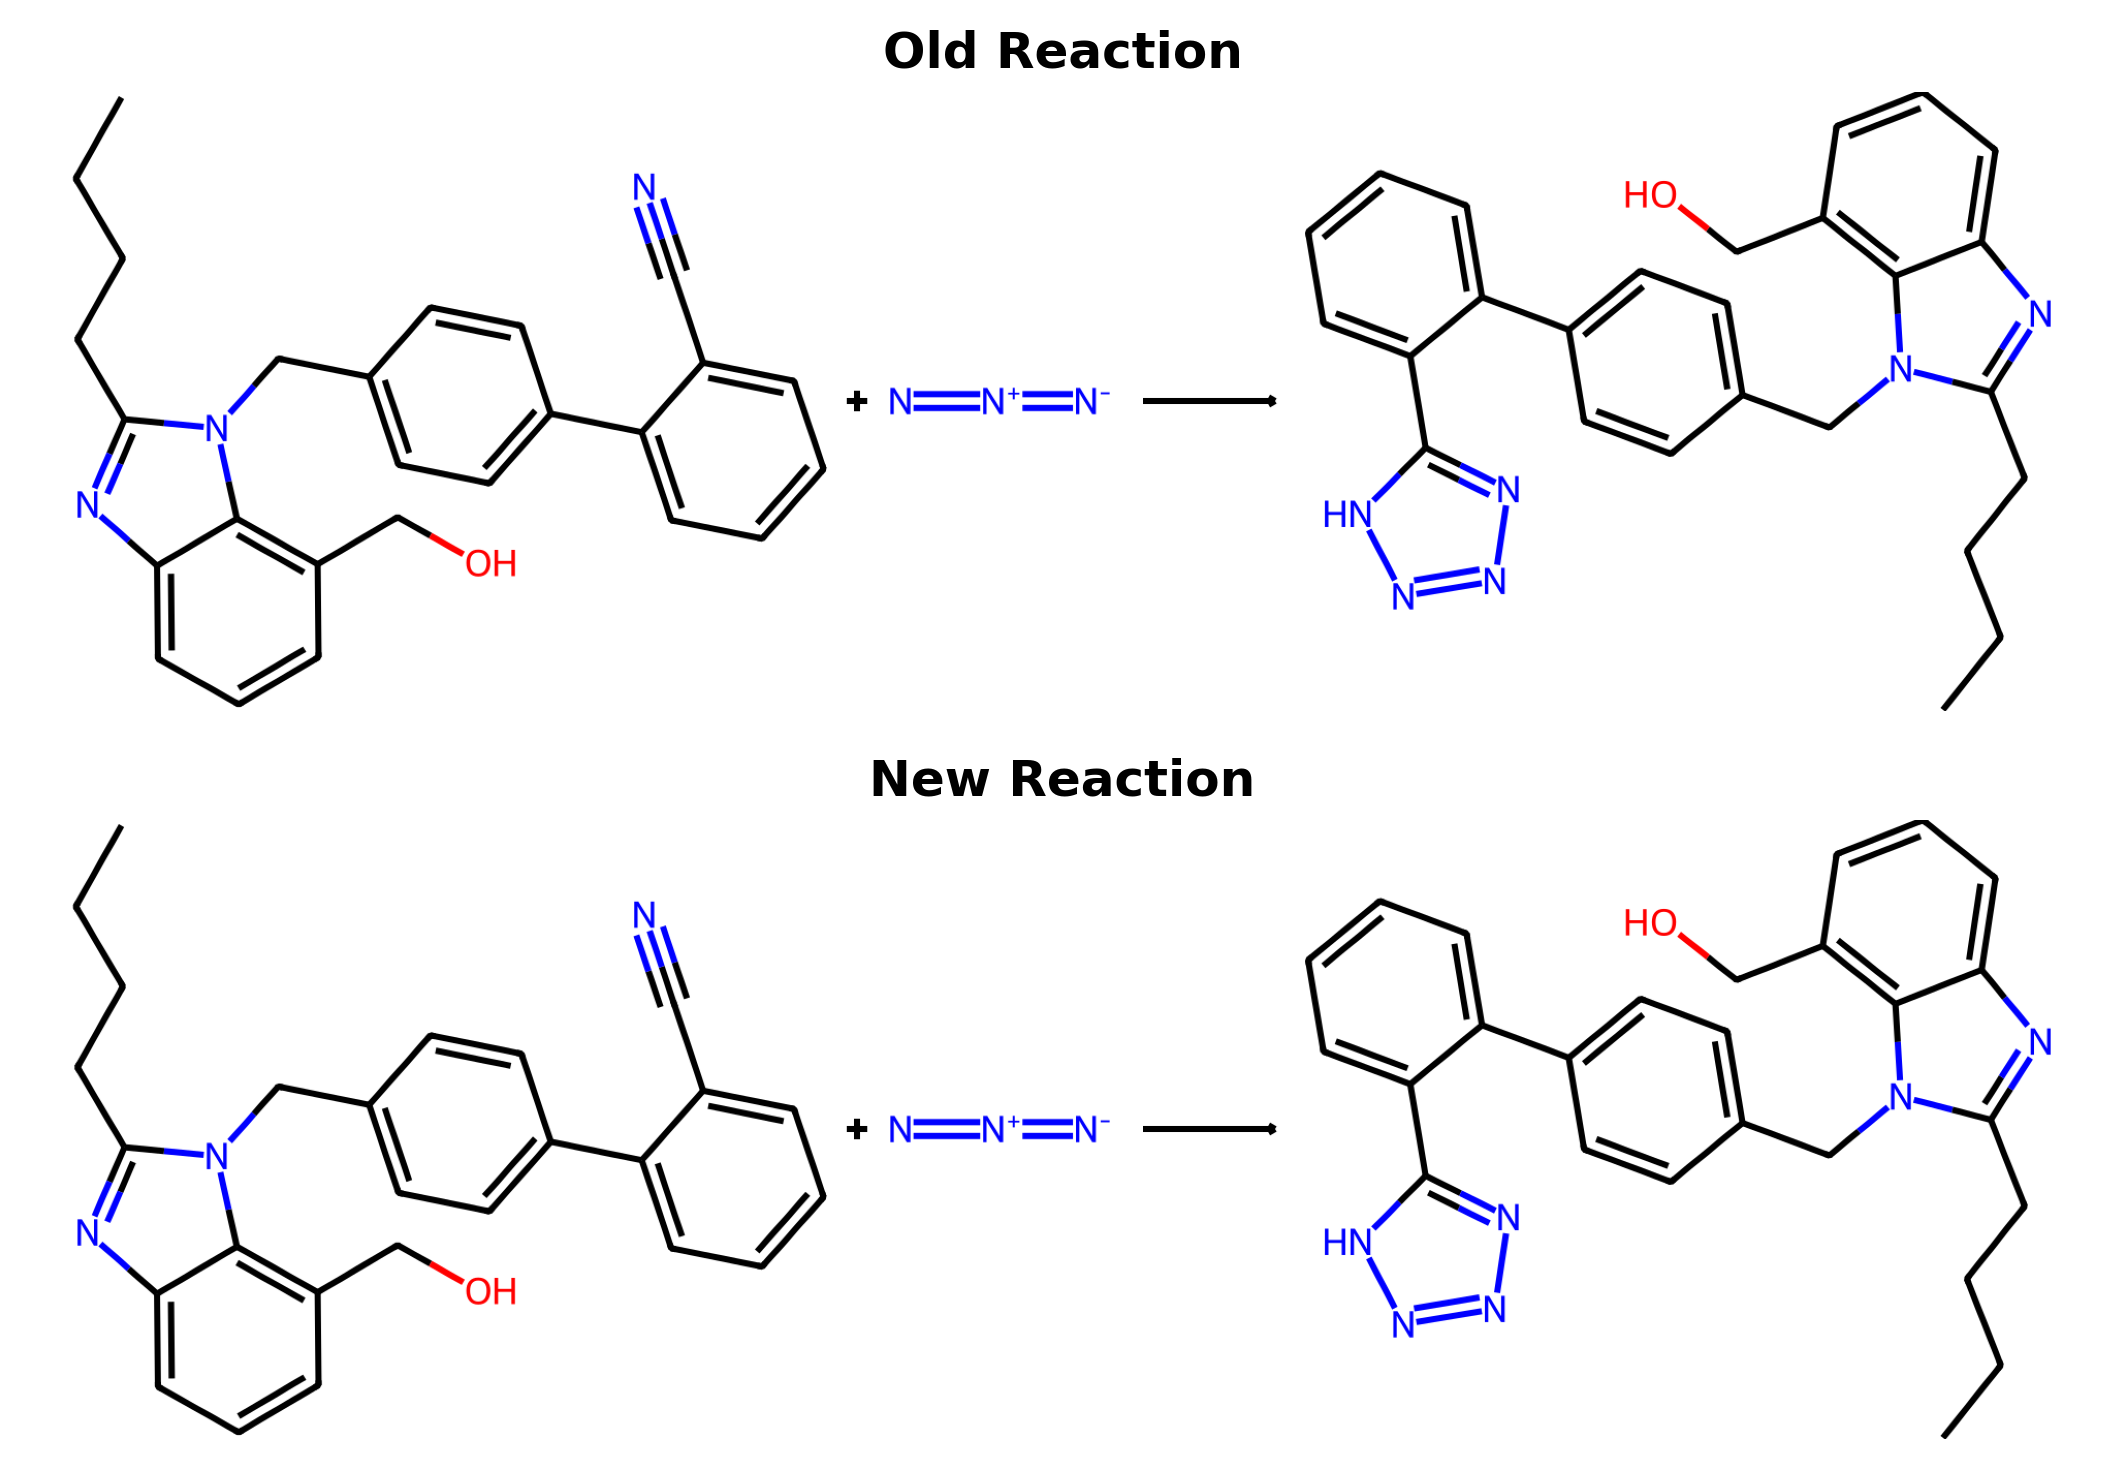

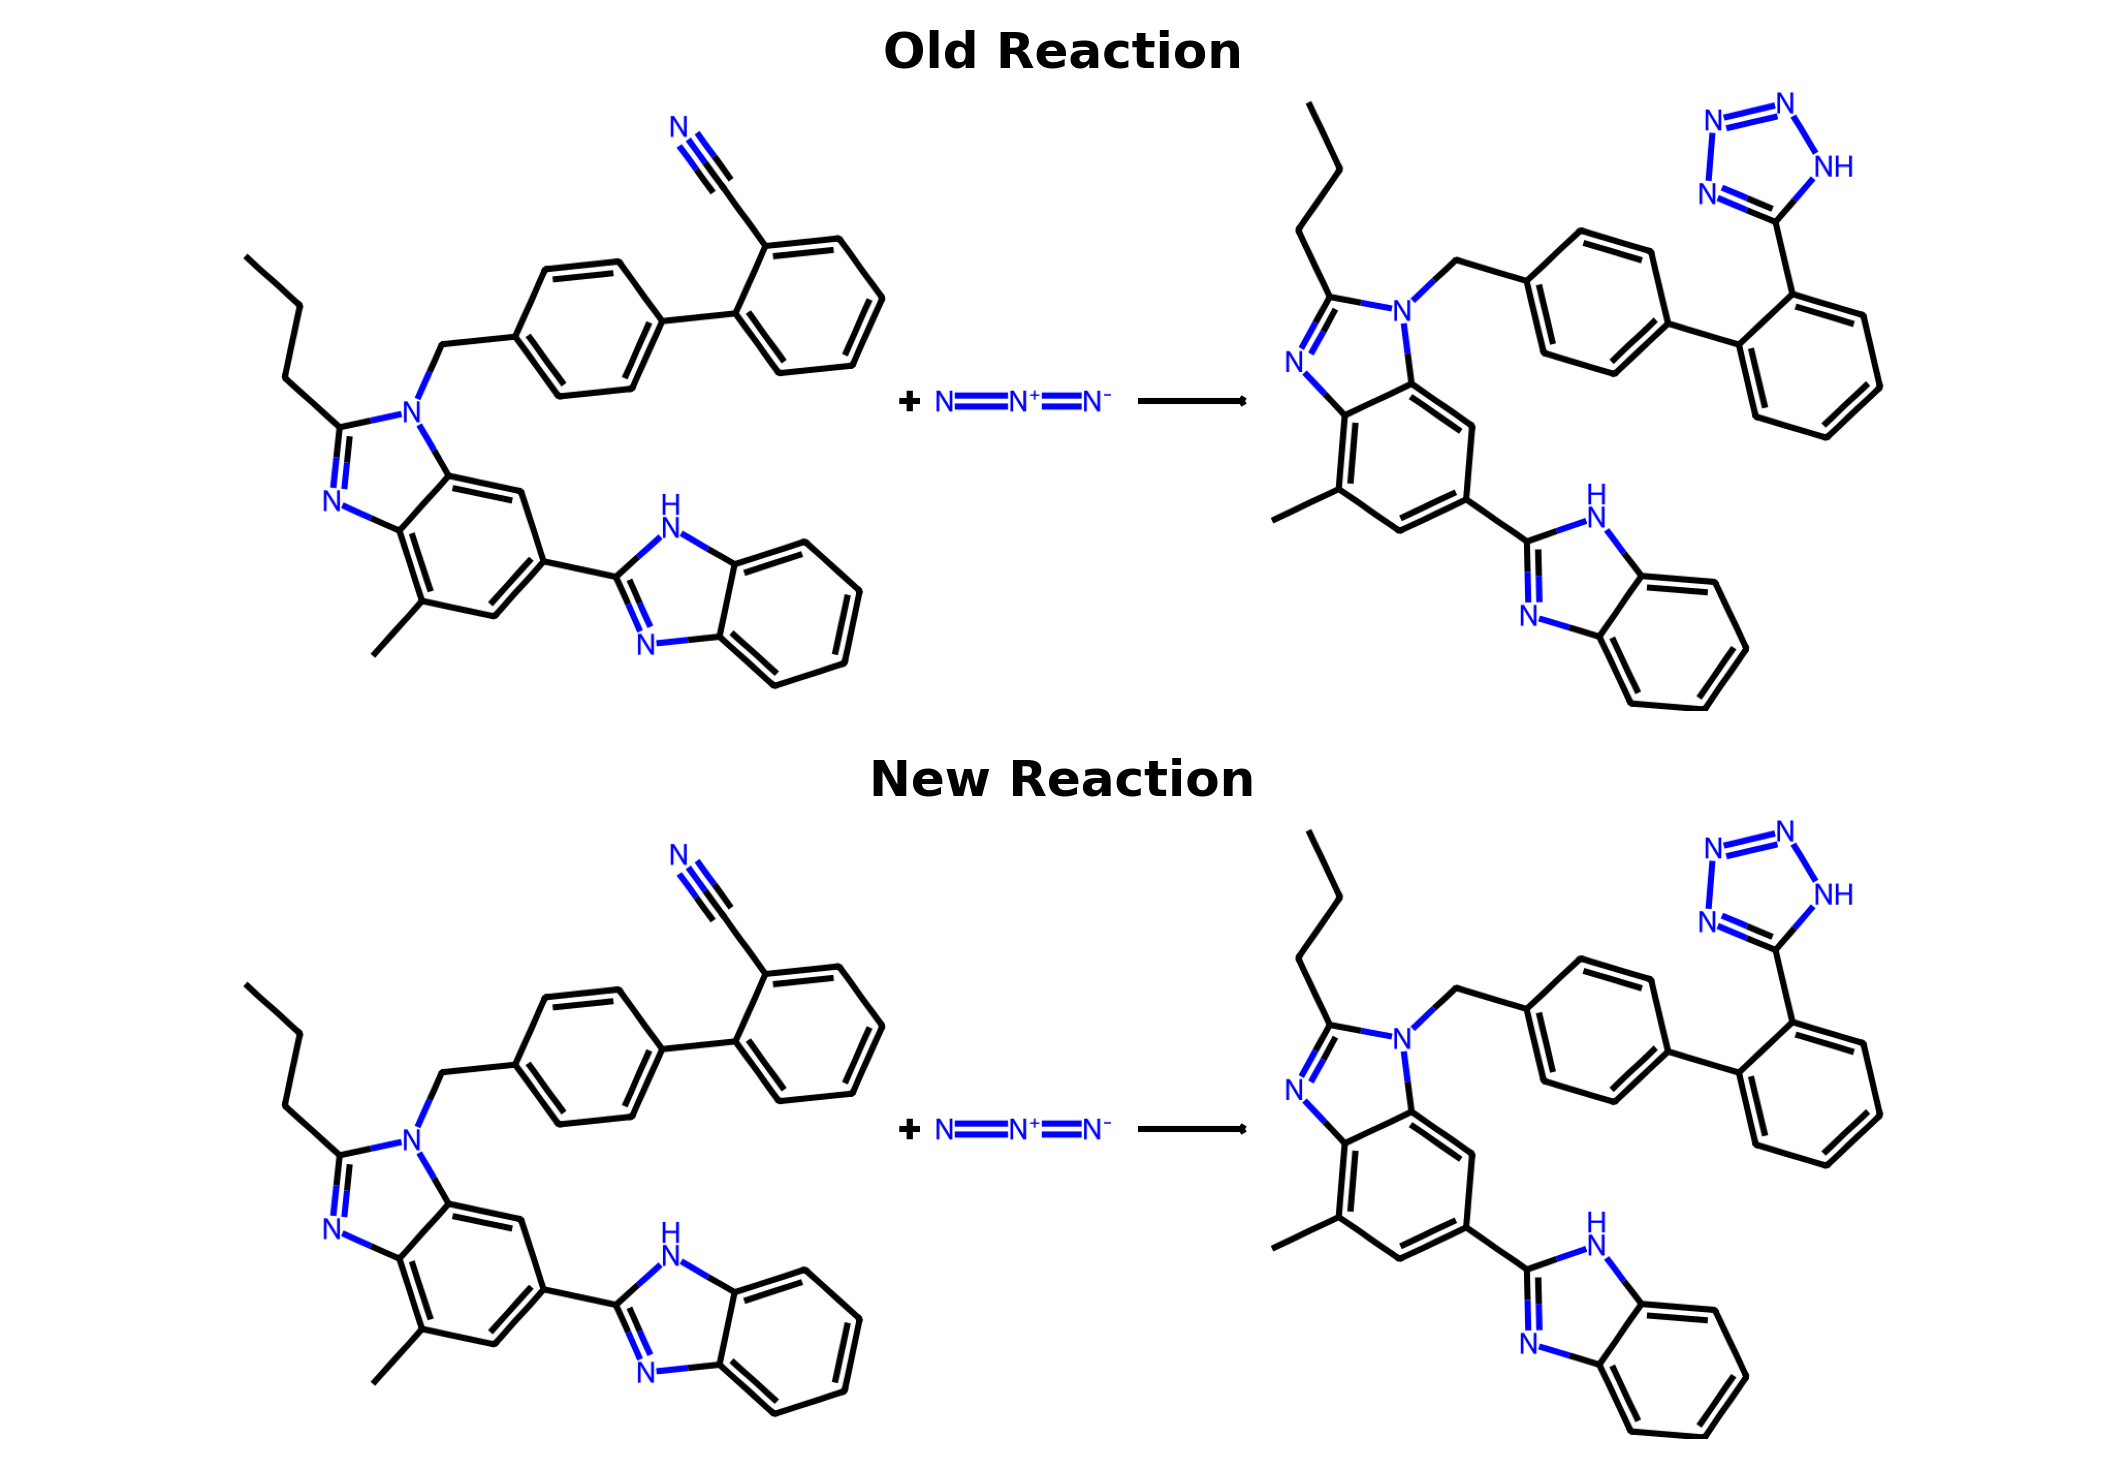

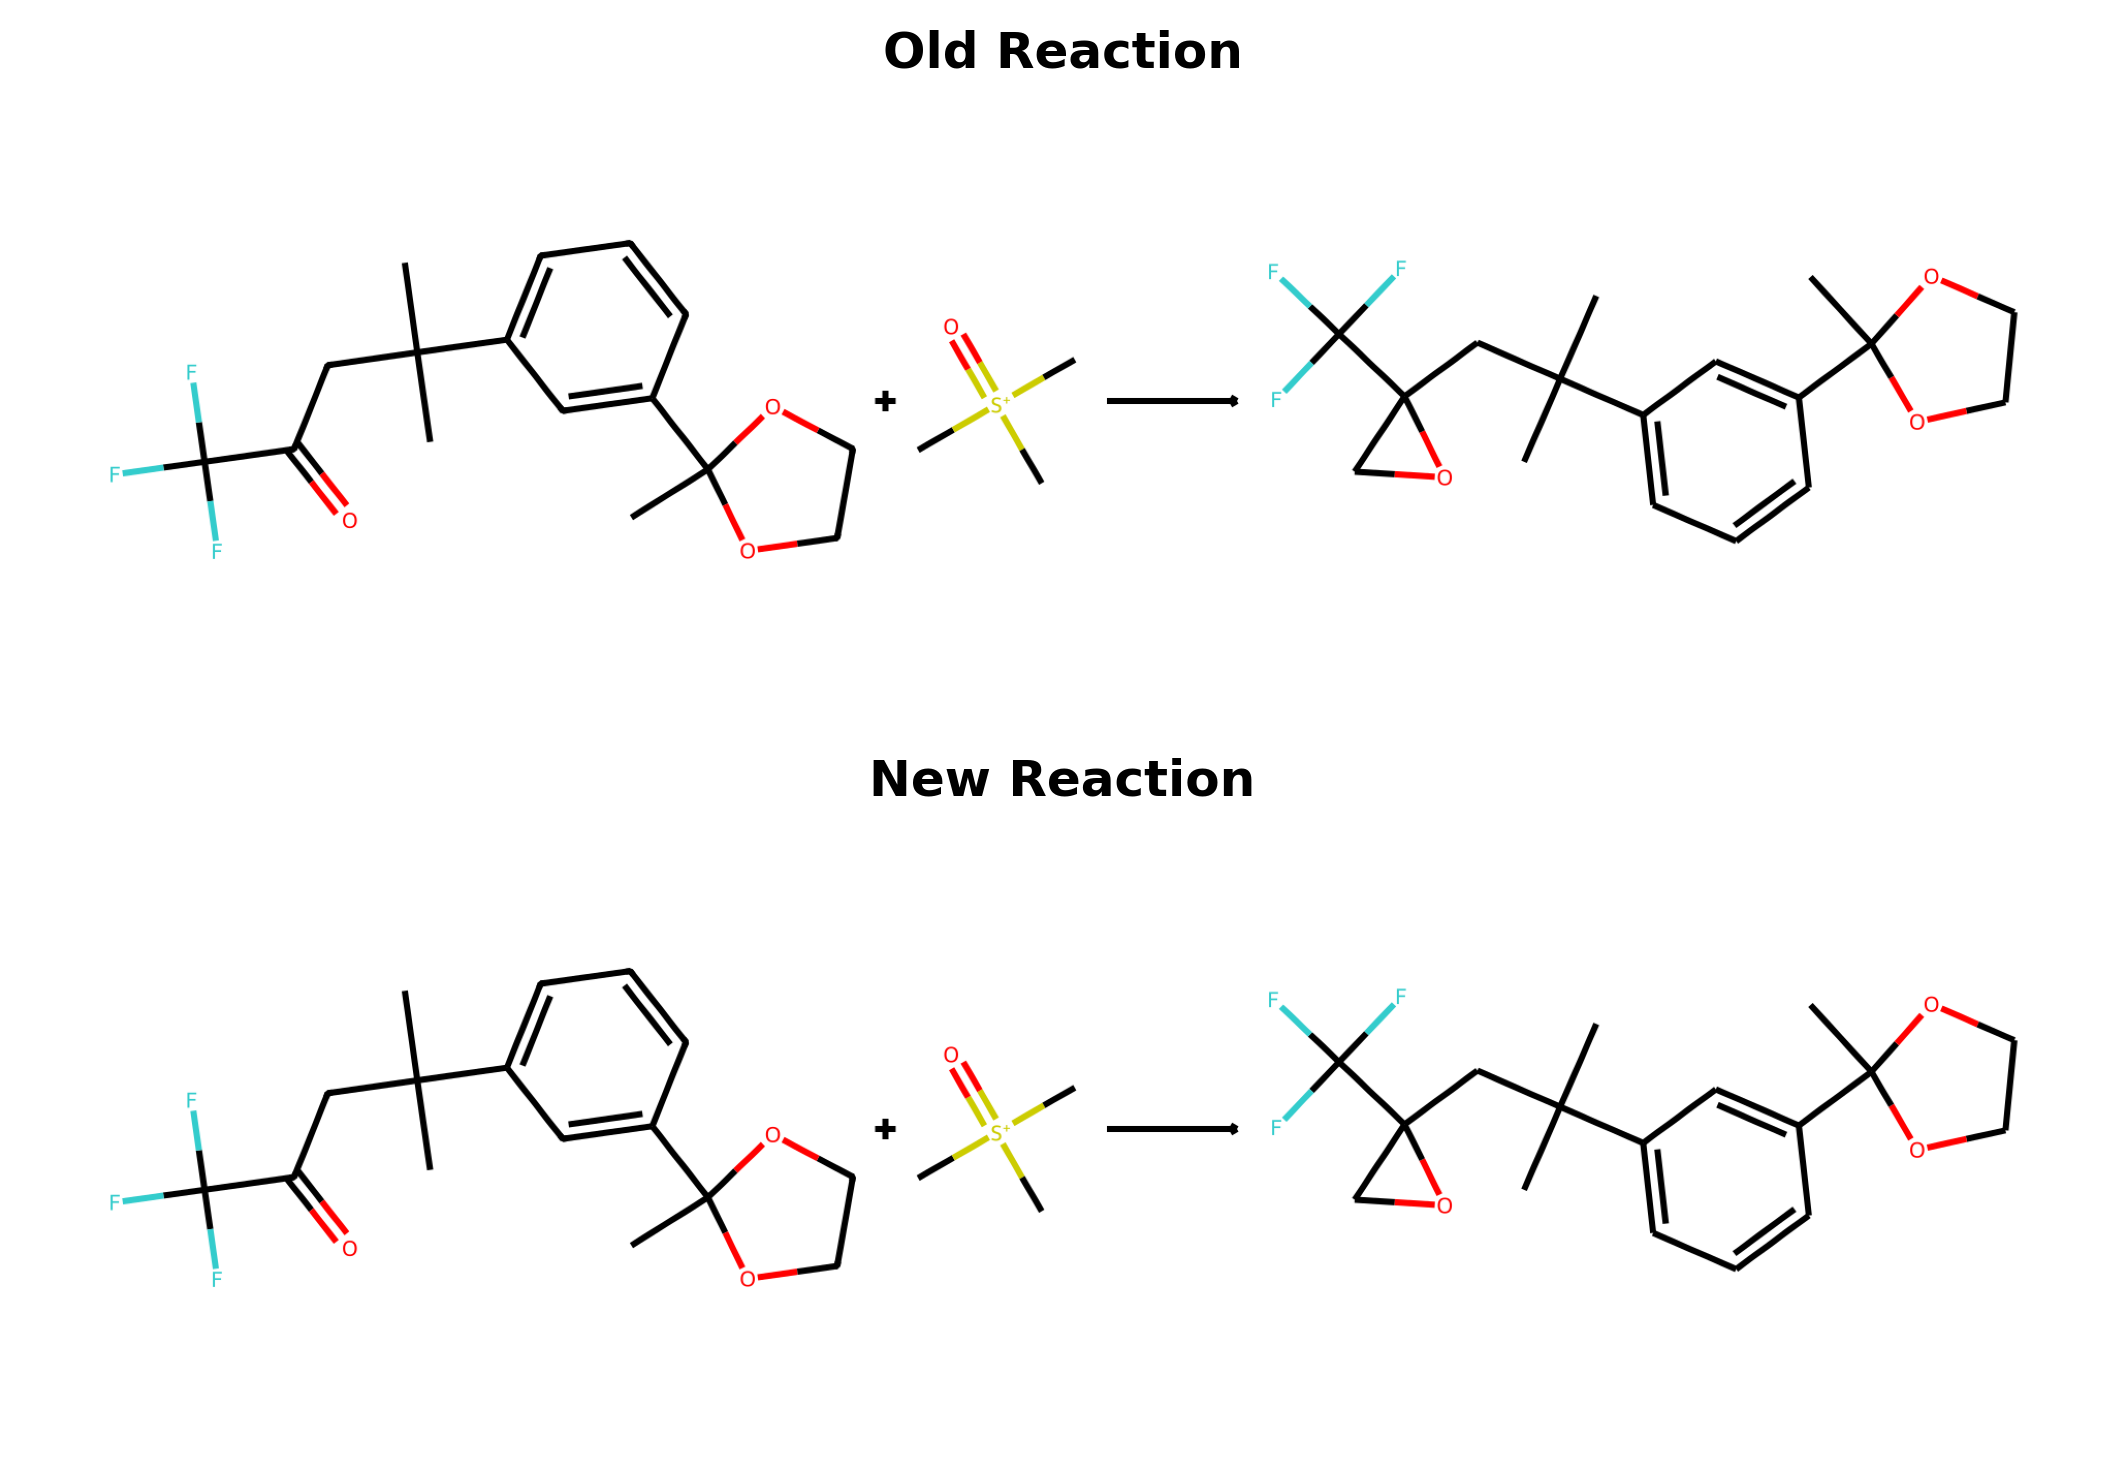

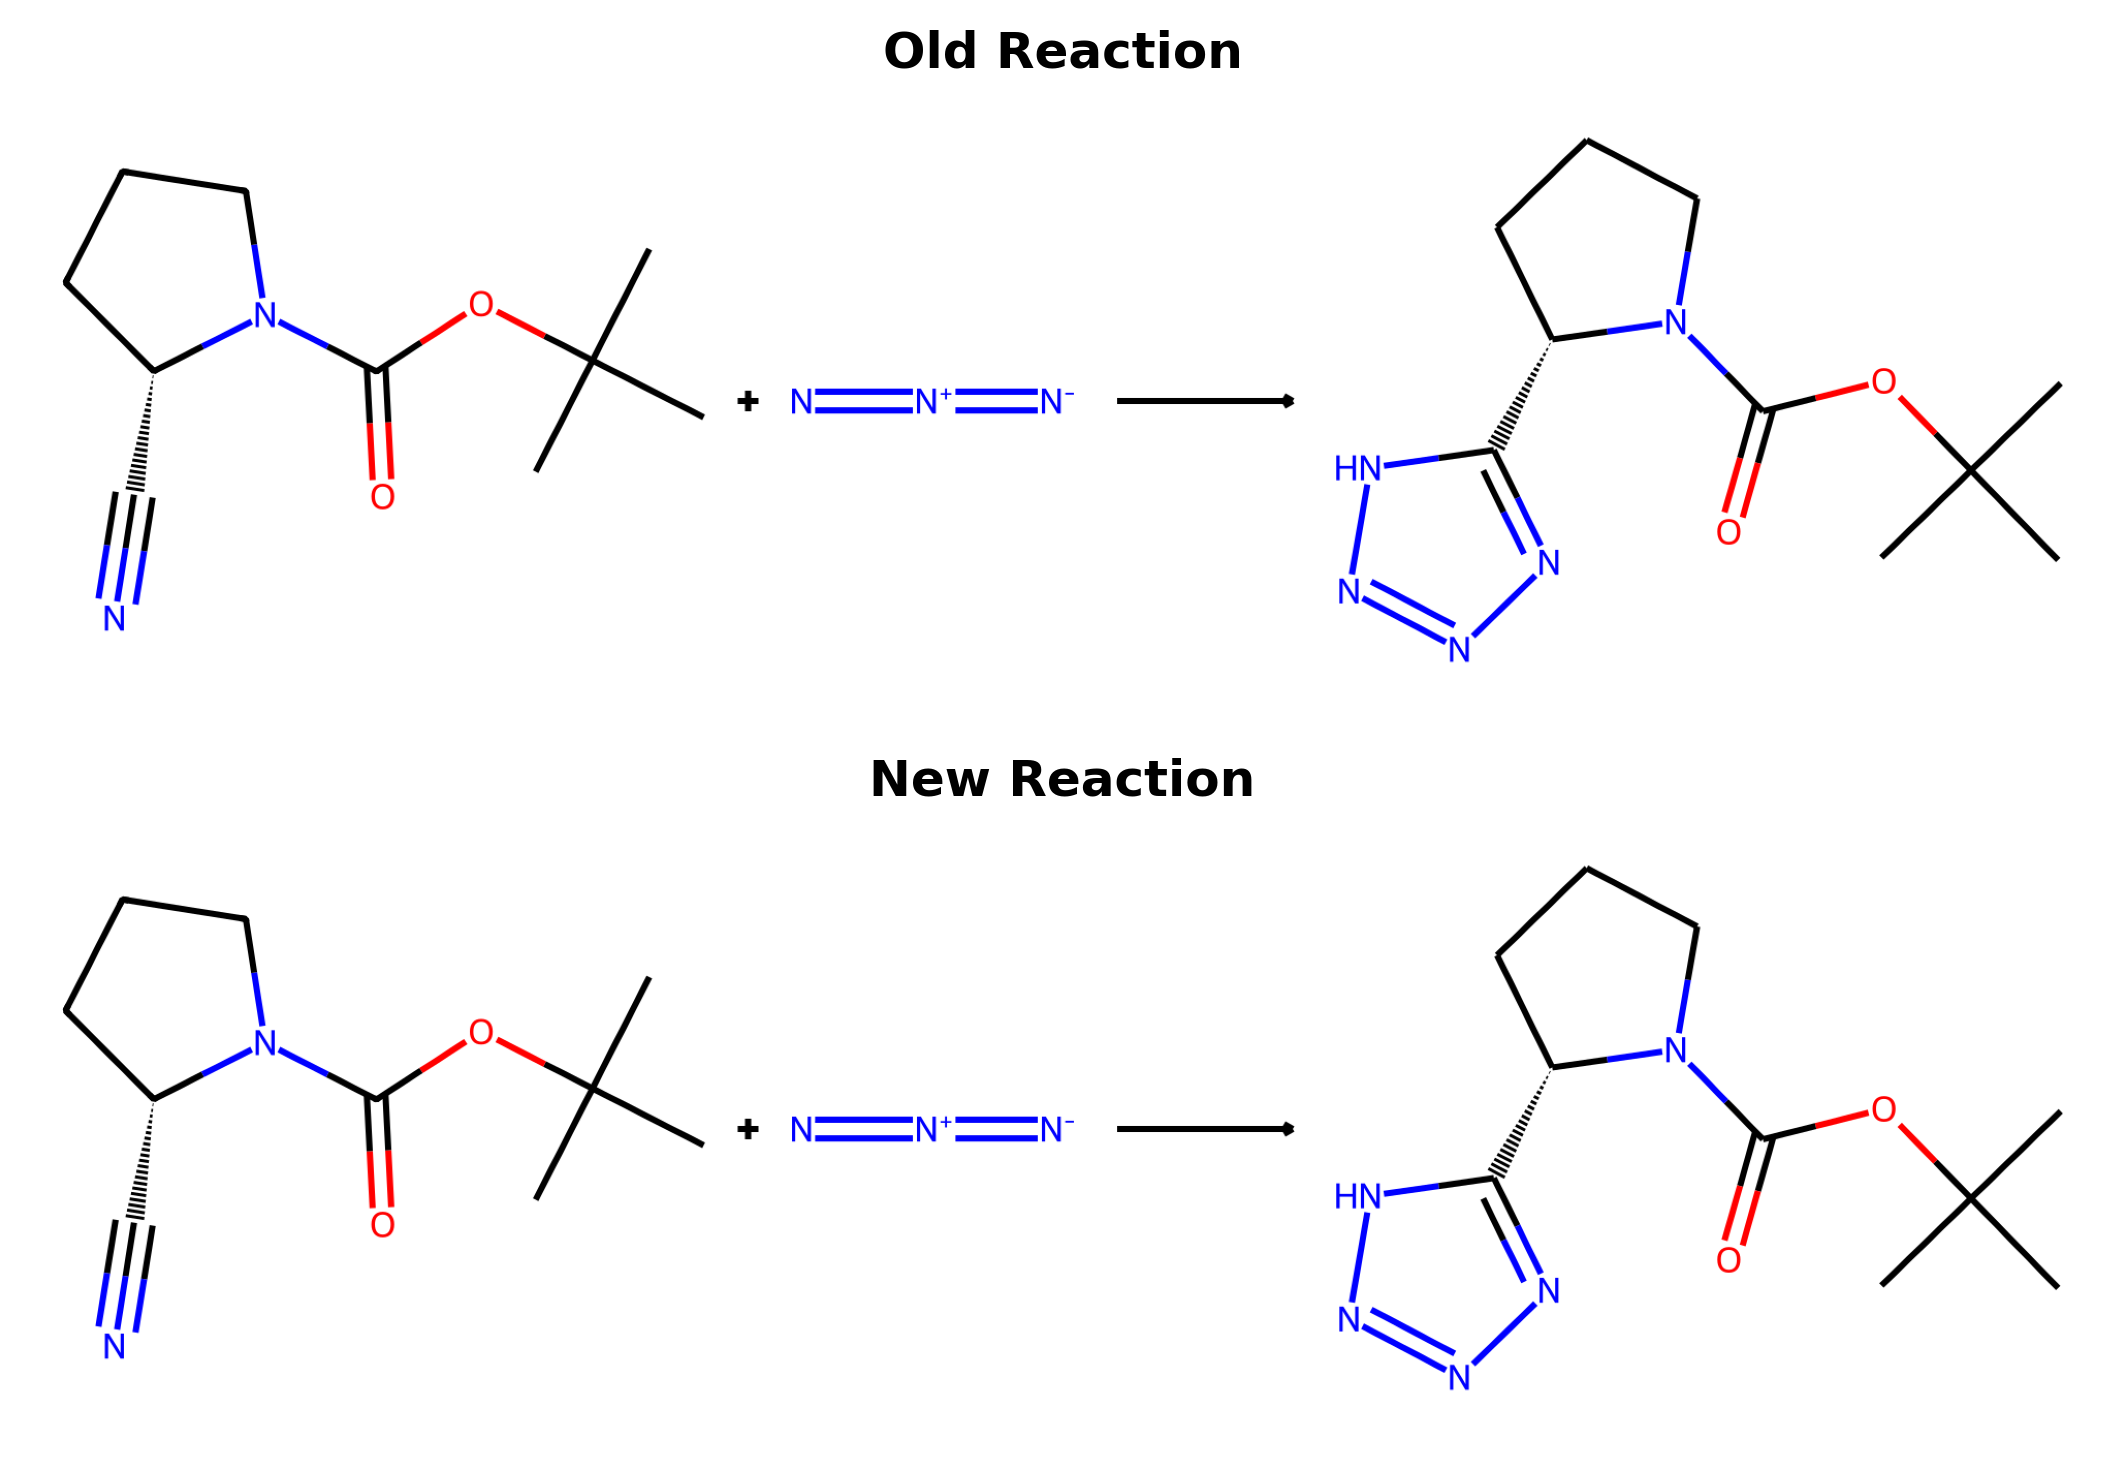

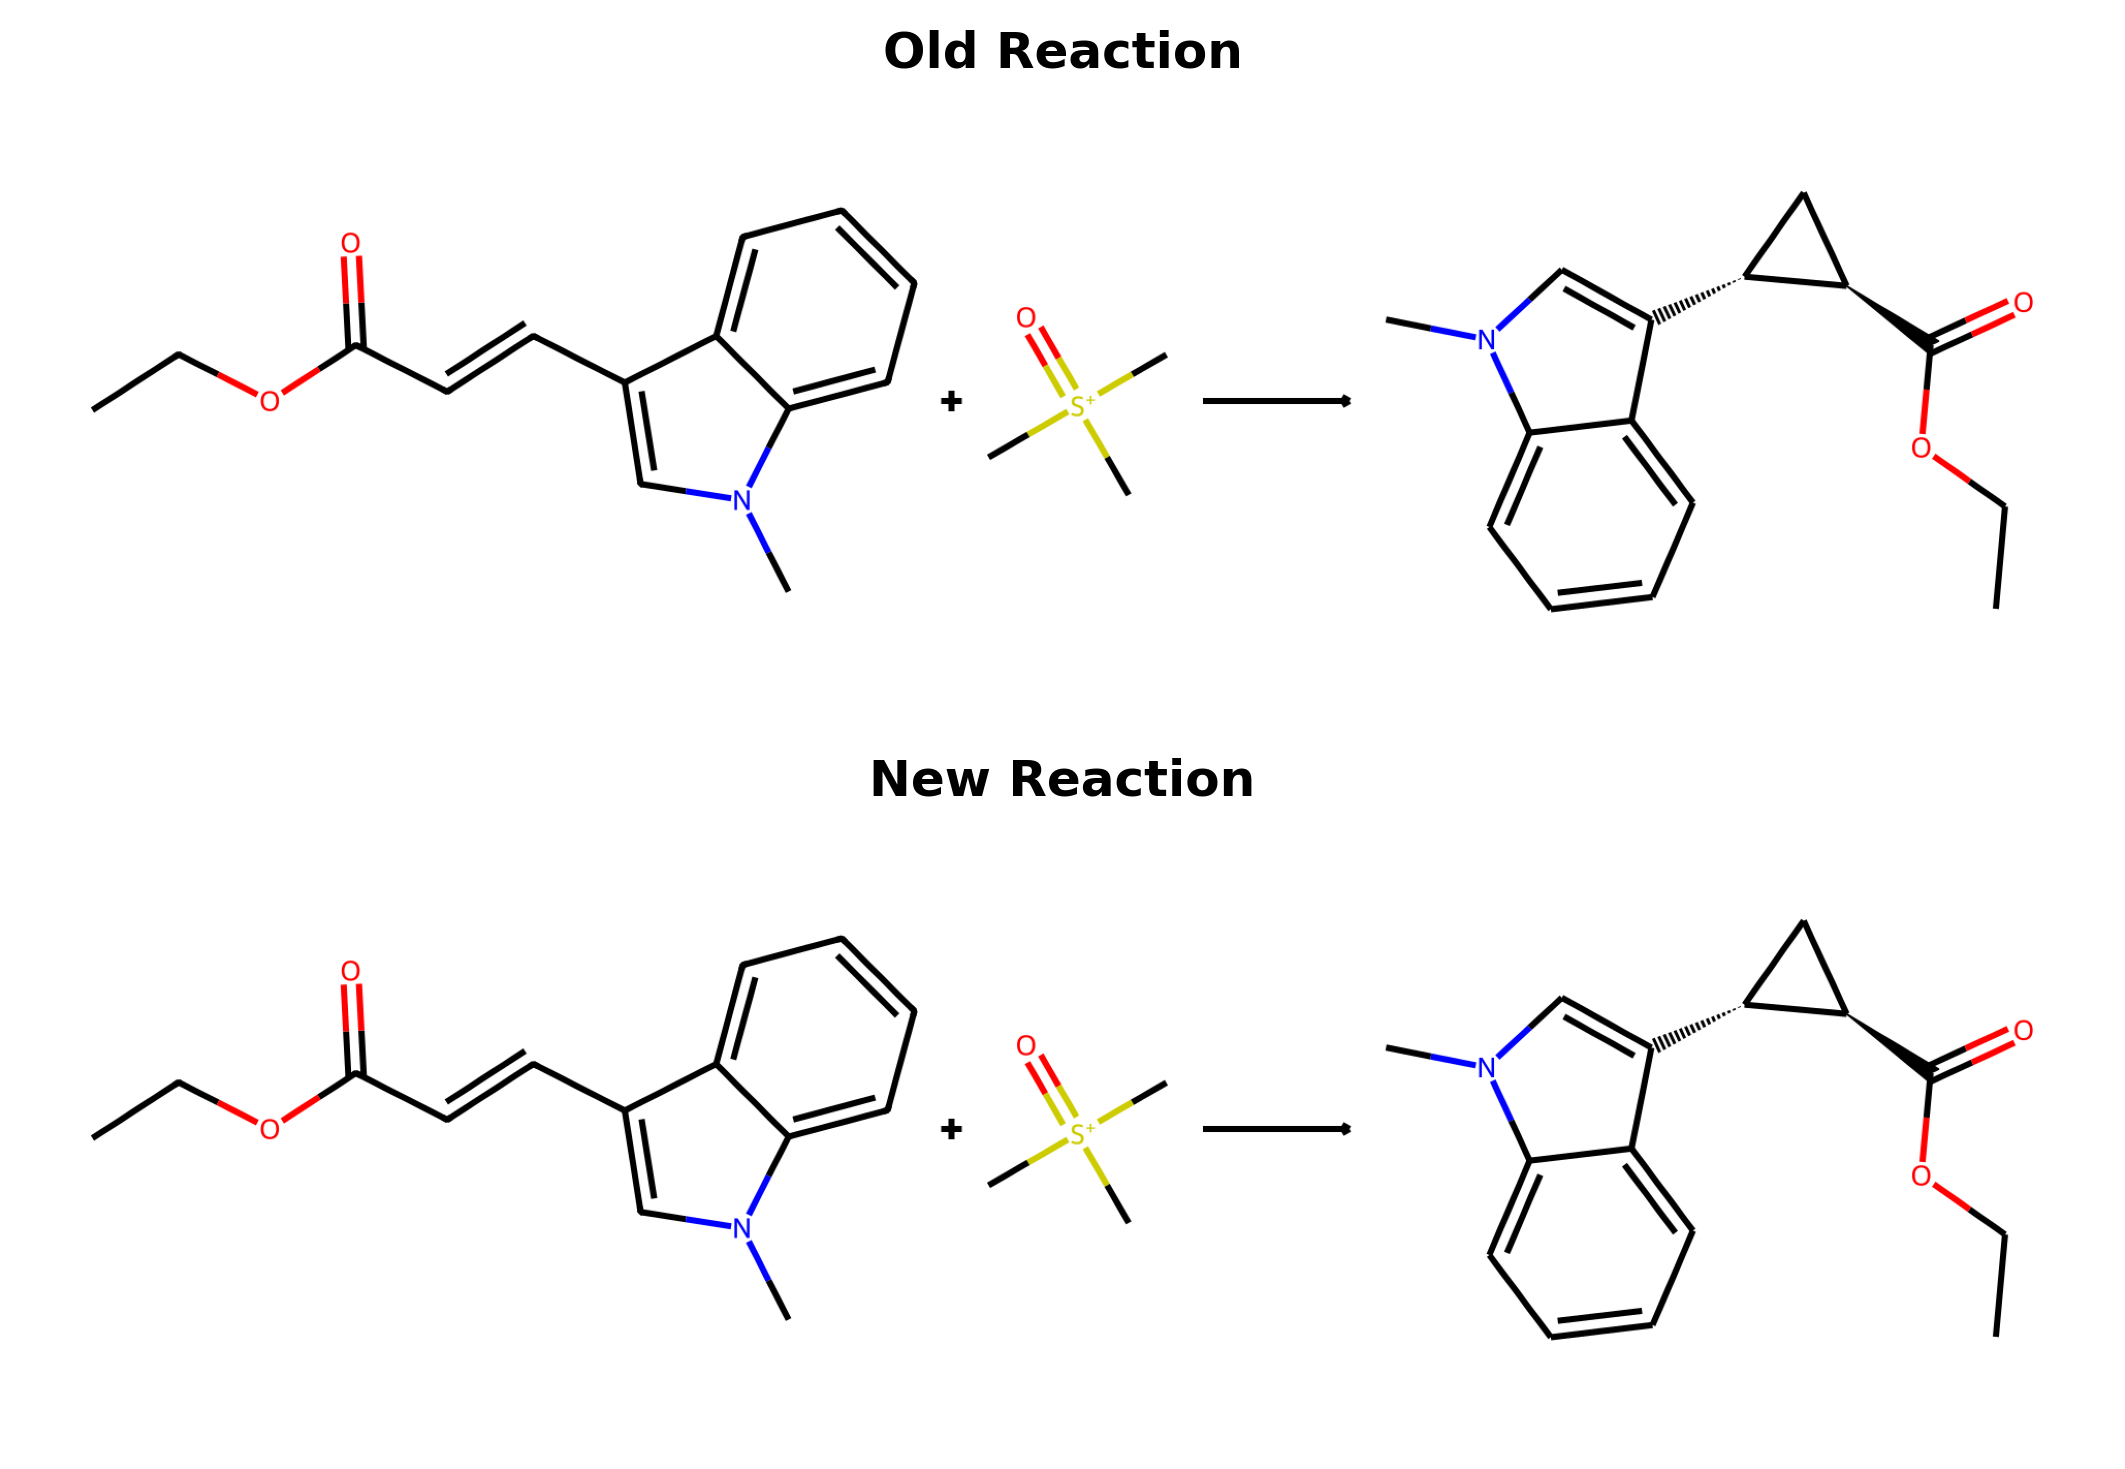

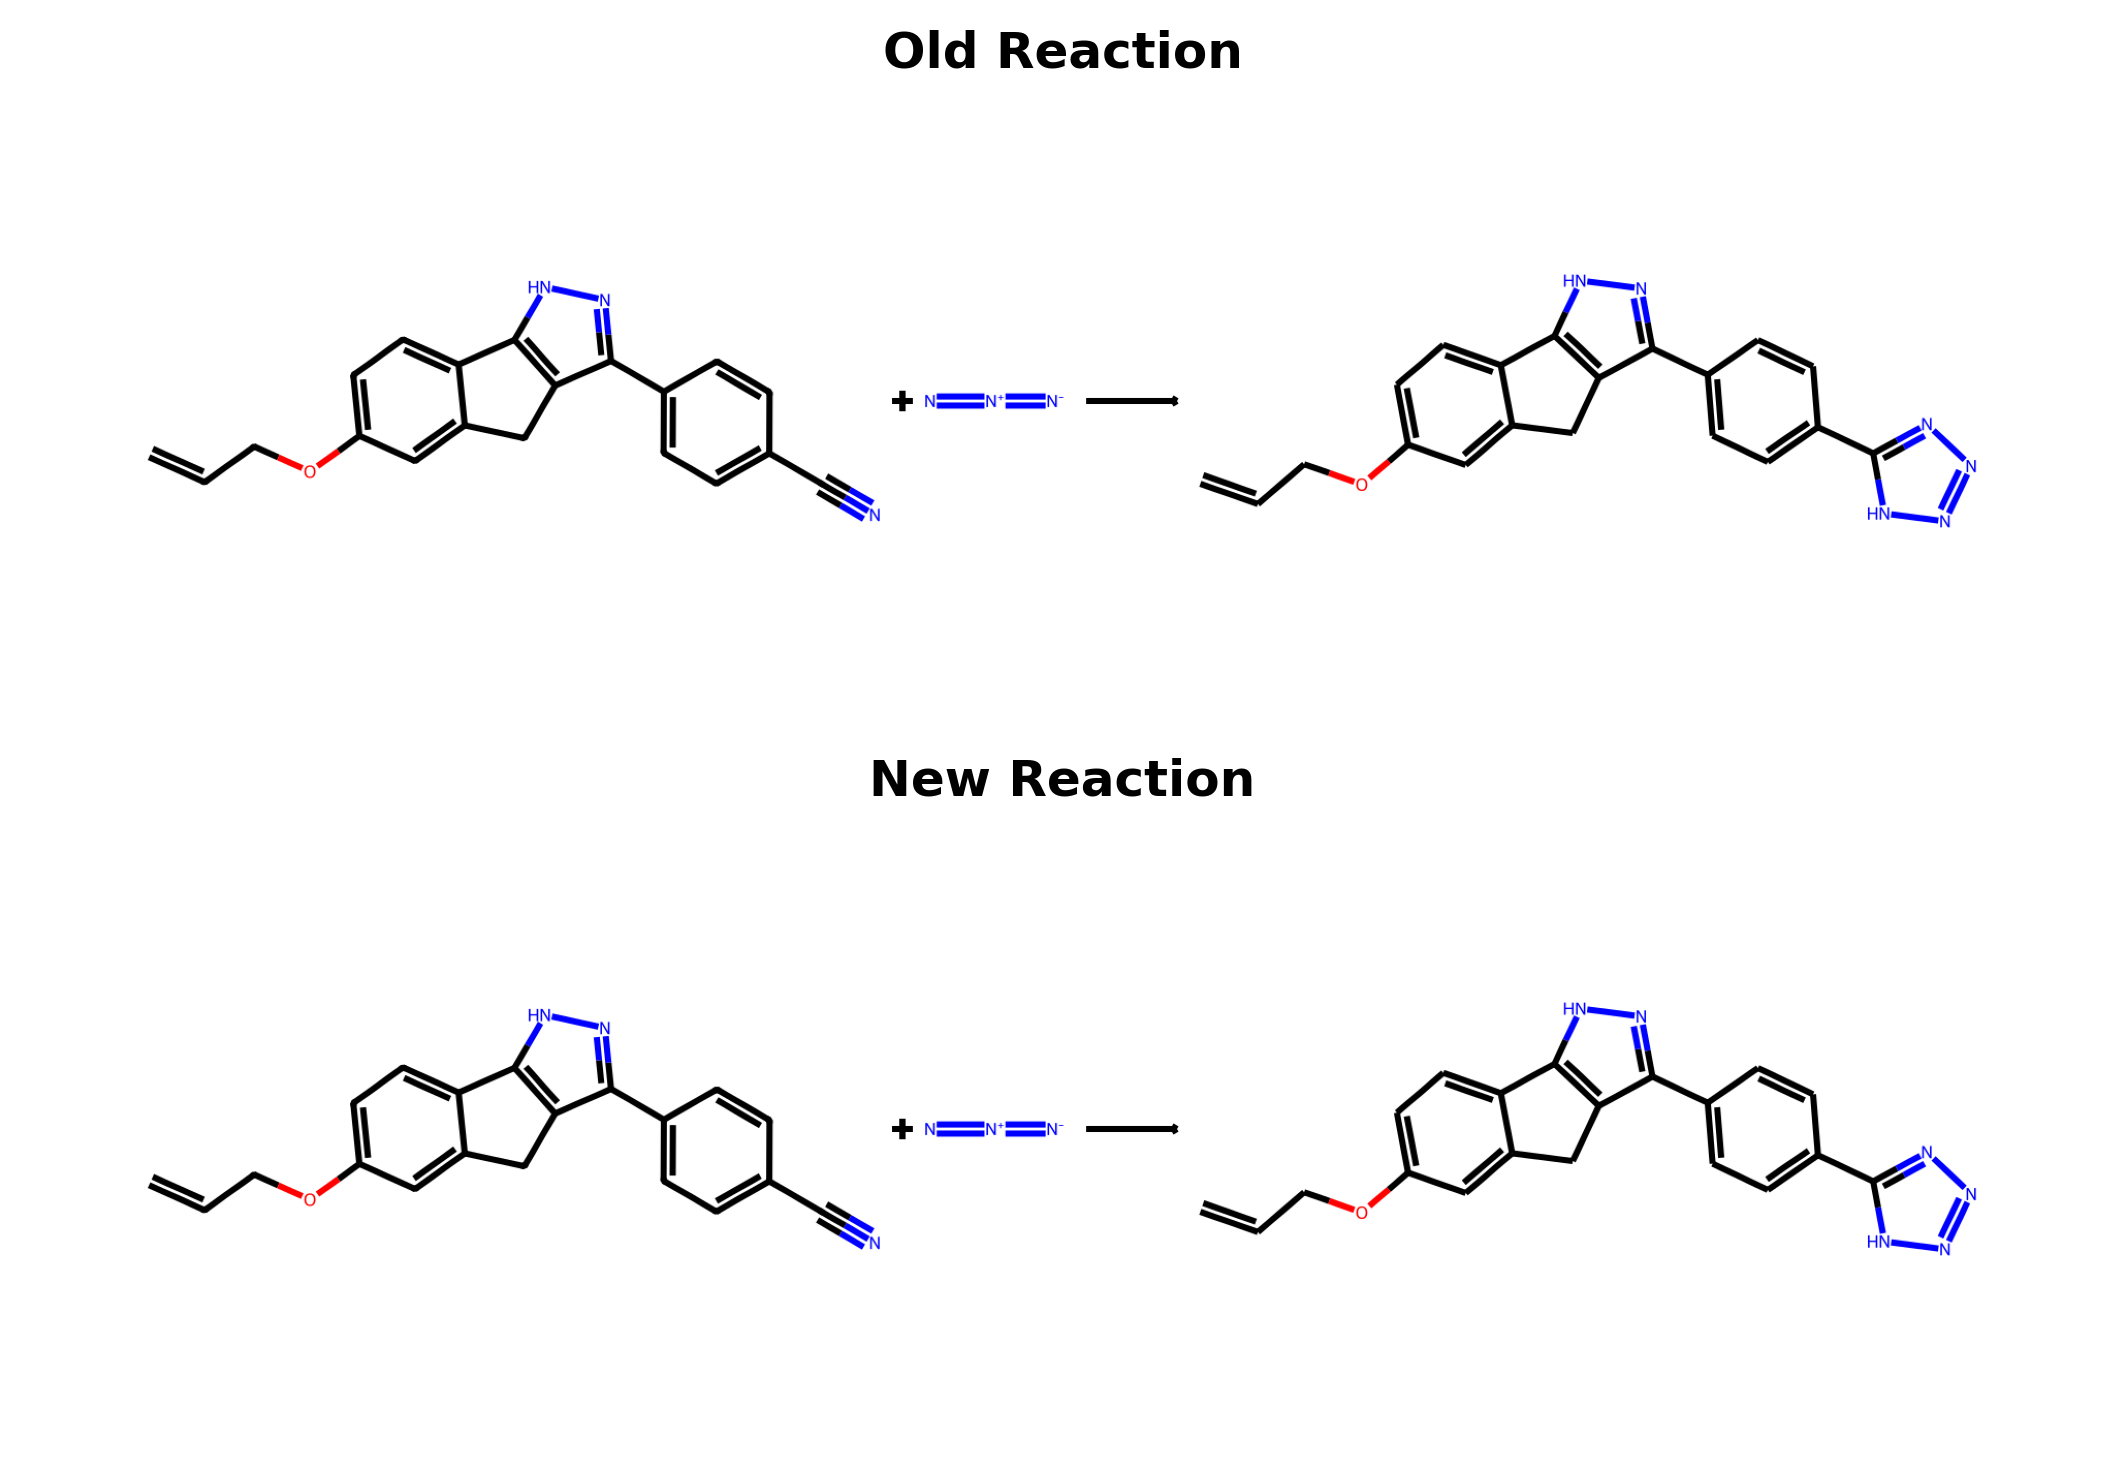

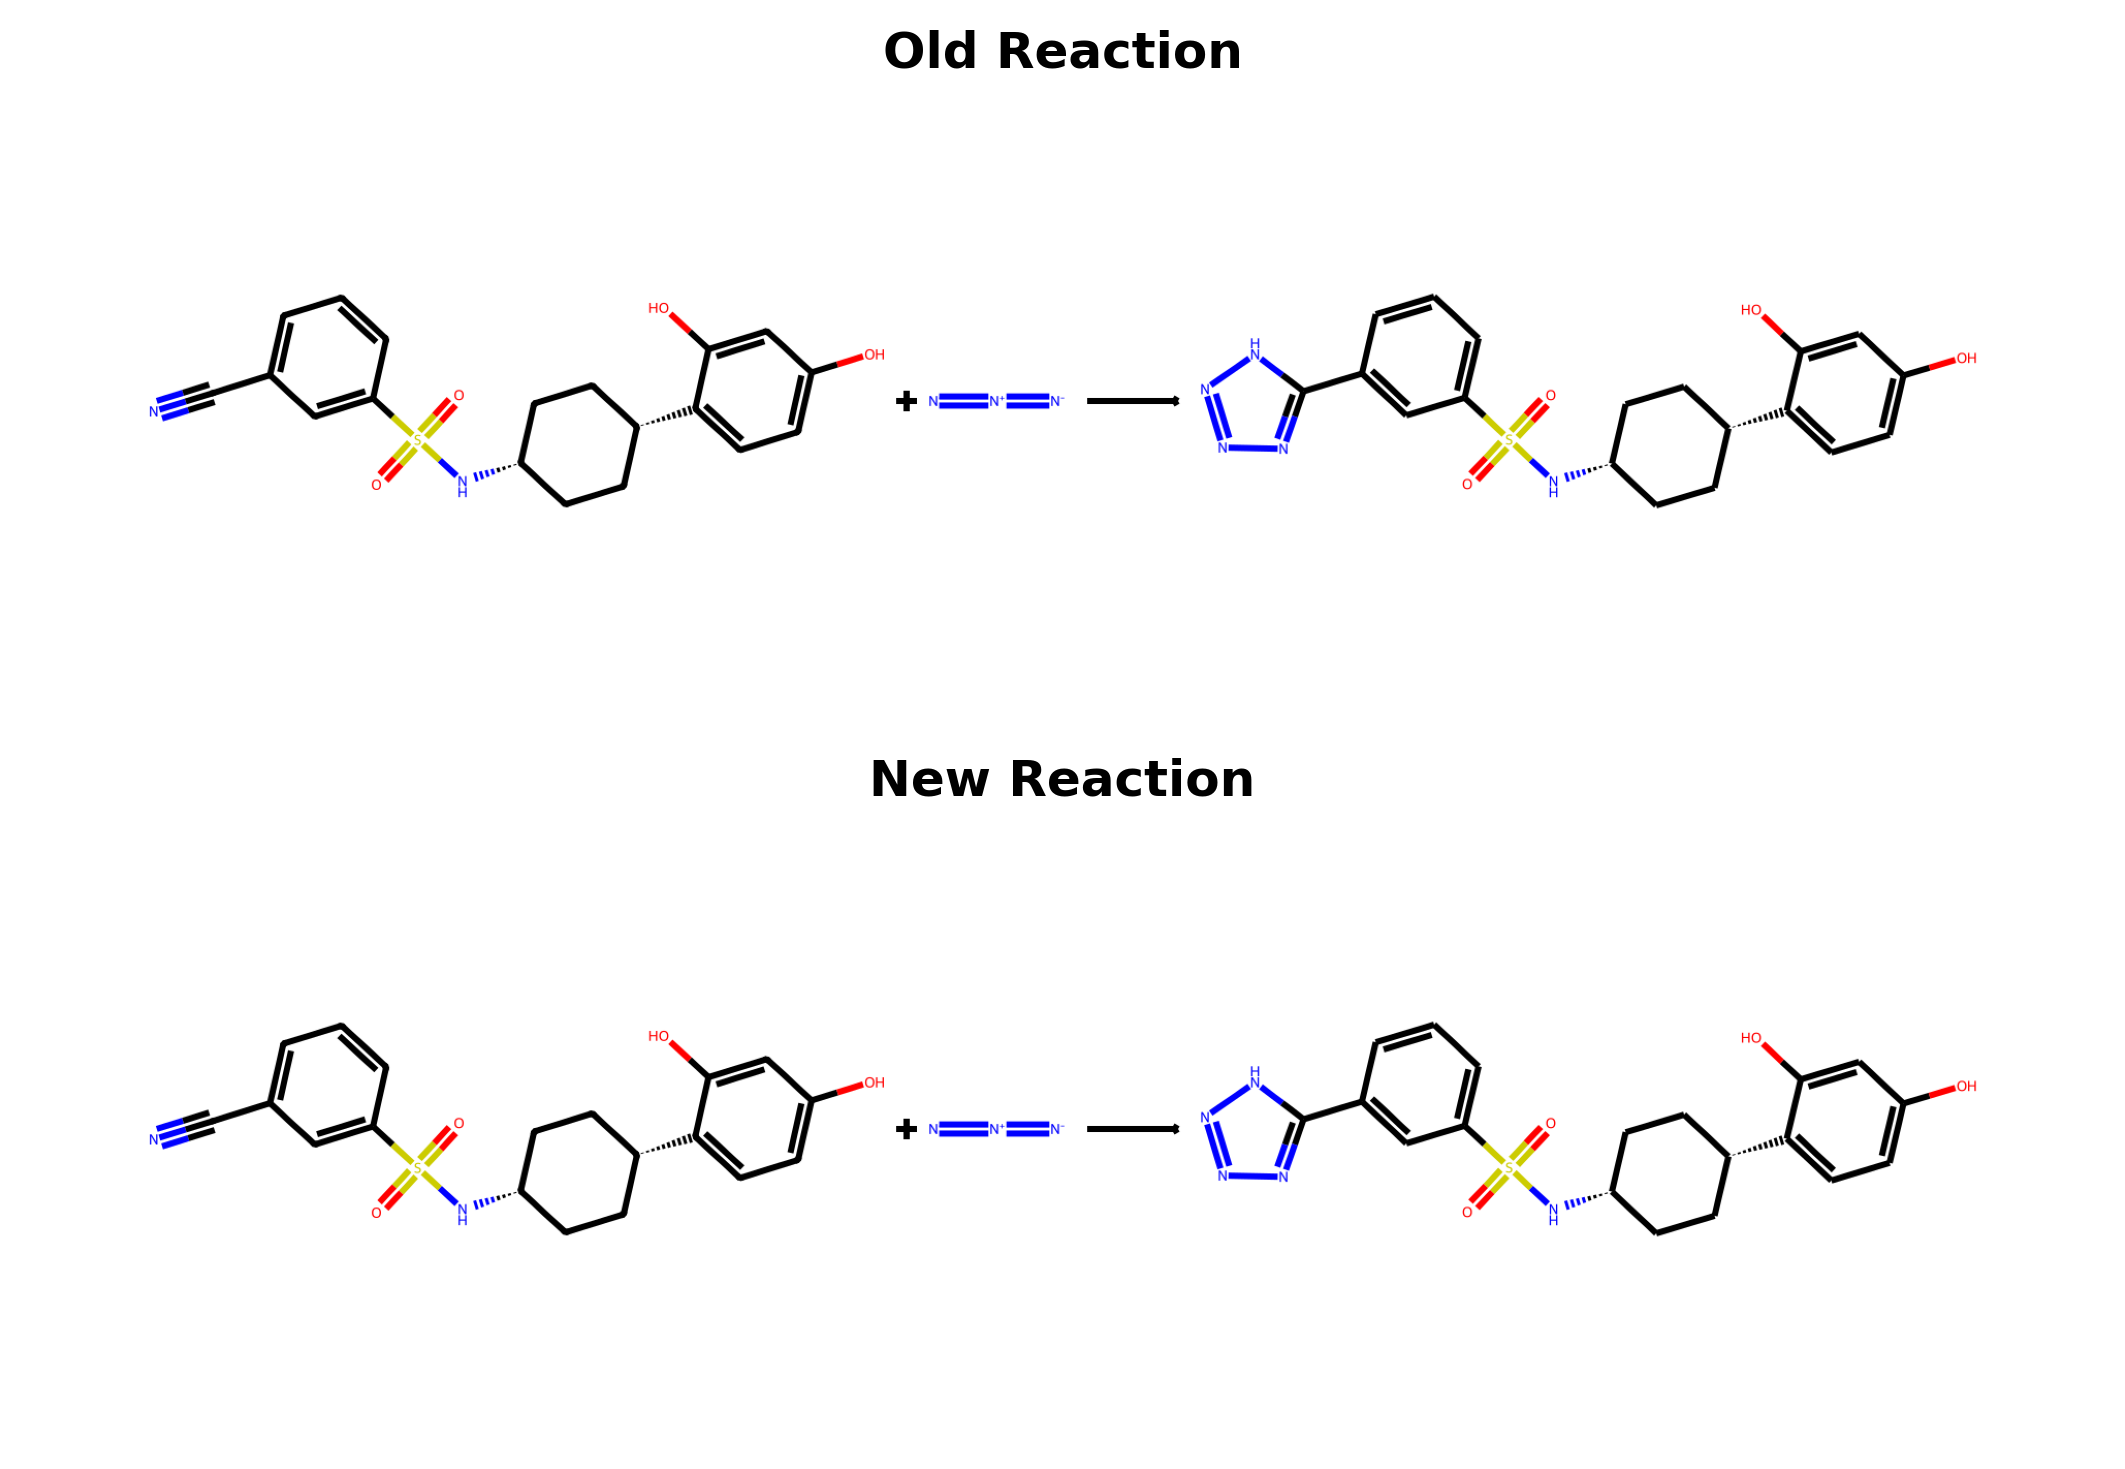

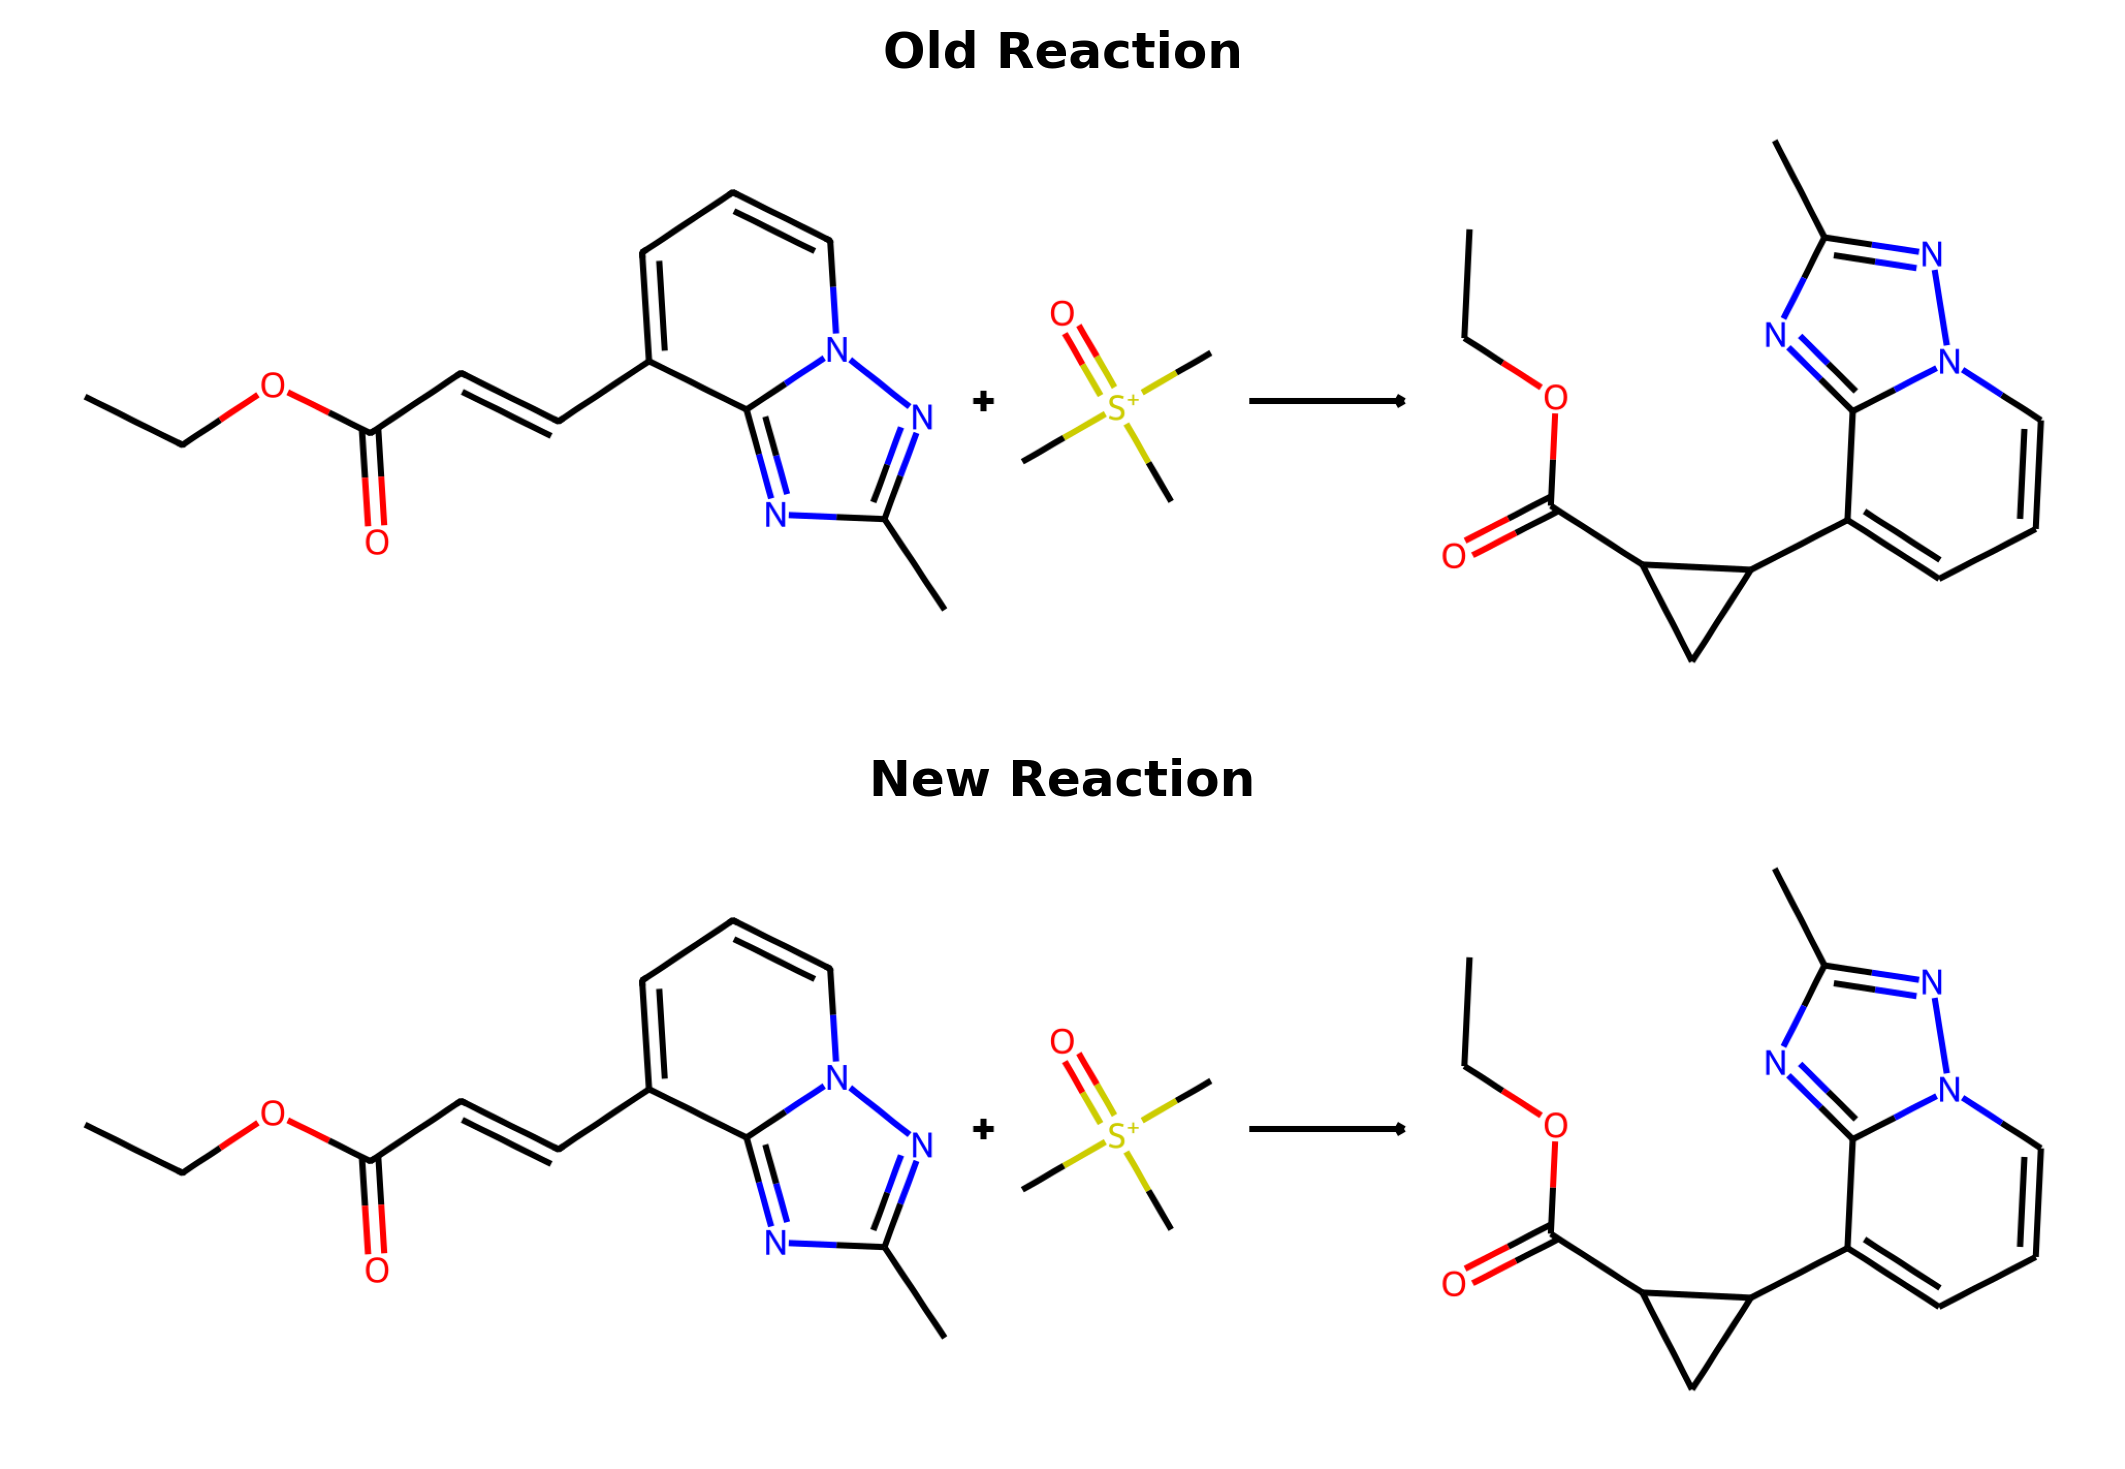

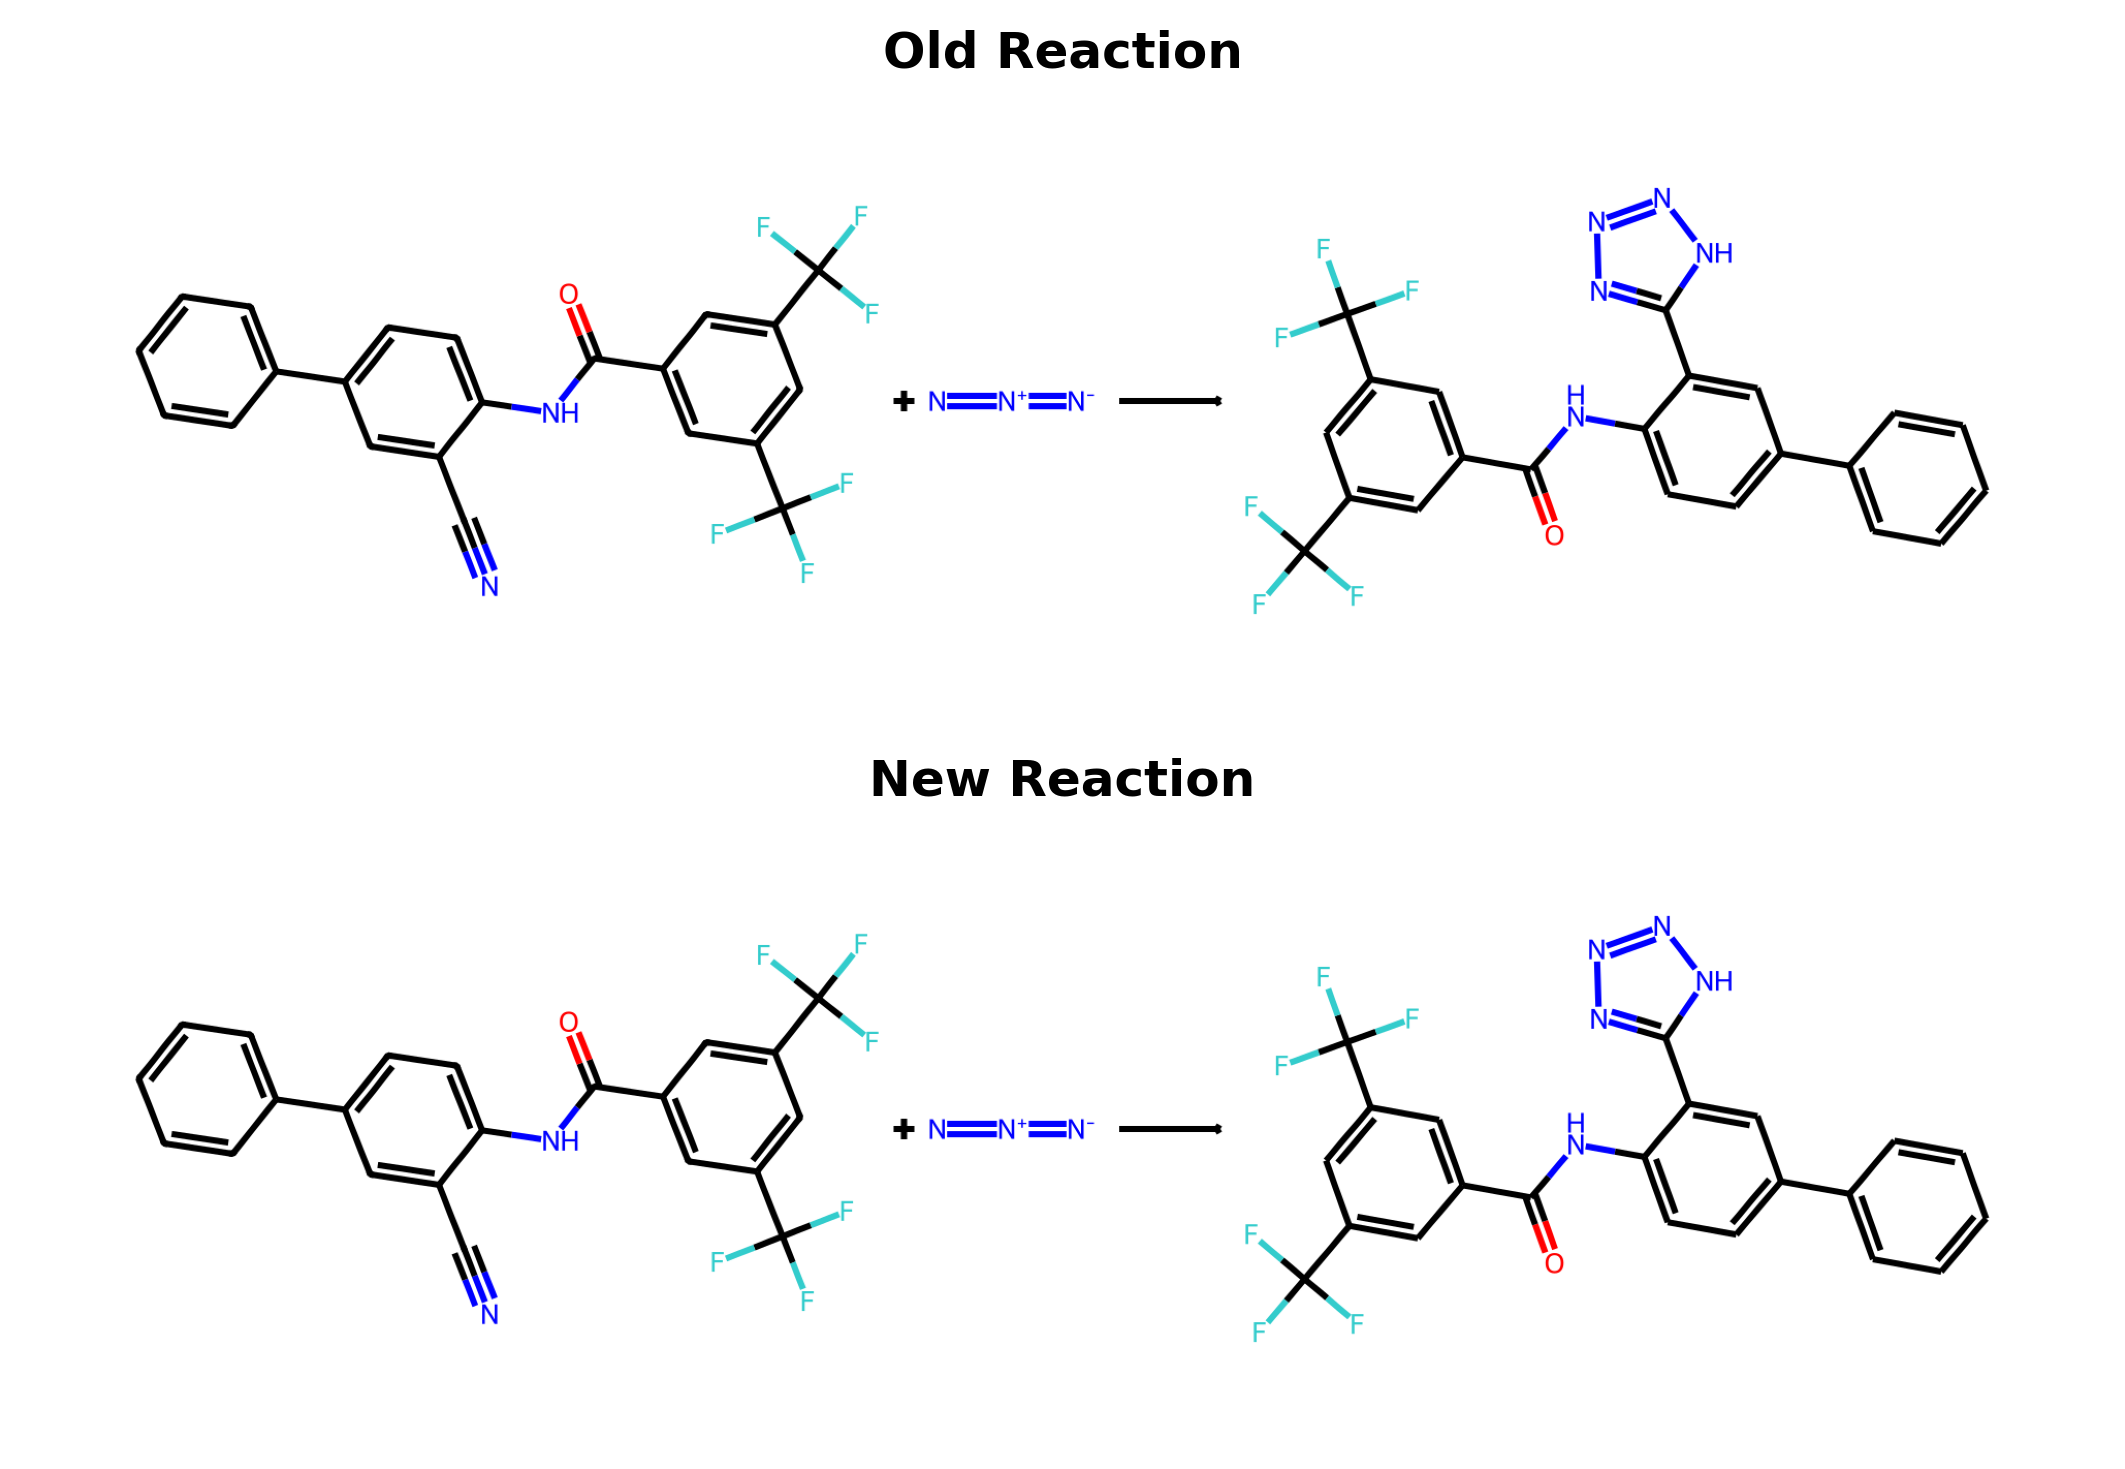

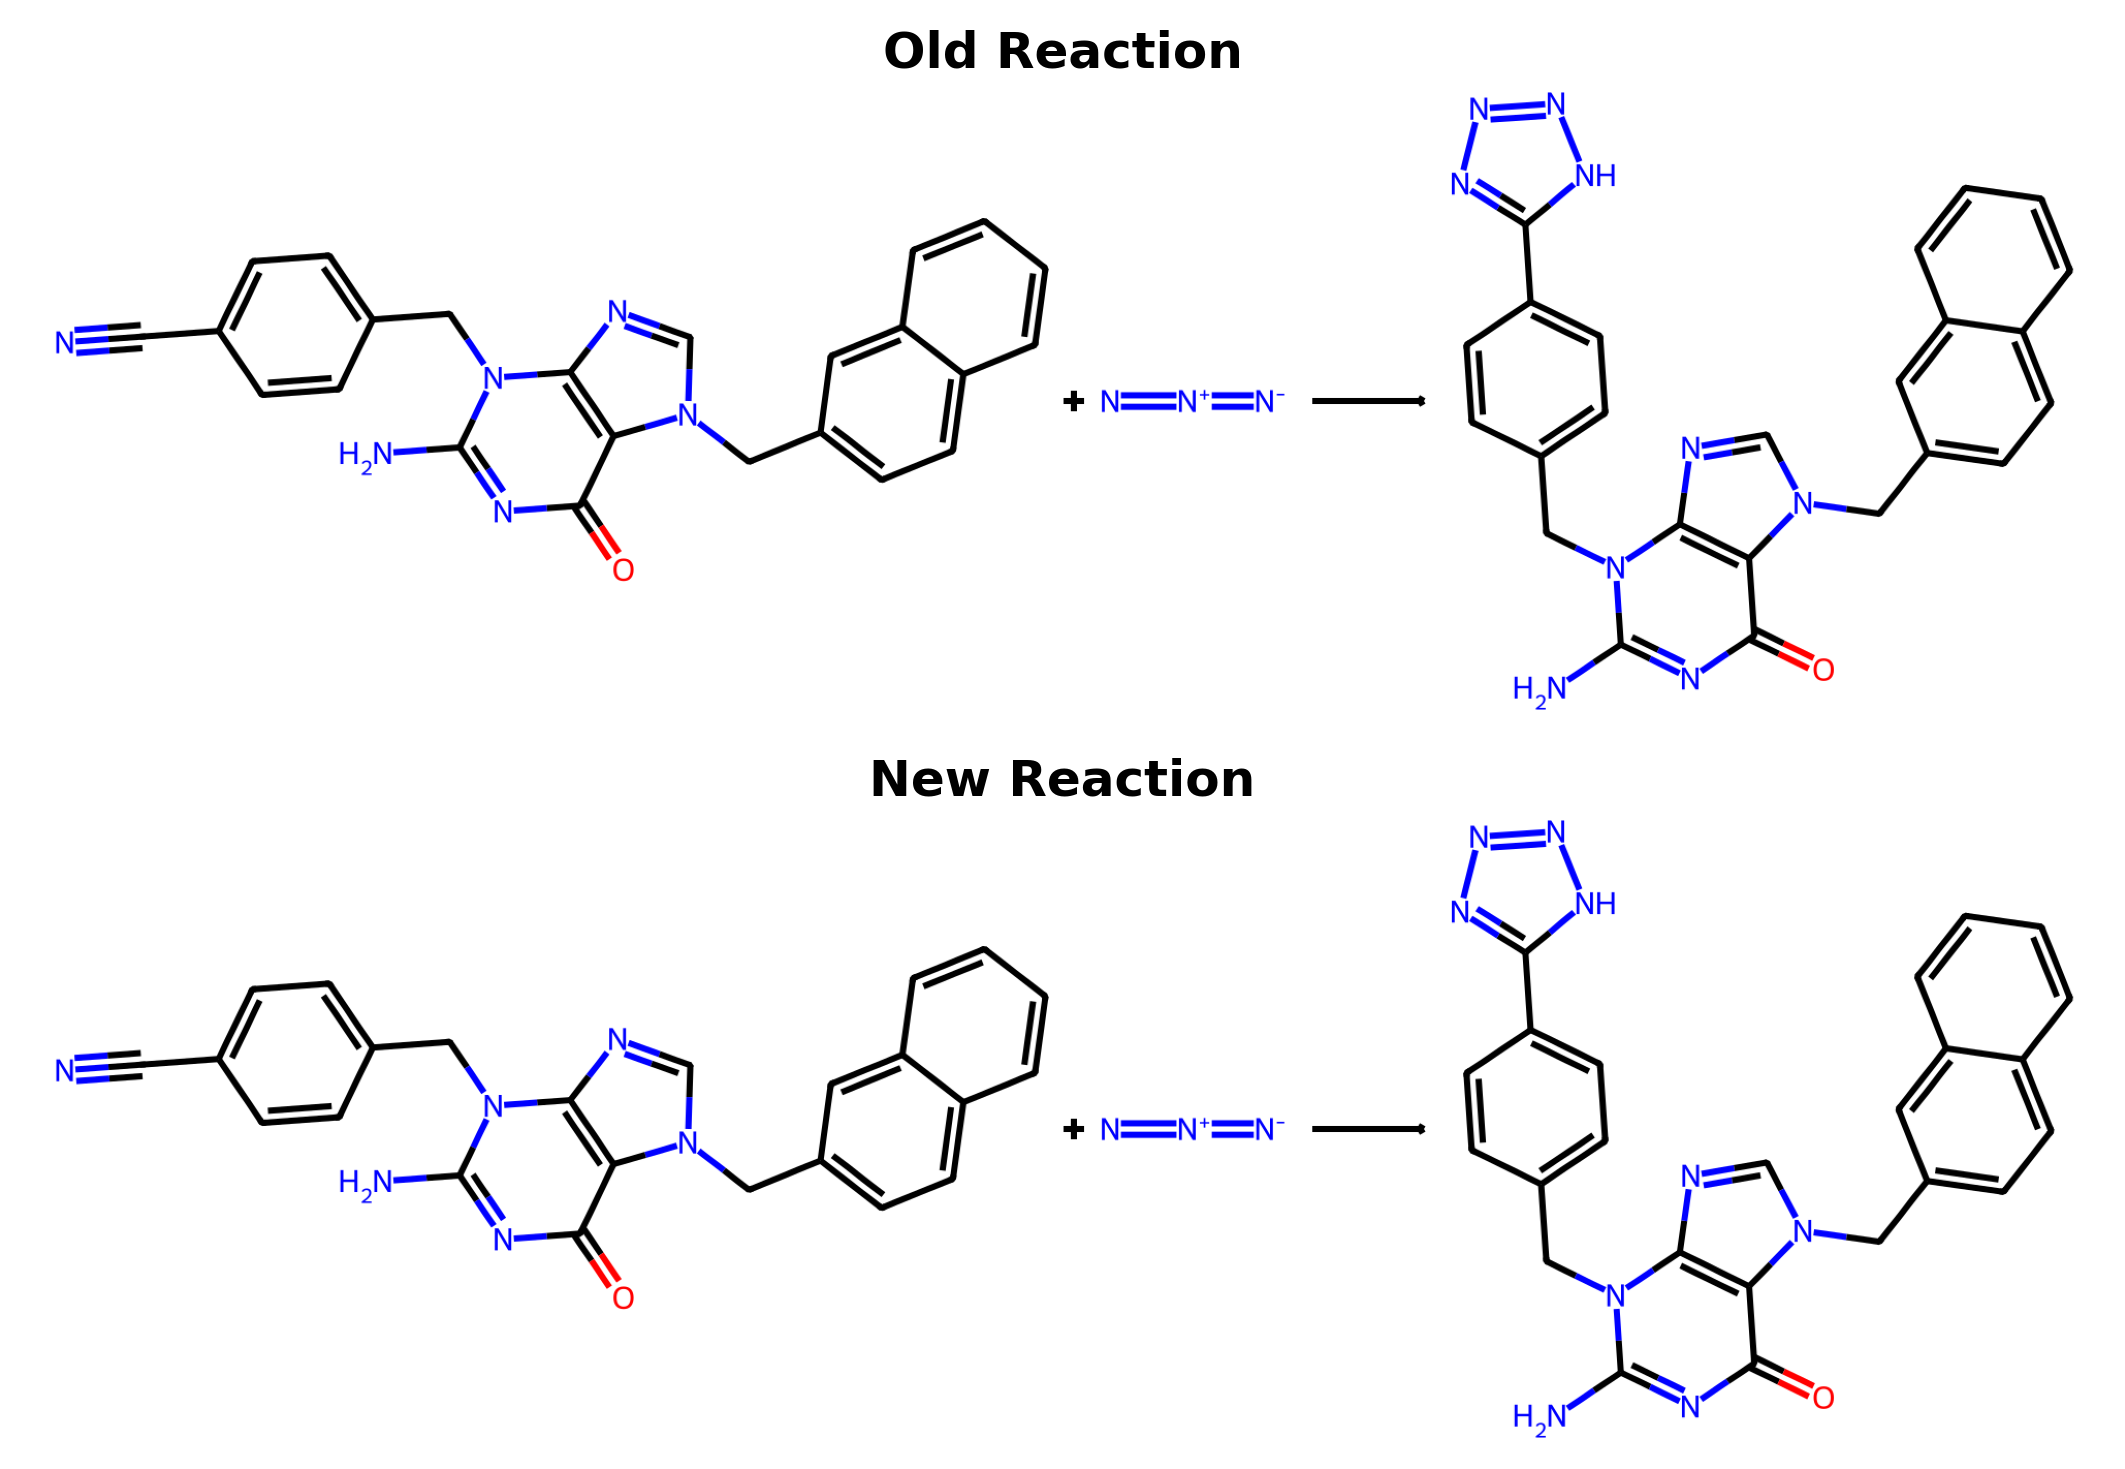

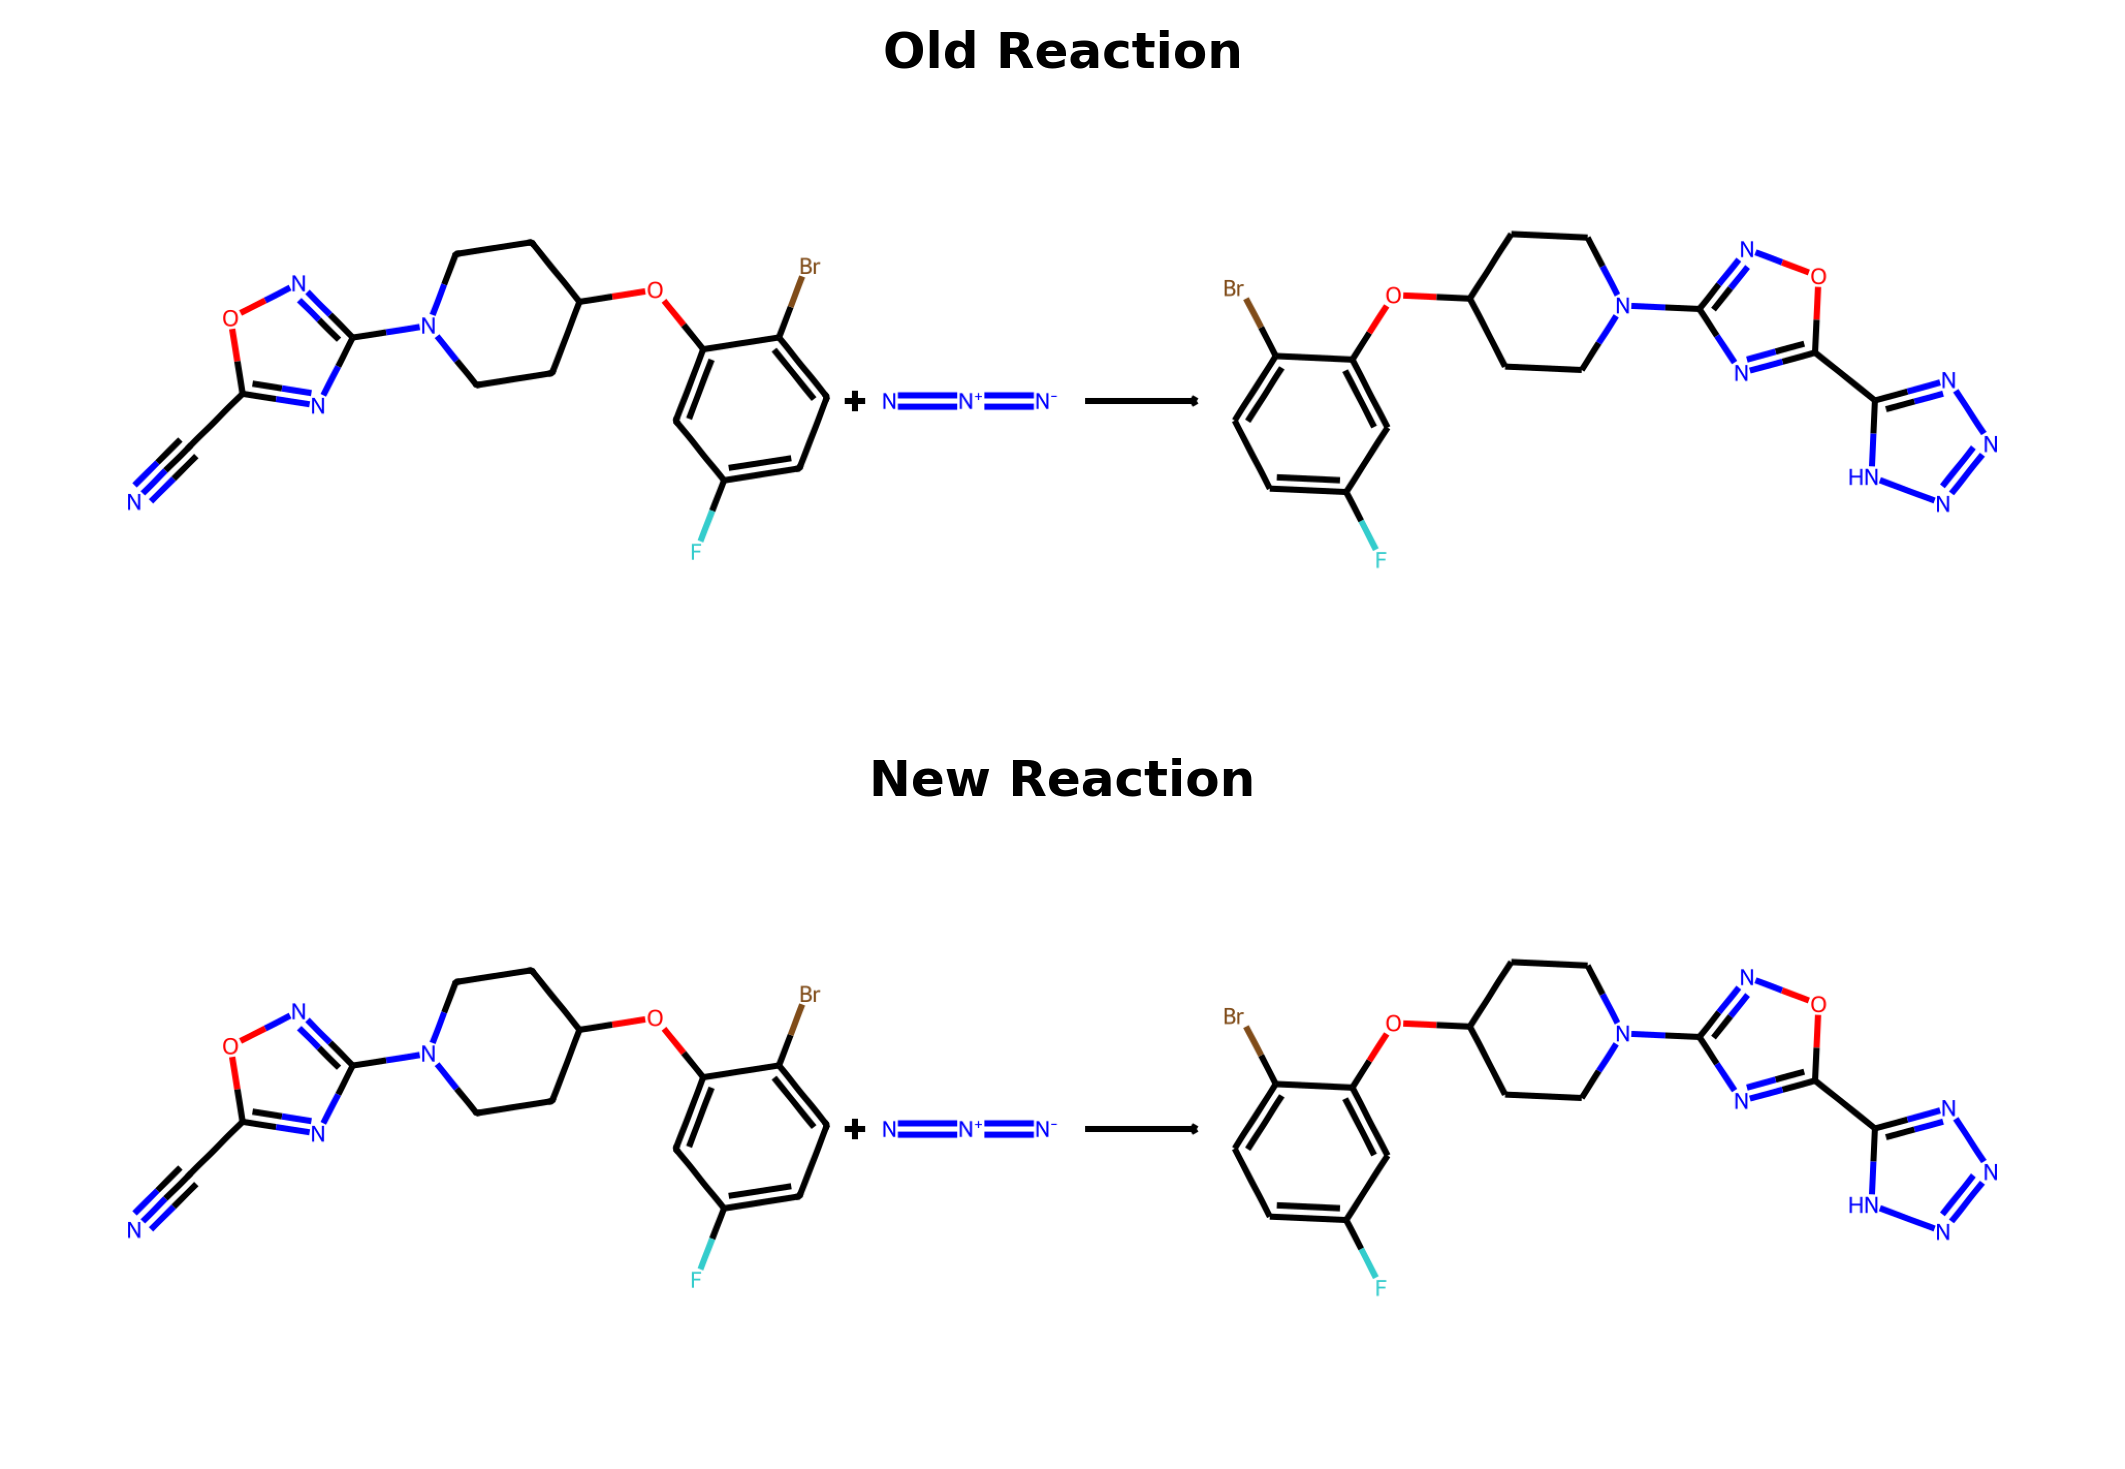

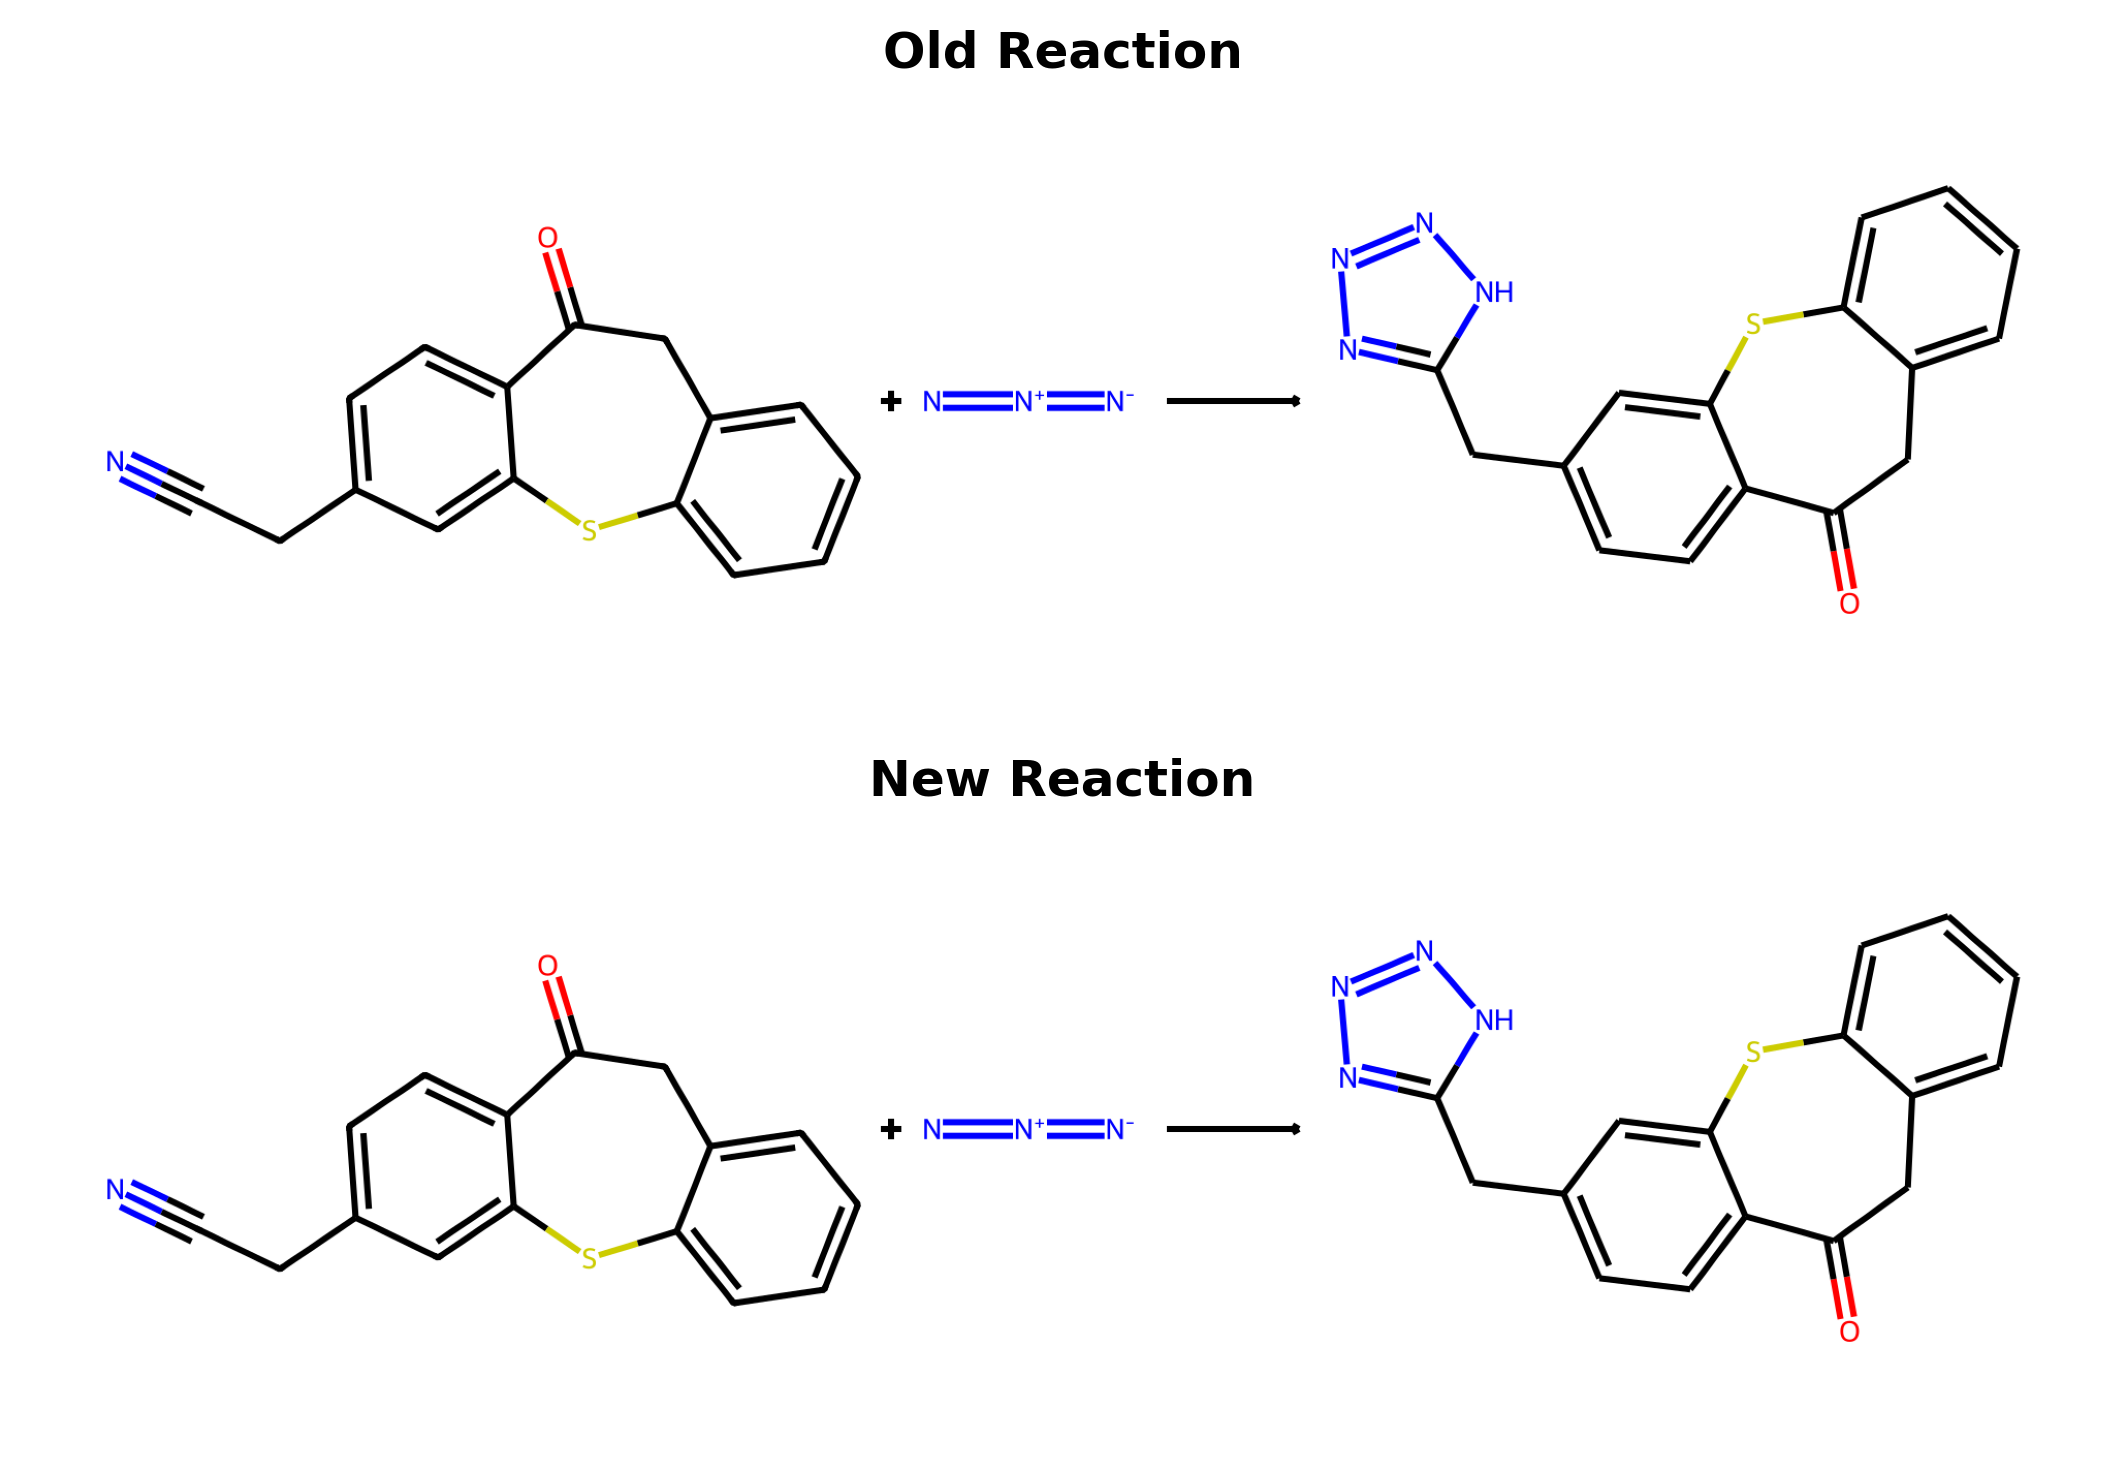

In [347]:
for i in range(420, 440,1):
    try:
        vis = ReactionVisualizer()
        vis.plot_reactions(valid_mcs_3[i], 'old_reaction', 'new_reaction', show_atom_numbers=False, compare= True, savefig=False, pathname = None, dpi=300)
    except:
        vis = ReactionVisualizer()
        vis.plot_reactions(valid_mcs_3[i], 'old_reaction', 'old_reaction', show_atom_numbers=False, compare= True, savefig=False, pathname = None, dpi=300)
  


In [326]:
Chem.CanonSmiles('[N-]=[N+]=[N-]')

'[N-]=[N+]=[N-]'

In [333]:
valid_mcs_3[450]

{'id': 'US20070082899A1',
 'old_reaction': 'CC(=O)N(C)c1ccc2c(c1)nc(C(C)(C)C)n2CC1CCC1>>CNc1ccc2c(c1)nc(C(C)(C)C)n2CC1CCC1',
 'new_reaction': 'CC(=O)N(C)c1ccc2c(c1)nc(C(C)(C)C)n2CC1CCC1>>CNc1ccc2c(c1)nc(C(C)(C)C)n2CC1CCC1.CO.CO.O',
 'merge_rules': ['default single bond', 'default single bond'],
 'compound_rules': ['append O to C-C bond',
  'append O when next to O or N',
  'no expansion'],
 'issue': None}

In [283]:
valid_mcs_3[284]

{'id': 'US08969388B1',
 'old_reaction': 'Cc1c(C(=O)Nc2ccc(Oc3ccnc(C(N)=O)c3)c(Cl)c2)c(=O)n(-c2ccccc2)n1C>>Cc1c(C(=O)Nc2ccc(Oc3ccnc(N)c3)c(Cl)c2)c(=O)n(-c2ccccc2)n1C',
 'new_reaction': 'Cc1c(C(=O)Nc2ccc(Oc3ccnc(C(N)=O)c3)c(Cl)c2)c(=O)n(-c2ccccc2)n1C>>Cc1c(C(=O)Nc2ccc(Oc3ccnc(N)c3)c(Cl)c2)c(=O)n(-c2ccccc2)n1C.NC(=O)O',
 'merge_rules': ['default single bond'],
 'compound_rules': ['append O to C-C bond'],
 'issue': None}

In [180]:
valid_mcs_3[167]

{'id': 'US20070259965A1',
 'old_reaction': 'CC[C@H](N=[N+]=[N-])[C@H](O)CNC(=O)OC(C)(C)C>>CC[C@H](N)[C@H](O)CNC(=O)OC(C)(C)C',
 'new_reaction': 'CC[C@H](N=[N+]=[N-])[C@H](O)CNC(=O)OC(C)(C)C>>CC[C@H](N)[C@H](O)CNC(=O)OC(C)(C)C.[N-]=[NH2+]',
 'merge_rules': [],
 'compound_rules': ['no expansion'],
 'issue': None}

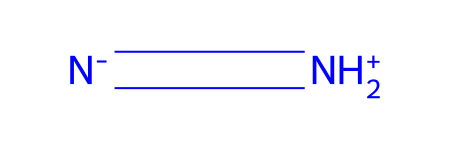

In [188]:
Chem.MolFromSmiles('[N-]=[NH2+]', sanitize=True)

In [185]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize import normalize, tautomer, charge
def uncharge_molecule(mol: Chem.Mol) -> Chem.Mol:
    """
    Neutralize a molecule by removing counter-ions using RDKit's Uncharger.

    Args:
        mol: RDKit Mol object.

    Returns:
        Neutralized Mol object.
    """
    uncharger = rdMolStandardize.Uncharger()
    return uncharger.uncharge(mol)

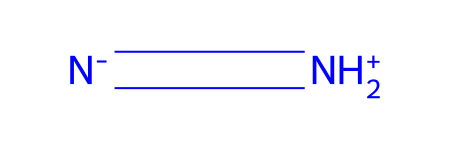

In [186]:
uncharge_molecule(Chem.MolFromSmiles('[N-]=[NH2+]'))

In [112]:
valid_mcs_3[91]

{'id': 'US20140049823A1',
 'old_reaction': 'C=CCBr.CCOP(OCC)OCC>>C=CCP(=O)(OCC)OCC',
 'new_reaction': 'C=CCBr.CCOP(OCC)OCC>>C=CCP(=O)(OCC)OCC.Br.CCO',
 'merge_rules': [],
 'compound_rules': [],
 'issue': None}

In [335]:
original_3 = load_database('../../Data/MCS/Original_data_Intersection_MCS_3+_matching_ensemble.json.gz')
pd.DataFrame(original_3)[pd.DataFrame(original_3)['id'] == 'US20070082899A1']

id  class  \
310    US20070082899A1      6   
11959  US20070082899A1      6   

                                               reactions  \
310    CC(=O)N(C)c1ccc2c(c1)nc(C(C)(C)C)n2CC1CCC1>>CN...   
11959  CC(=O)N(C)c1ccc2c(c1)nc(C(F)(F)F)n2CC1CCOCC1>>...   

                                          reactants  \
310      CC(=O)N(C)c1ccc2c(c1)nc(C(C)(C)C)n2CC1CCC1   
11959  CC(=O)N(C)c1ccc2c(c1)nc(C(F)(F)F)n2CC1CCOCC1   

                                   products standardized_reactants  \
310      CNc1ccc2c(c1)nc(C(C)(C)C)n2CC1CCC1                    NaN   
11959  CNc1ccc2c(c1)nc(C(F)(F)F)n2CC1CCOCC1                    NaN   

      standardized_products Unbalance              Diff_formula  
310                     NaN  Products  {'C': 2, 'O': 1, 'H': 2}  
11959                   NaN  Products  {'C': 2, 'O': 1, 'H': 2}

In [336]:
graph_3 = load_database('../../Data/MCS/Final_Graph_macth_3+.json.gz')
graph_3[310]

{'smiles': ['C.C.O'],
 'boundary_atoms_products': [[{'C': 0}, {'O': 2}, {'C': 1}]],
 'nearest_neighbor_products': [[{'C': 1}, {'C': 1}, {'N': 3}]],
 'issue': ''}

In [338]:
mcs_3 = load_database('../../Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz')
mcs_3[310]

{'mcs_results': ['CNC1:C:C:C2:C(:C:1):N:C(C(C)(C)C):N:2CC1CCC1'],
 'sorted_reactants': ['CC(=O)N(C)c1ccc2c(c1)nc(C(C)(C)C)n2CC1CCC1'],
 'issue': []}

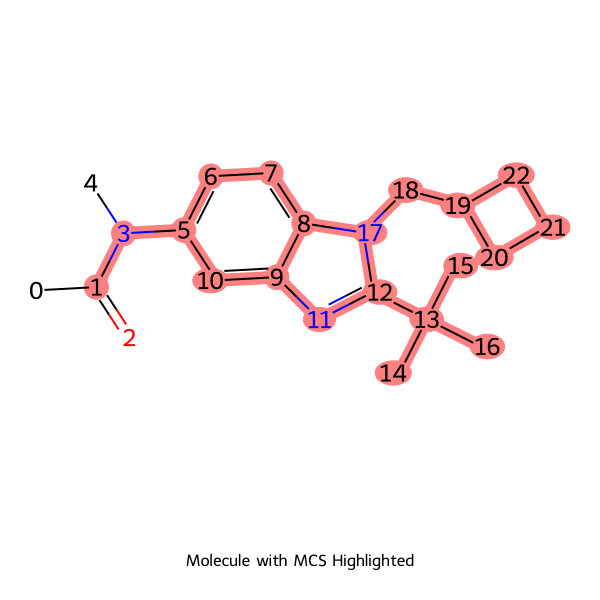

In [345]:
#from SynRBL.SynVis.mcs_visualizer import MCSVisualizer
vis = MCSVisualizer()
vis.highlight_molecule(molecule_smiles=mcs_3[310]['sorted_reactants'][0], mcs_smiles=mcs_3[310]['mcs_results'][0], show_atom_numbers=True, compare=False, missing_graph_smiles=None)

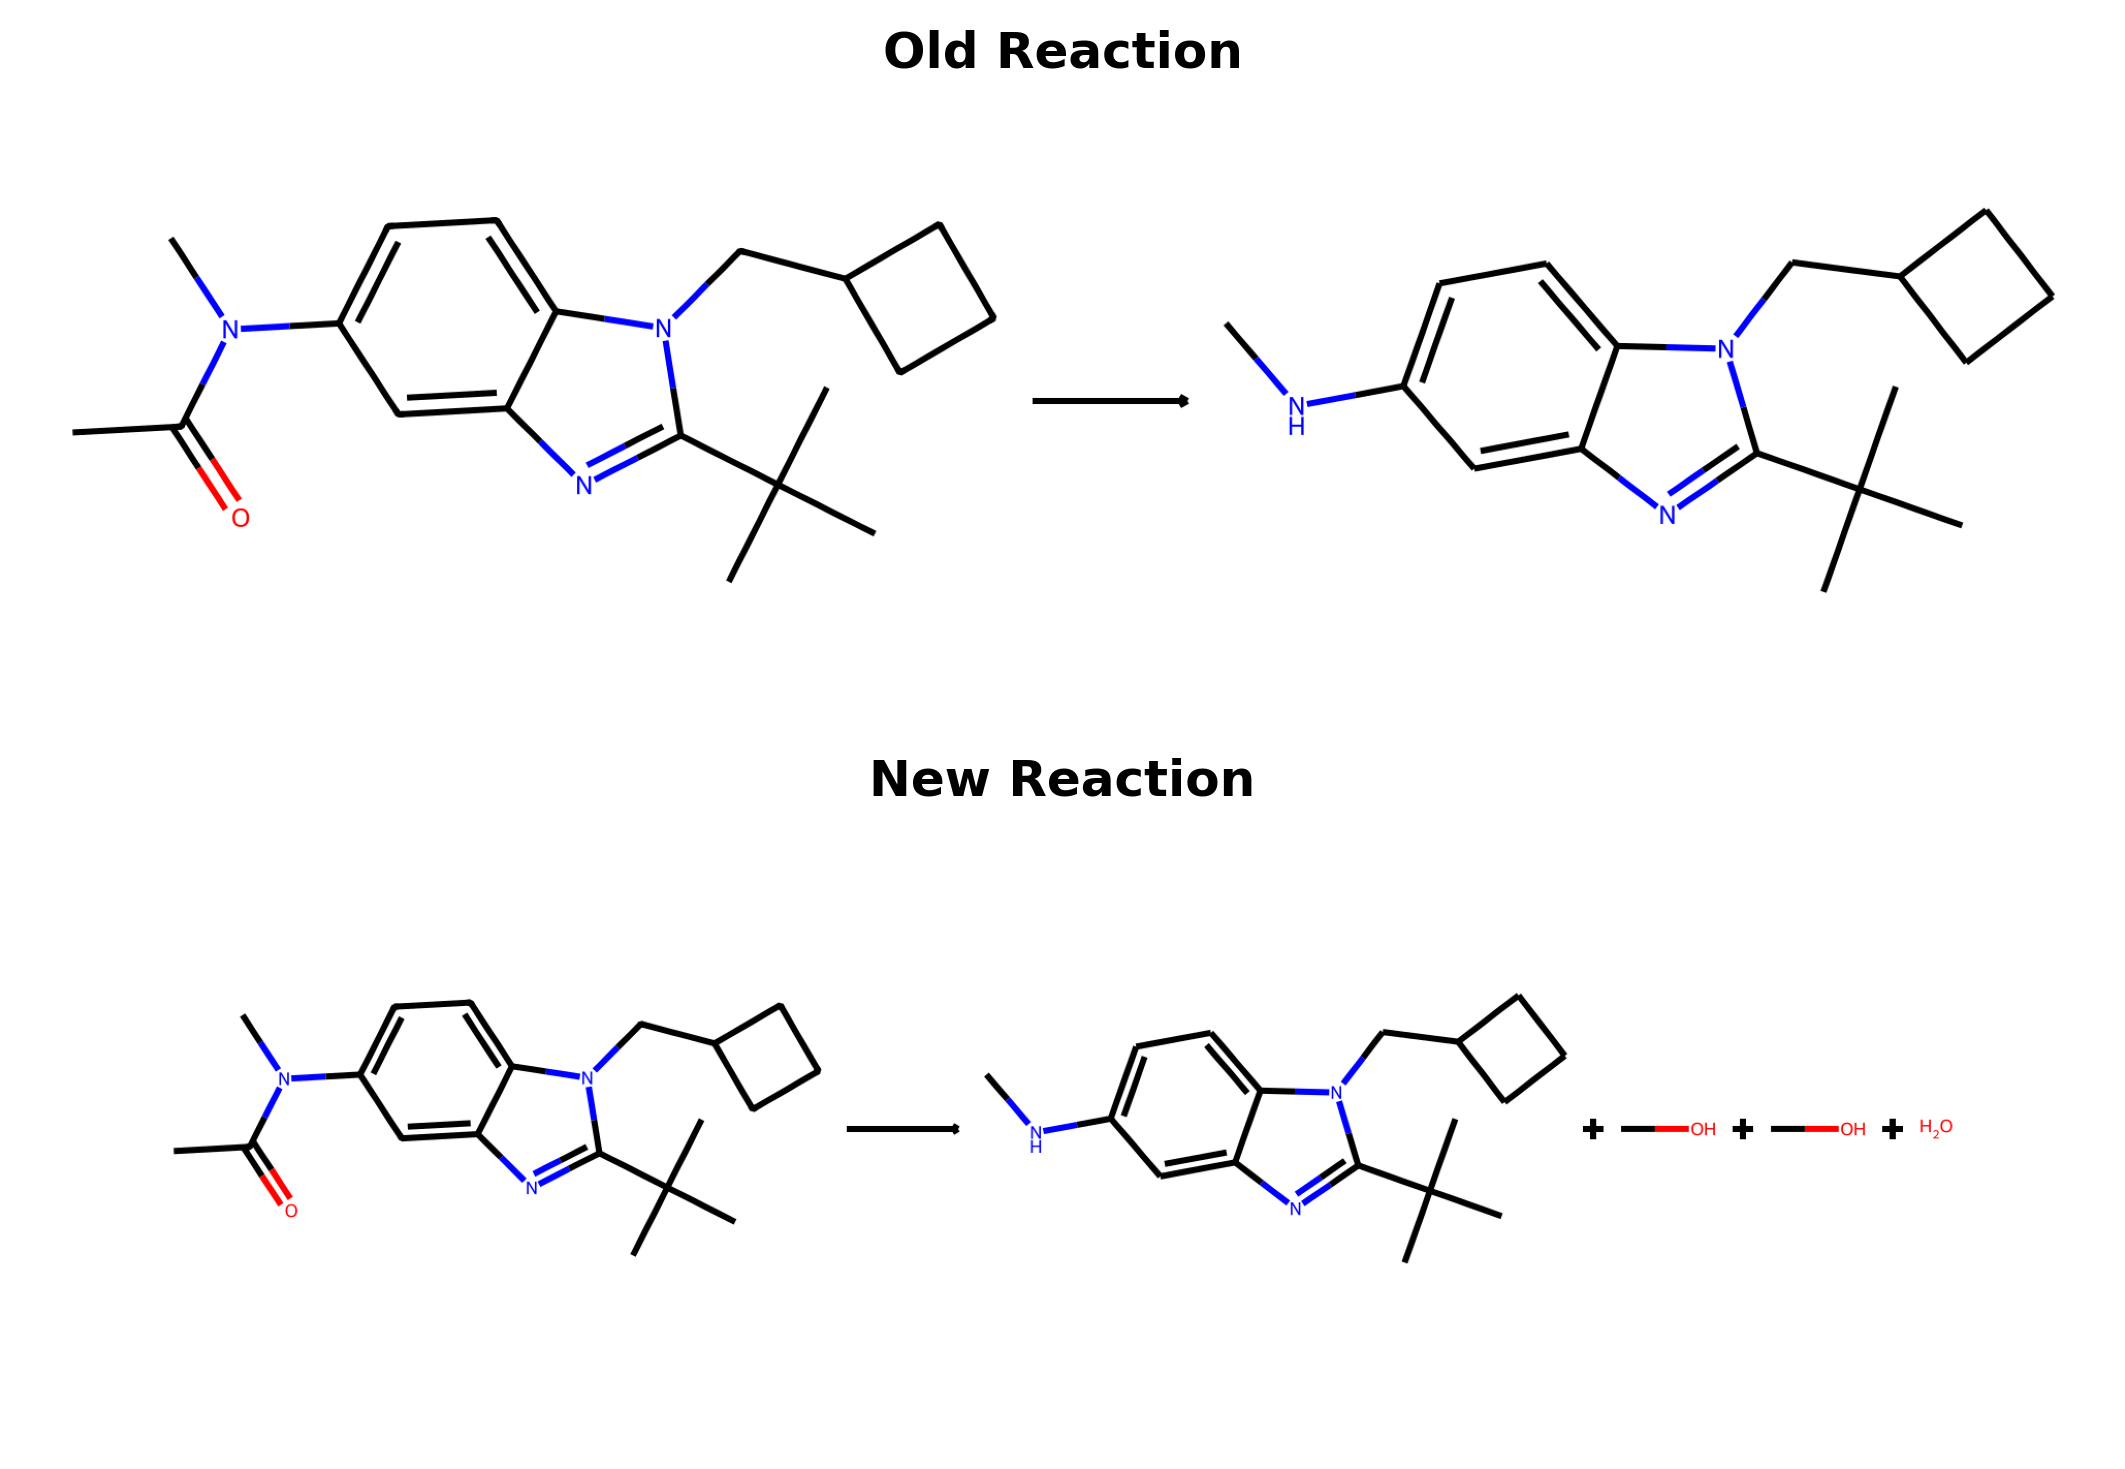

In [337]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(valid_mcs_3[450], 'old_reaction', 'new_reaction', show_atom_numbers=False, compare= True, savefig=False, pathname = None, dpi=300)